In [1]:
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd 
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns
import math
%matplotlib inline

In [2]:
# import keras

# config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} )
# sess = tf.Session(config=config) 
# keras.backend.set_session(sess)

In [3]:
# Splitting images Train/Val/Test

# import split_folders
# # Split with a ratio.
# # To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
# split_folders.ratio('dataset/cam1', output="dataset/prueba", seed=45, ratio=(.7, .15, .15)) # default values

In [4]:
base_dir = 'dataset/all_split_2'
test_dir =  os.path.join(base_dir, 'test')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'Val')

# Directory with our training pictures
train_OK_dir = os.path.join(train_dir, 'OK')
train_NOT_OK_dir = os.path.join(train_dir, 'NOT_OK')

# Directory with our validation pictures
validation_OK_dir = os.path.join(validation_dir, 'OK')
validation_NOT_OK_dir = os.path.join(validation_dir, 'NOT_OK')
train_OK_fnames = os.listdir( train_OK_dir )
train_NOT_OK_fnames = os.listdir( train_NOT_OK_dir )

# print(train_cat_fnames[:10])
# print(train_dog_fnames[:10])



FileNotFoundError: [WinError 3] The system cannot find the path specified: 'dataset/all_split_2\\train\\OK'

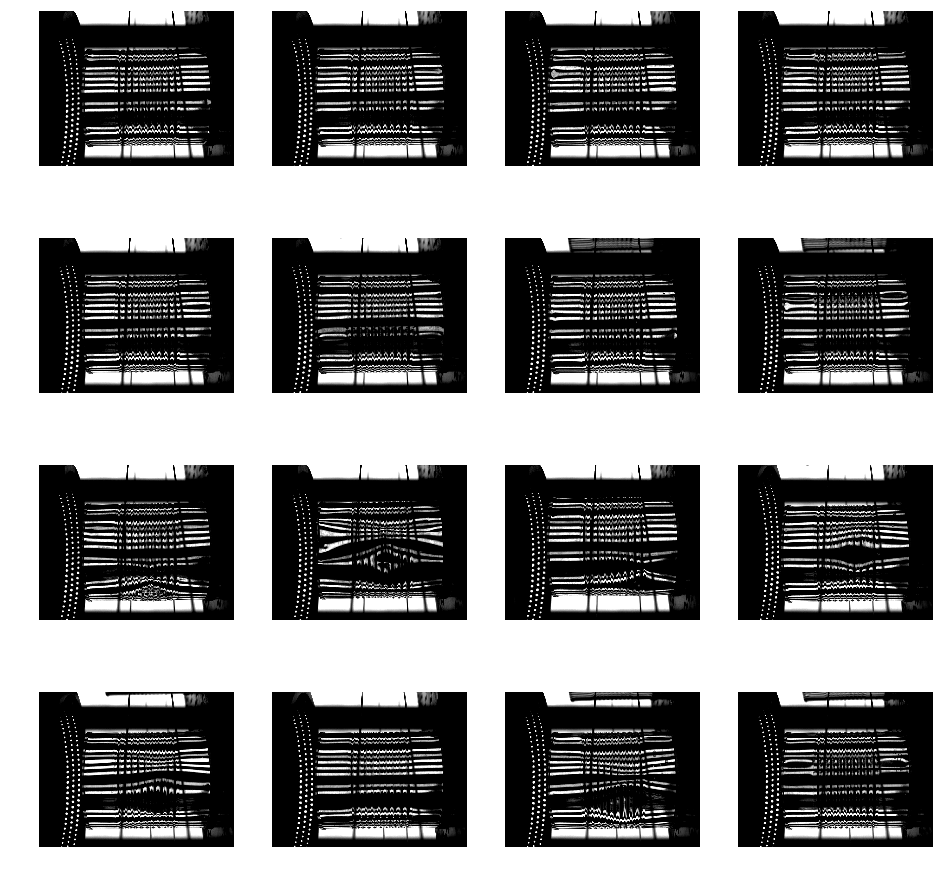

In [9]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 20 # Index for iterating over images
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_OK_pix = [os.path.join(train_OK_dir, fname) 
                for fname in train_OK_fnames[ pic_index-8:pic_index] 
               ]

next_NOT_OK_pix = [os.path.join(train_NOT_OK_dir, fname) 
                for fname in train_NOT_OK_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_OK_pix+next_NOT_OK_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
#   print(img.shape)  
  plt.imshow(img, 'gray')

In [6]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(
      rescale=1/255,
#       rotation_range=40,
#       width_shift_range=0.2,
#       height_shift_range=0.2,
#       fill_mode='nearest',
#       shear_range=0.2,
#       zoom_range=0.2,
#       horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images

        ### En esta linea de codigo se cambia el tamaño de la imagen

        target_size=(512, 512),  # All images will be resized 

        ####

        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')
# Flow training images in batches of 128 using train_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,  # This is the source directory for training images

        ##Tamaño de imagen del validation dataset


        target_size=(512, 512),  # All images will be resized 
        ###


        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 20113 images belonging to 2 classes.
Found 2236 images belonging to 2 classes.


In [7]:
# def plots(ims, figsize=(12,6), rows=3, interp=False, titles=None):
#     if type(ims[0]) is np.ndarray:
#         ims = np.array(ims).astype(np.uint8)
#         if (ims.shape[-1] != 3):
#             ims = ims[:, :, ::-1]
            
#     f = plt.figure(figsize=figsize)
#     cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
#     for i in range(len(ims)):
#         sp = f.add_subplot(rows, cols, i+1)
#         sp.axis('Off')
#         if titles is not None:
#             sp.set_title(titles[i], fontsize=16)
#             ims[i] = np.reshape(ims[i],((128,128)))
#         plt.imshow(ims[i], interpolation=None if interp else 'none')
#         print(ims[i].shape)
# imgs, labels = next(train_generator)

# plots(imgs)

In [8]:
# train_generator.samples

In [9]:
classifier = Sequential()
classifier.add(Convolution2D(32,(5,5),input_shape=(512, 512,3),activation= "relu",padding="same")) ##
# classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size = (4,4)))
classifier.add(Convolution2D(64,(3,3),activation='relu',padding="same"))
classifier.add(MaxPooling2D(2))
classifier.add(Convolution2D(256,(3,3),activation='relu',padding="same"))
classifier.add(MaxPooling2D(2))
classifier.add(Convolution2D(256,(3,3),activation='relu',padding="same"))
classifier.add(MaxPooling2D(4))
classifier.add(Convolution2D(512,(3,3),activation='relu',padding="same"))
classifier.add(MaxPooling2D(2))
classifier.add(Convolution2D(512,(3,3),activation='relu',padding="same"))
# classifier.add(MaxPooling2D(2))

classifier.add(Flatten())
classifier.add(Dense(units=2048,activation='relu'))
classifier.add(Dense(units=1024,activation='relu'))
# classifier.add(Dropout(0.5))
classifier.add(Dense(units=512,activation='relu'))
classifier.add(Dense(units=256,activation='relu'))
classifier.add(Dense(units=128,activation='relu'))
classifier.add(Dense(units=64,activation='relu'))
classifier.add(Dense(units=32,activation='relu'))
classifier.add(Dense(units=16,activation='relu'))
classifier.add(Dense(units=8,activation='relu'))
# classifier.add(Dropout(0.5))
classifier.add(Dense(units=1,activation='sigmoid'))

classifier.compile(optimizer= 'adam',loss = 'binary_crossentropy',metrics= ['accuracy'])


In [10]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 256)       147712    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       5

In [17]:
filepath="3_weights-improvement-{epoch:02d}-{val_accuracy:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', mode="max", factor = 0.7, 
     patience = 5, verbose = 1, min_delta =0.00001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, mode='auto')

callbacks = [reduce_lr,checkpoint,early_stop]

batch_size = 64

history = classifier.fit(train_generator,
                                   steps_per_epoch = math.ceil(train_generator.samples//batch_size),
                              validation_data=validation_generator,  
                                   validation_steps=math.ceil(validation_generator.samples//batch_size),
                              epochs=50,workers=-1, 
                            use_multiprocessing=True, shuffle=True, callbacks=callbacks
                              )

Epoch 1/50
62/62 [==============================] - 487s 8s/step - loss: 0.6312 - accuracy: 0.7329 - val_loss: 0.5137 - val_accuracy: 0.7404

Epoch 00001: val_accuracy improved from -inf to 0.74038, saving model to 3_weights-improvement-01-0.74.h5
Epoch 2/50
62/62 [==============================] - 422s 7s/step - loss: 0.4467 - accuracy: 0.7167 - val_loss: 0.5032 - val_accuracy: 0.6947

Epoch 00002: val_accuracy did not improve from 0.74038
Epoch 3/50
62/62 [==============================] - 420s 7s/step - loss: 0.4327 - accuracy: 0.7764 - val_loss: 0.4970 - val_accuracy: 0.8220

Epoch 00003: val_accuracy improved from 0.74038 to 0.82195, saving model to 3_weights-improvement-03-0.82.h5
Epoch 4/50
62/62 [==============================] - 422s 7s/step - loss: 0.3996 - accuracy: 0.8196 - val_loss: 0.3570 - val_accuracy: 0.8558

Epoch 00004: val_accuracy improved from 0.82195 to 0.85577, saving model to 3_weights-improvement-04-0.86.h5
Epoch 5/50
62/62 [==============================] - 4

In [50]:
# classifier.save('model3.h5')

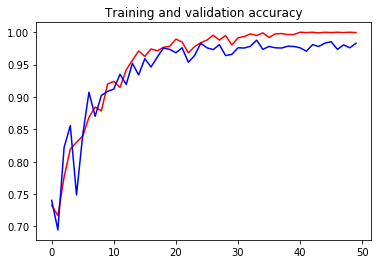

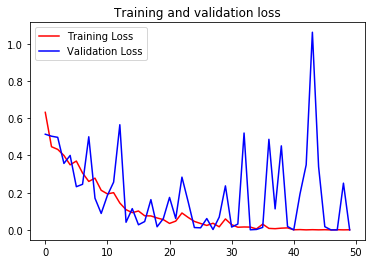

In [18]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
validation_generator.samples

858

In [14]:
from keras.models import load_model
model = load_model('4_weights-improvement-48-0.97.h5')
# score = model.evaluate(x_train, y_train, batch_size=50)

filepath="4_weights-improvement-{epoch:02d}-{val_accuracy:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', mode="max", factor = 0.7, 
     patience = 5, verbose = 1, min_delta =0.00001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, mode='auto')

callbacks = [reduce_lr,checkpoint,early_stop]

batch_size = 64

history = model.fit(validation_generator,
                                   steps_per_epoch = math.ceil(validation_generator.samples//batch_size),
                              validation_data=test_datagen,  
                                   validation_steps=math.ceil(test_generator.samples//batch_size),
                              epochs=50,workers=-1, 
                            use_multiprocessing=True, shuffle=True, callbacks=callbacks )


Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 0.0475 - accuracy: 0.9856

ValueError: Failed to find data adapter that can handle input: <class 'tensorflow.python.keras.preprocessing.image.ImageDataGenerator'>, <class 'NoneType'>

In [12]:
from keras.models import load_model
model = load_model('saved_models/4_weights-improvement-48-0.97.h5')

In [16]:
test_datagen = ImageDataGenerator(rescale=1/255)
# Flow training images in batches of 128 using train_datagen generator
test_generator = test_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images

        ##Tamaño de imagen del validation dataset


        target_size=(512, 512),  # All images will be resized 
        ###


        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 20113 images belonging to 2 classes.


In [17]:
model.compile(optimizer= 'adam',loss = 'binary_crossentropy',metrics= ['accuracy'])

In [18]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 512, 512, 32)      2432      
_________________________________________________________________
batch_normalization_25 (Batc (None, 512, 512, 32)      128       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
batch_normalization_26 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 64, 64, 256)      

In [ ]:
with tf.device('/cpu:0'):
    batch_size= 32
    y = model.predict_generator(test_generator,steps= math.ceil(test_generator.samples//batch_size),workers=8)

c:\users\david\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
with tf.device('/cpu:0'):

    scoreSeg = model.evaluate_generator(test_generator,862)
    print("Accuracy = ",scoreSeg[1])

In [30]:
loss,acc = model.evaluate(test_generator)
print("restored model , accuracy in the test set :  ",acc)

27/27 [==============================] - 45s 2s/step
restored model , accuracy in the test set :   0.9791183471679688


27/26 [==============================] - 46s 2s/step
number of errors = 346/862
[[ 67 174]
 [172 449]]


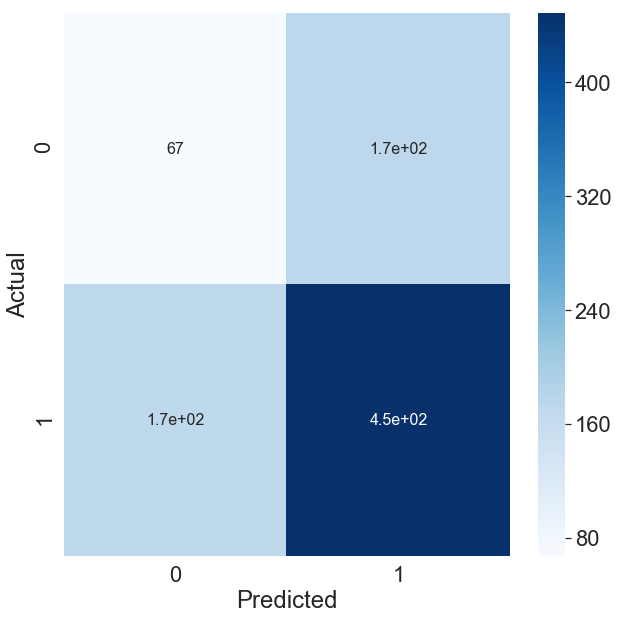

In [32]:
# Get the ground truth from generator
ground_truth = test_generator.classes
predictions = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)
predicted_classes = np.around(predictions) 
predicted_classes = predicted_classes.astype(int)
predicted_classes = predicted_classes[:,0]
errors = np.where(predicted_classes != ground_truth)[0]
print("number of errors = {}/{}".format(len(errors),test_generator.samples))
cm = confusion_matrix(ground_truth, predicted_classes)
data = confusion_matrix(ground_truth, predicted_classes)
print(cm)
df_cm = pd.DataFrame(data, columns=np.unique(ground_truth), index = np.unique(ground_truth))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,10))
sns.set(font_scale=2)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [33]:
from sklearn.metrics import classification_report
print(classification_report(ground_truth, predicted_classes))

              precision    recall  f1-score   support

           0       0.28      0.28      0.28       241
           1       0.72      0.72      0.72       621

    accuracy                           0.60       862
   macro avg       0.50      0.50      0.50       862
weighted avg       0.60      0.60      0.60       862



[[1.]]
OK


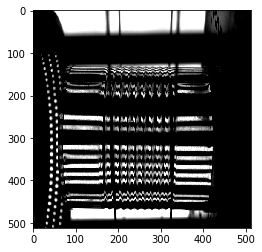

In [9]:
from keras.preprocessing import image


path='dataset/cam2/OK/imagen_2020_12_28_1348_0533.png' 
img=image.load_img(path, target_size=(512, 512))
plt.imshow(img)  
x=image.img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
  
classes = model.predict(images, batch_size=10)
  
print(classes)
if classes[0]>0.5:
    print( "OK")
    
else:
    print( " NOT OK")

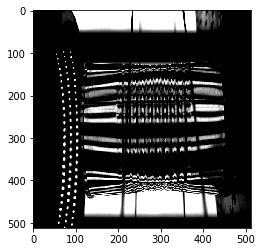

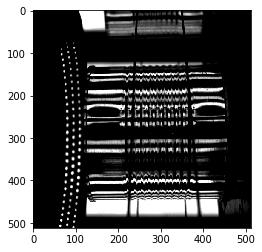

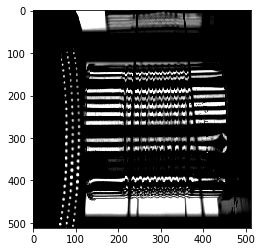

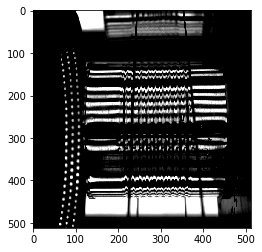

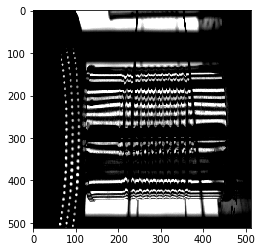

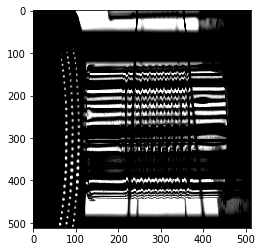

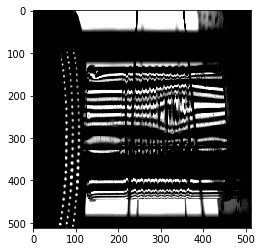

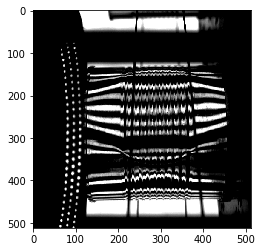

In [11]:
import PIL
from keras.preprocessing import image
import glob
%matplotlib inline

for i,filename in enumerate(glob.glob("dataset/cam1_splitted/test/OK/*.png"), 1):
    img=image.load_img(filename, target_size=(512, 512))
#     plt.figure()
   
    
    x=image.img_to_array(img)
    x=np.expand_dims(x, axis=0)
    images = np.vstack([x])
  
    classes = model.predict(images, batch_size=10)
  
    if classes[0]<0.5:
#         plt.axis('off')
#         plt.grid(b=None)
#         plt.figure(figsize=((10,10)))
# #         plt.subplot(300, 4, i+1)
        plt.imshow(img)
        plt.show()
    
    

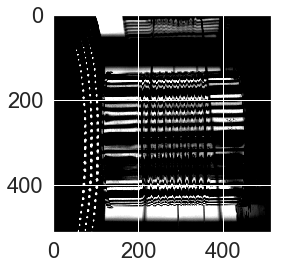

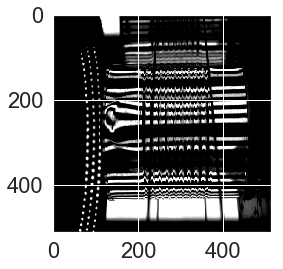

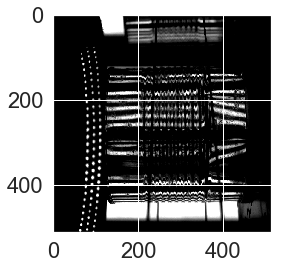

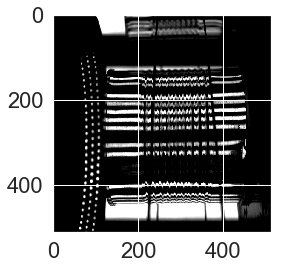

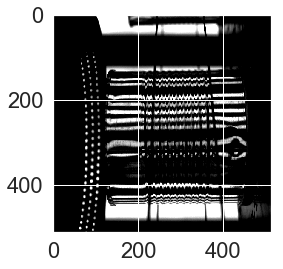

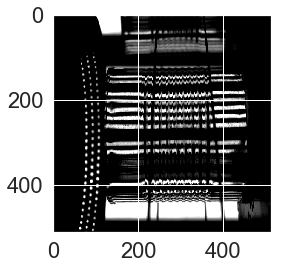

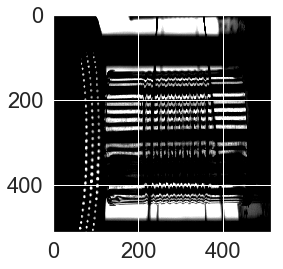

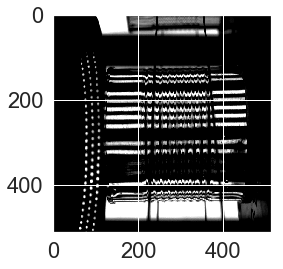

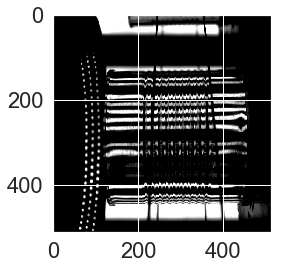

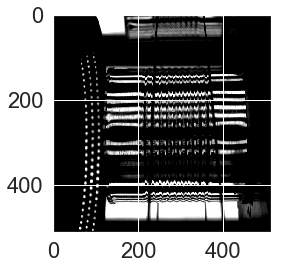

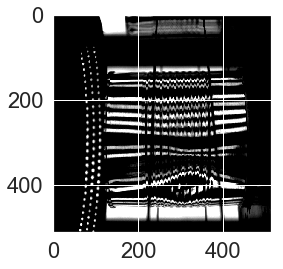

In [151]:
for i,filename in enumerate(glob.glob("dataset/cam1_splitted/test/NOT_OK/*.png")):
    img=image.load_img(filename, target_size=(512, 512))
#     plt.figure()
   
#     print(i) 
    x=image.img_to_array(img)
    x=np.expand_dims(x, axis=0)
    images = np.vstack([x])
  
    classes = model.predict(images, batch_size=10)
#     print(classes[0])
    if classes[0]>0.5:
#         plt.axis('off')
#         plt.grid(b=None)
#         plt.figure(figsize=((10,10)))
# #         plt.subplot(300, 4, i+1)
        plt.imshow(img)
        plt.show()
    

In [47]:
def plotFilters(conv_filter):
    fig, axes = plt.subplots(1, 2)
    axes = axes.flatten()
    for img, ax in zip( conv_filter, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.figure(figsize=(30,20))
    plt.show()

conv2d_3 (5, 5, 3, 32)
32


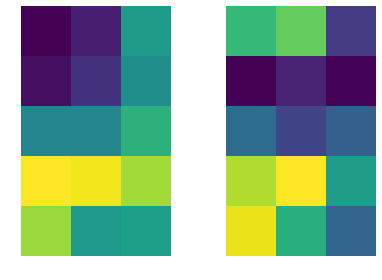

<Figure size 2160x1440 with 0 Axes>

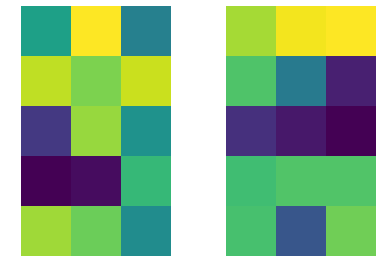

<Figure size 2160x1440 with 0 Axes>

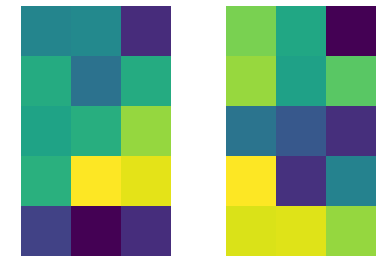

<Figure size 2160x1440 with 0 Axes>

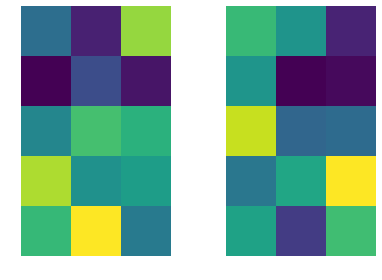

<Figure size 2160x1440 with 0 Axes>

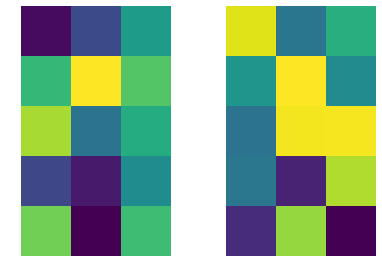

<Figure size 2160x1440 with 0 Axes>

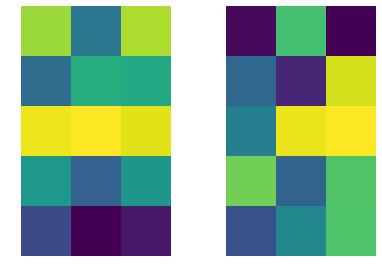

<Figure size 2160x1440 with 0 Axes>

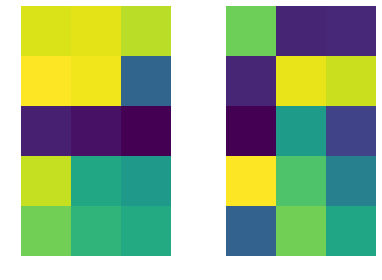

<Figure size 2160x1440 with 0 Axes>

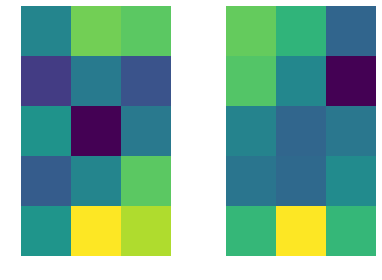

<Figure size 2160x1440 with 0 Axes>

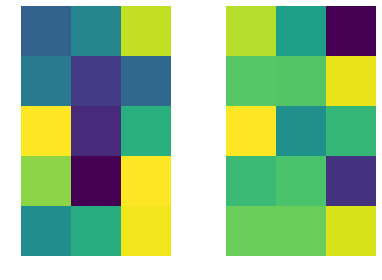

<Figure size 2160x1440 with 0 Axes>

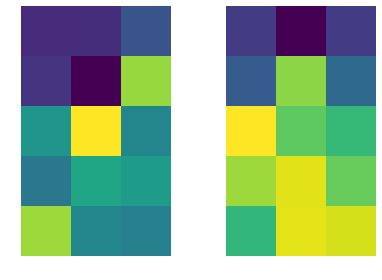

<Figure size 2160x1440 with 0 Axes>

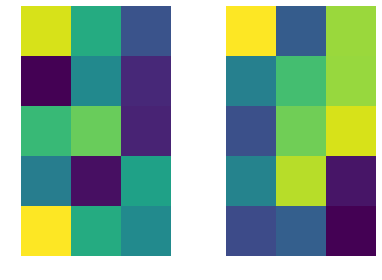

<Figure size 2160x1440 with 0 Axes>

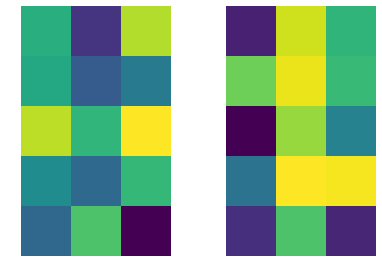

<Figure size 2160x1440 with 0 Axes>

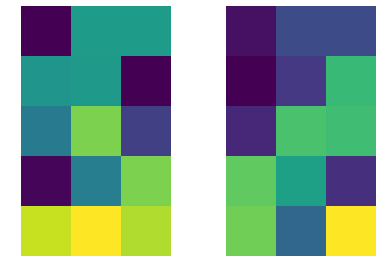

<Figure size 2160x1440 with 0 Axes>

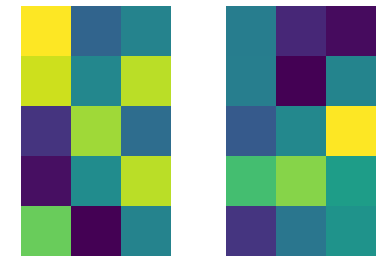

<Figure size 2160x1440 with 0 Axes>

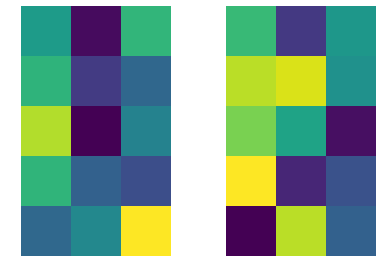

<Figure size 2160x1440 with 0 Axes>

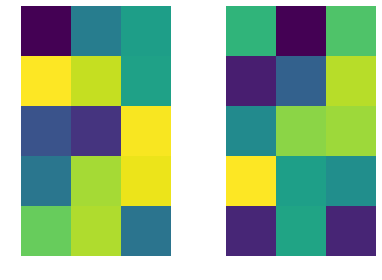

<Figure size 2160x1440 with 0 Axes>

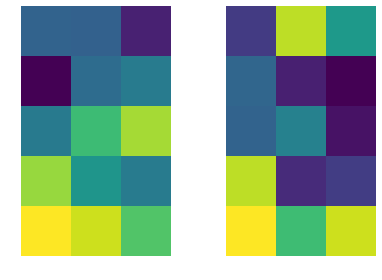

<Figure size 2160x1440 with 0 Axes>

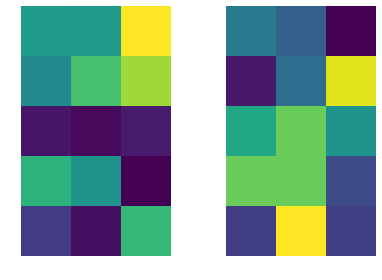

<Figure size 2160x1440 with 0 Axes>

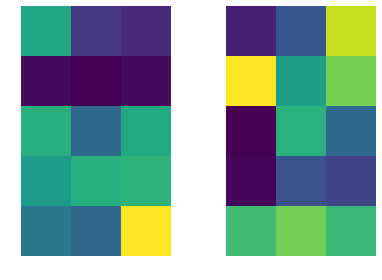

<Figure size 2160x1440 with 0 Axes>

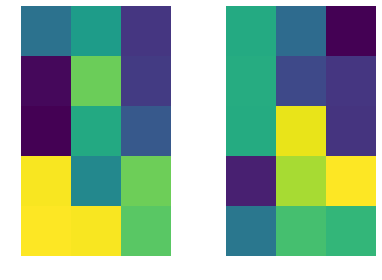

<Figure size 2160x1440 with 0 Axes>

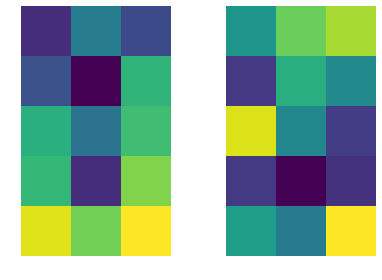

<Figure size 2160x1440 with 0 Axes>

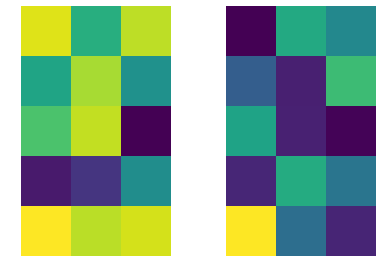

<Figure size 2160x1440 with 0 Axes>

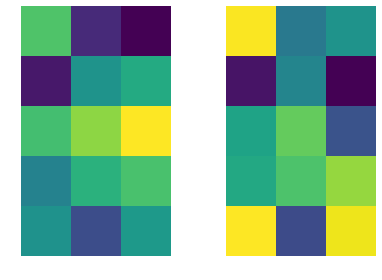

<Figure size 2160x1440 with 0 Axes>

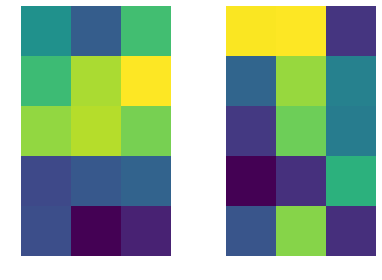

<Figure size 2160x1440 with 0 Axes>

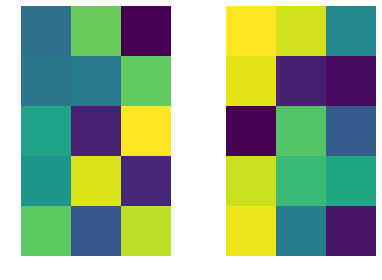

<Figure size 2160x1440 with 0 Axes>

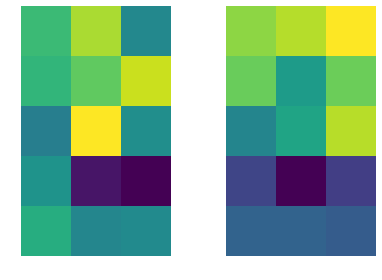

<Figure size 2160x1440 with 0 Axes>

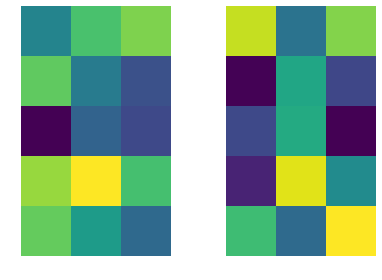

<Figure size 2160x1440 with 0 Axes>

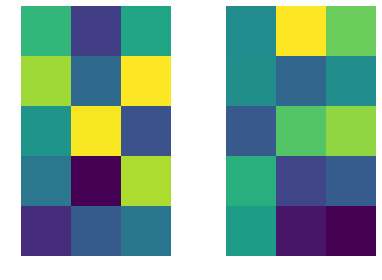

<Figure size 2160x1440 with 0 Axes>

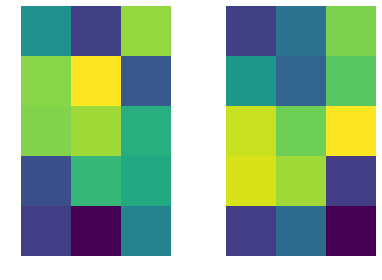

<Figure size 2160x1440 with 0 Axes>

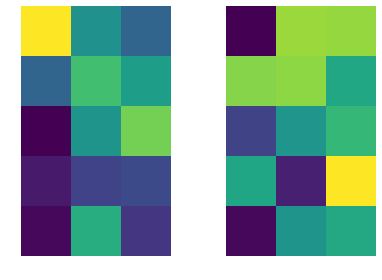

<Figure size 2160x1440 with 0 Axes>

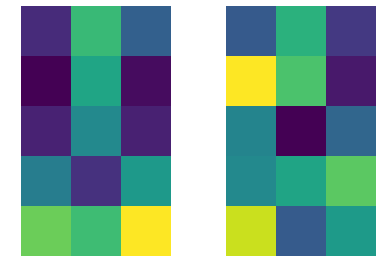

<Figure size 2160x1440 with 0 Axes>

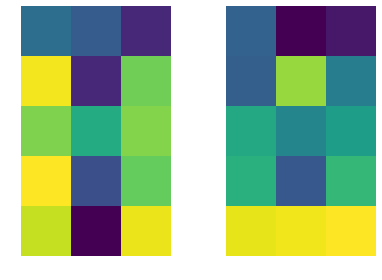

<Figure size 2160x1440 with 0 Axes>

conv2d_4 (3, 3, 32, 64)
64


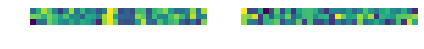

<Figure size 2160x1440 with 0 Axes>

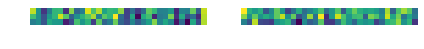

<Figure size 2160x1440 with 0 Axes>

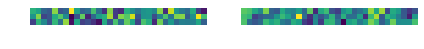

<Figure size 2160x1440 with 0 Axes>

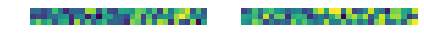

<Figure size 2160x1440 with 0 Axes>

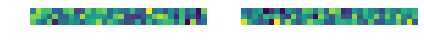

<Figure size 2160x1440 with 0 Axes>

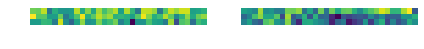

<Figure size 2160x1440 with 0 Axes>

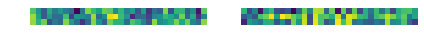

<Figure size 2160x1440 with 0 Axes>

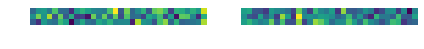

<Figure size 2160x1440 with 0 Axes>

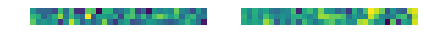

<Figure size 2160x1440 with 0 Axes>

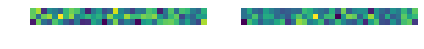

<Figure size 2160x1440 with 0 Axes>

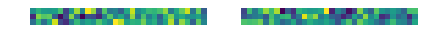

<Figure size 2160x1440 with 0 Axes>

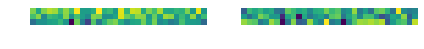

<Figure size 2160x1440 with 0 Axes>

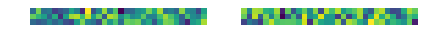

<Figure size 2160x1440 with 0 Axes>

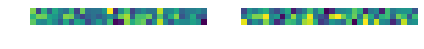

<Figure size 2160x1440 with 0 Axes>

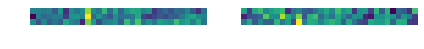

<Figure size 2160x1440 with 0 Axes>

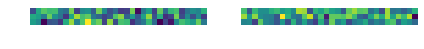

<Figure size 2160x1440 with 0 Axes>

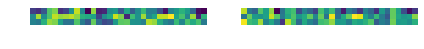

<Figure size 2160x1440 with 0 Axes>

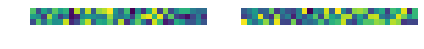

<Figure size 2160x1440 with 0 Axes>

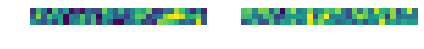

<Figure size 2160x1440 with 0 Axes>

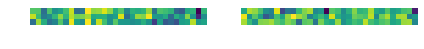

<Figure size 2160x1440 with 0 Axes>

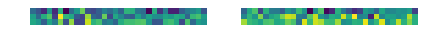

<Figure size 2160x1440 with 0 Axes>

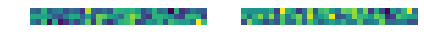

<Figure size 2160x1440 with 0 Axes>

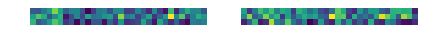

<Figure size 2160x1440 with 0 Axes>

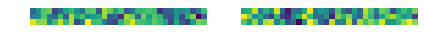

<Figure size 2160x1440 with 0 Axes>

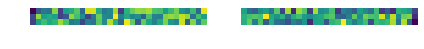

<Figure size 2160x1440 with 0 Axes>

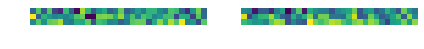

<Figure size 2160x1440 with 0 Axes>

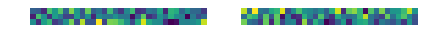

<Figure size 2160x1440 with 0 Axes>

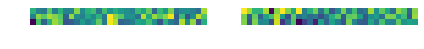

<Figure size 2160x1440 with 0 Axes>

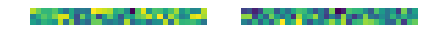

<Figure size 2160x1440 with 0 Axes>

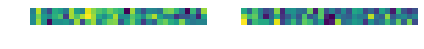

<Figure size 2160x1440 with 0 Axes>

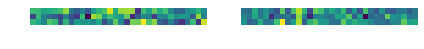

<Figure size 2160x1440 with 0 Axes>

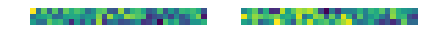

<Figure size 2160x1440 with 0 Axes>

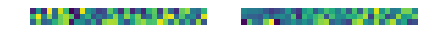

<Figure size 2160x1440 with 0 Axes>

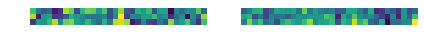

<Figure size 2160x1440 with 0 Axes>

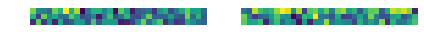

<Figure size 2160x1440 with 0 Axes>

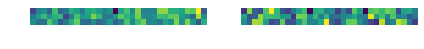

<Figure size 2160x1440 with 0 Axes>

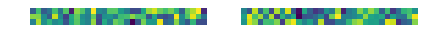

<Figure size 2160x1440 with 0 Axes>

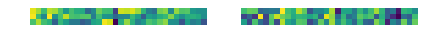

<Figure size 2160x1440 with 0 Axes>

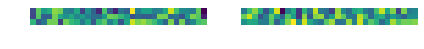

<Figure size 2160x1440 with 0 Axes>

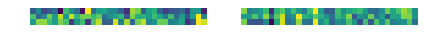

<Figure size 2160x1440 with 0 Axes>

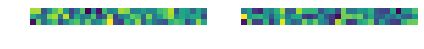

<Figure size 2160x1440 with 0 Axes>

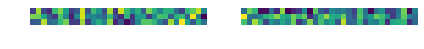

<Figure size 2160x1440 with 0 Axes>

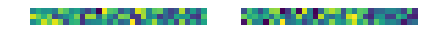

<Figure size 2160x1440 with 0 Axes>

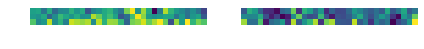

<Figure size 2160x1440 with 0 Axes>

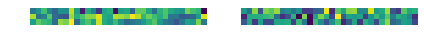

<Figure size 2160x1440 with 0 Axes>

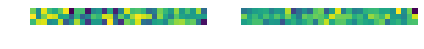

<Figure size 2160x1440 with 0 Axes>

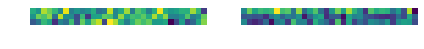

<Figure size 2160x1440 with 0 Axes>

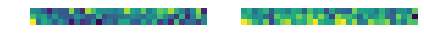

<Figure size 2160x1440 with 0 Axes>

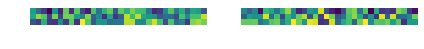

<Figure size 2160x1440 with 0 Axes>

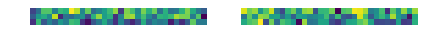

<Figure size 2160x1440 with 0 Axes>

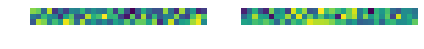

<Figure size 2160x1440 with 0 Axes>

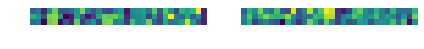

<Figure size 2160x1440 with 0 Axes>

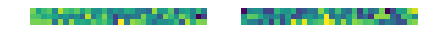

<Figure size 2160x1440 with 0 Axes>

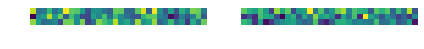

<Figure size 2160x1440 with 0 Axes>

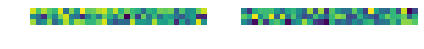

<Figure size 2160x1440 with 0 Axes>

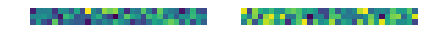

<Figure size 2160x1440 with 0 Axes>

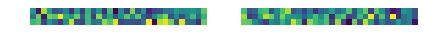

<Figure size 2160x1440 with 0 Axes>

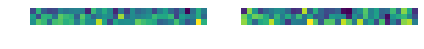

<Figure size 2160x1440 with 0 Axes>

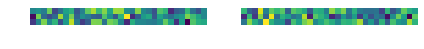

<Figure size 2160x1440 with 0 Axes>

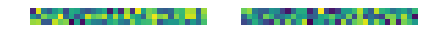

<Figure size 2160x1440 with 0 Axes>

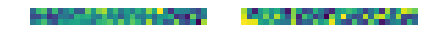

<Figure size 2160x1440 with 0 Axes>

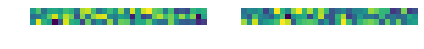

<Figure size 2160x1440 with 0 Axes>

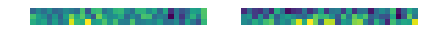

<Figure size 2160x1440 with 0 Axes>

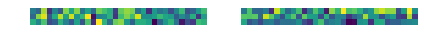

<Figure size 2160x1440 with 0 Axes>

conv2d_5 (3, 3, 64, 256)
256


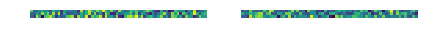

<Figure size 2160x1440 with 0 Axes>

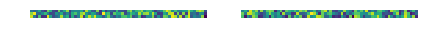

<Figure size 2160x1440 with 0 Axes>

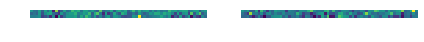

<Figure size 2160x1440 with 0 Axes>

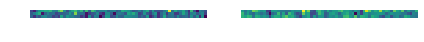

<Figure size 2160x1440 with 0 Axes>

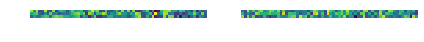

<Figure size 2160x1440 with 0 Axes>

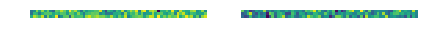

<Figure size 2160x1440 with 0 Axes>

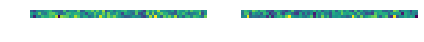

<Figure size 2160x1440 with 0 Axes>

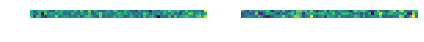

<Figure size 2160x1440 with 0 Axes>

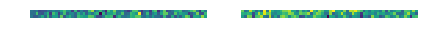

<Figure size 2160x1440 with 0 Axes>

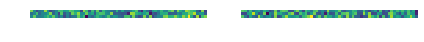

<Figure size 2160x1440 with 0 Axes>

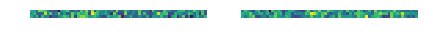

<Figure size 2160x1440 with 0 Axes>

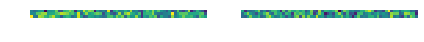

<Figure size 2160x1440 with 0 Axes>

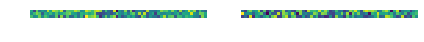

<Figure size 2160x1440 with 0 Axes>

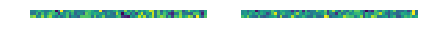

<Figure size 2160x1440 with 0 Axes>

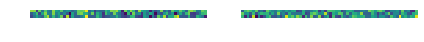

<Figure size 2160x1440 with 0 Axes>

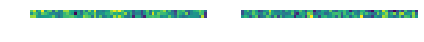

<Figure size 2160x1440 with 0 Axes>

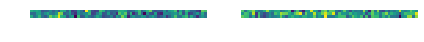

<Figure size 2160x1440 with 0 Axes>

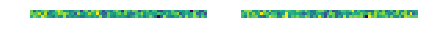

<Figure size 2160x1440 with 0 Axes>

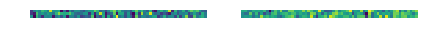

<Figure size 2160x1440 with 0 Axes>

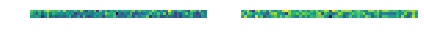

<Figure size 2160x1440 with 0 Axes>

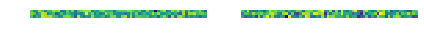

<Figure size 2160x1440 with 0 Axes>

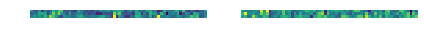

<Figure size 2160x1440 with 0 Axes>

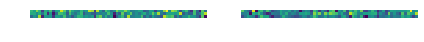

<Figure size 2160x1440 with 0 Axes>

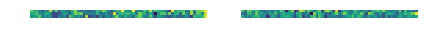

<Figure size 2160x1440 with 0 Axes>

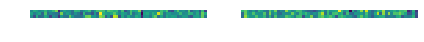

<Figure size 2160x1440 with 0 Axes>

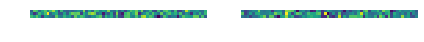

<Figure size 2160x1440 with 0 Axes>

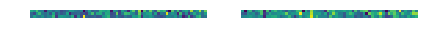

<Figure size 2160x1440 with 0 Axes>

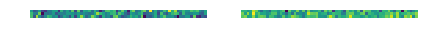

<Figure size 2160x1440 with 0 Axes>

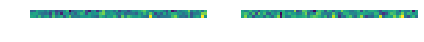

<Figure size 2160x1440 with 0 Axes>

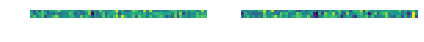

<Figure size 2160x1440 with 0 Axes>

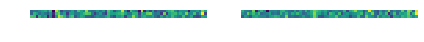

<Figure size 2160x1440 with 0 Axes>

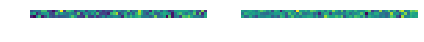

<Figure size 2160x1440 with 0 Axes>

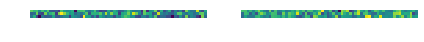

<Figure size 2160x1440 with 0 Axes>

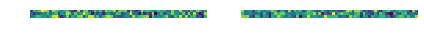

<Figure size 2160x1440 with 0 Axes>

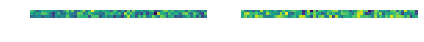

<Figure size 2160x1440 with 0 Axes>

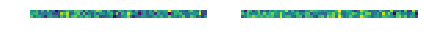

<Figure size 2160x1440 with 0 Axes>

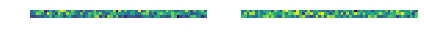

<Figure size 2160x1440 with 0 Axes>

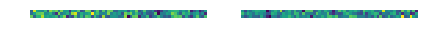

<Figure size 2160x1440 with 0 Axes>

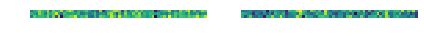

<Figure size 2160x1440 with 0 Axes>

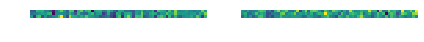

<Figure size 2160x1440 with 0 Axes>

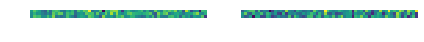

<Figure size 2160x1440 with 0 Axes>

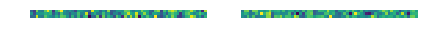

<Figure size 2160x1440 with 0 Axes>

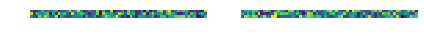

<Figure size 2160x1440 with 0 Axes>

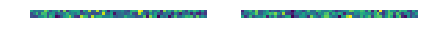

<Figure size 2160x1440 with 0 Axes>

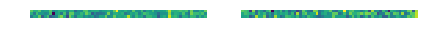

<Figure size 2160x1440 with 0 Axes>

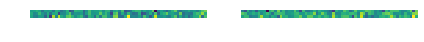

<Figure size 2160x1440 with 0 Axes>

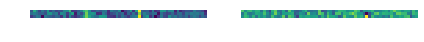

<Figure size 2160x1440 with 0 Axes>

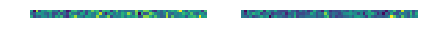

<Figure size 2160x1440 with 0 Axes>

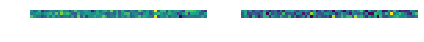

<Figure size 2160x1440 with 0 Axes>

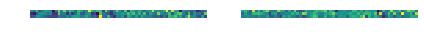

<Figure size 2160x1440 with 0 Axes>

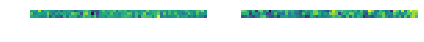

<Figure size 2160x1440 with 0 Axes>

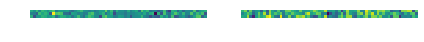

<Figure size 2160x1440 with 0 Axes>

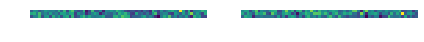

<Figure size 2160x1440 with 0 Axes>

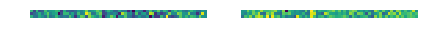

<Figure size 2160x1440 with 0 Axes>

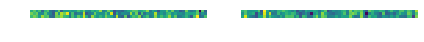

<Figure size 2160x1440 with 0 Axes>

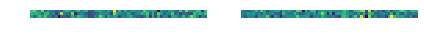

<Figure size 2160x1440 with 0 Axes>

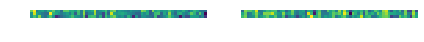

<Figure size 2160x1440 with 0 Axes>

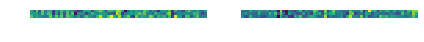

<Figure size 2160x1440 with 0 Axes>

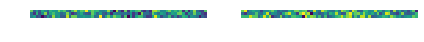

<Figure size 2160x1440 with 0 Axes>

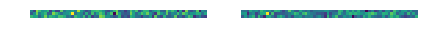

<Figure size 2160x1440 with 0 Axes>

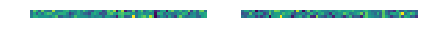

<Figure size 2160x1440 with 0 Axes>

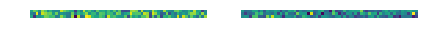

<Figure size 2160x1440 with 0 Axes>

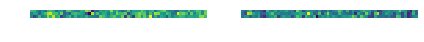

<Figure size 2160x1440 with 0 Axes>

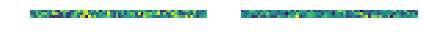

<Figure size 2160x1440 with 0 Axes>

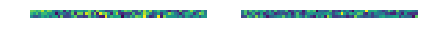

<Figure size 2160x1440 with 0 Axes>

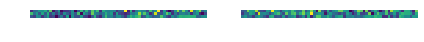

<Figure size 2160x1440 with 0 Axes>

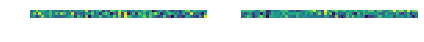

<Figure size 2160x1440 with 0 Axes>

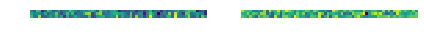

<Figure size 2160x1440 with 0 Axes>

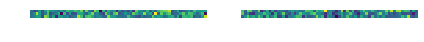

<Figure size 2160x1440 with 0 Axes>

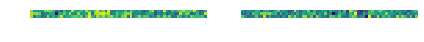

<Figure size 2160x1440 with 0 Axes>

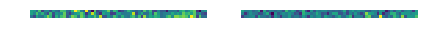

<Figure size 2160x1440 with 0 Axes>

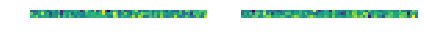

<Figure size 2160x1440 with 0 Axes>

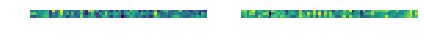

<Figure size 2160x1440 with 0 Axes>

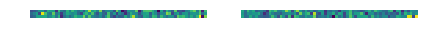

<Figure size 2160x1440 with 0 Axes>

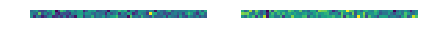

<Figure size 2160x1440 with 0 Axes>

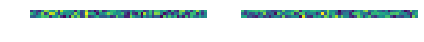

<Figure size 2160x1440 with 0 Axes>

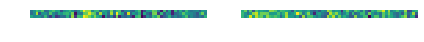

<Figure size 2160x1440 with 0 Axes>

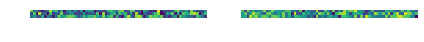

<Figure size 2160x1440 with 0 Axes>

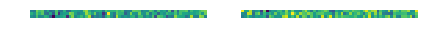

<Figure size 2160x1440 with 0 Axes>

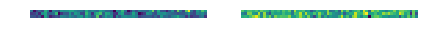

<Figure size 2160x1440 with 0 Axes>

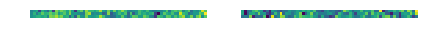

<Figure size 2160x1440 with 0 Axes>

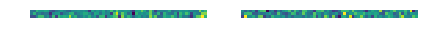

<Figure size 2160x1440 with 0 Axes>

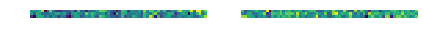

<Figure size 2160x1440 with 0 Axes>

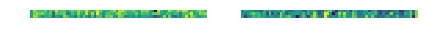

<Figure size 2160x1440 with 0 Axes>

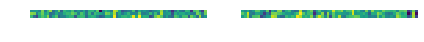

<Figure size 2160x1440 with 0 Axes>

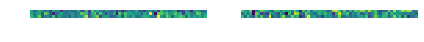

<Figure size 2160x1440 with 0 Axes>

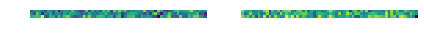

<Figure size 2160x1440 with 0 Axes>

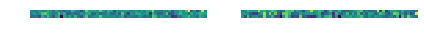

<Figure size 2160x1440 with 0 Axes>

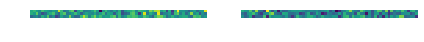

<Figure size 2160x1440 with 0 Axes>

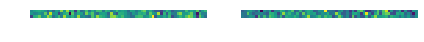

<Figure size 2160x1440 with 0 Axes>

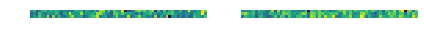

<Figure size 2160x1440 with 0 Axes>

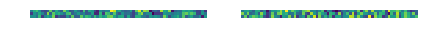

<Figure size 2160x1440 with 0 Axes>

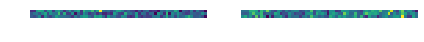

<Figure size 2160x1440 with 0 Axes>

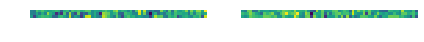

<Figure size 2160x1440 with 0 Axes>

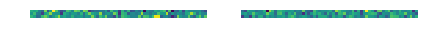

<Figure size 2160x1440 with 0 Axes>

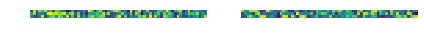

<Figure size 2160x1440 with 0 Axes>

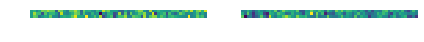

<Figure size 2160x1440 with 0 Axes>

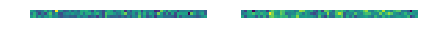

<Figure size 2160x1440 with 0 Axes>

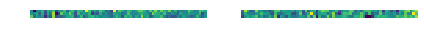

<Figure size 2160x1440 with 0 Axes>

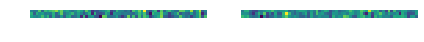

<Figure size 2160x1440 with 0 Axes>

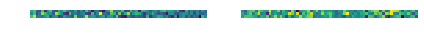

<Figure size 2160x1440 with 0 Axes>

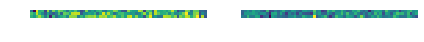

<Figure size 2160x1440 with 0 Axes>

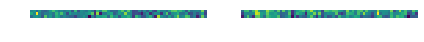

<Figure size 2160x1440 with 0 Axes>

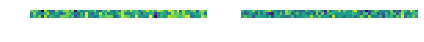

<Figure size 2160x1440 with 0 Axes>

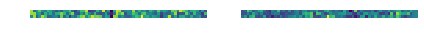

<Figure size 2160x1440 with 0 Axes>

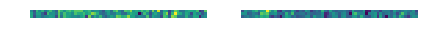

<Figure size 2160x1440 with 0 Axes>

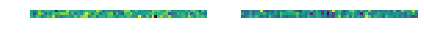

<Figure size 2160x1440 with 0 Axes>

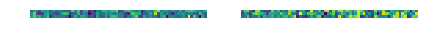

<Figure size 2160x1440 with 0 Axes>

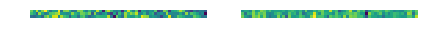

<Figure size 2160x1440 with 0 Axes>

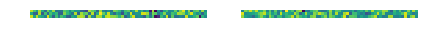

<Figure size 2160x1440 with 0 Axes>

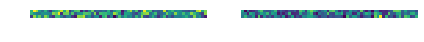

<Figure size 2160x1440 with 0 Axes>

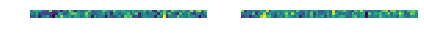

<Figure size 2160x1440 with 0 Axes>

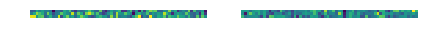

<Figure size 2160x1440 with 0 Axes>

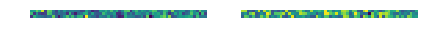

<Figure size 2160x1440 with 0 Axes>

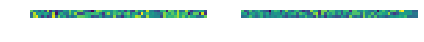

<Figure size 2160x1440 with 0 Axes>

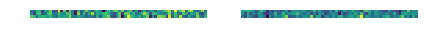

<Figure size 2160x1440 with 0 Axes>

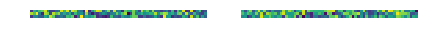

<Figure size 2160x1440 with 0 Axes>

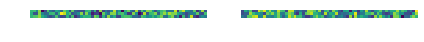

<Figure size 2160x1440 with 0 Axes>

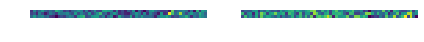

<Figure size 2160x1440 with 0 Axes>

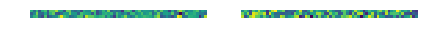

<Figure size 2160x1440 with 0 Axes>

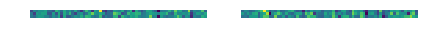

<Figure size 2160x1440 with 0 Axes>

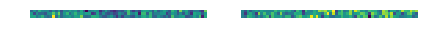

<Figure size 2160x1440 with 0 Axes>

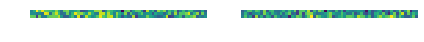

<Figure size 2160x1440 with 0 Axes>

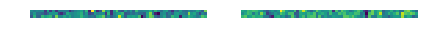

<Figure size 2160x1440 with 0 Axes>

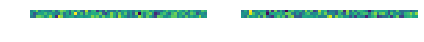

<Figure size 2160x1440 with 0 Axes>

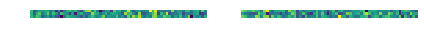

<Figure size 2160x1440 with 0 Axes>

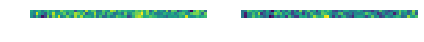

<Figure size 2160x1440 with 0 Axes>

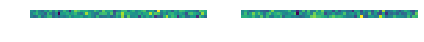

<Figure size 2160x1440 with 0 Axes>

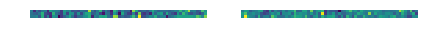

<Figure size 2160x1440 with 0 Axes>

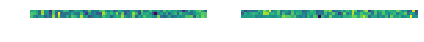

<Figure size 2160x1440 with 0 Axes>

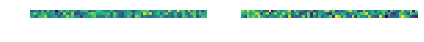

<Figure size 2160x1440 with 0 Axes>

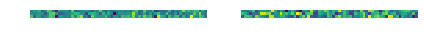

<Figure size 2160x1440 with 0 Axes>

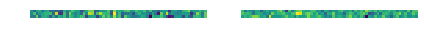

<Figure size 2160x1440 with 0 Axes>

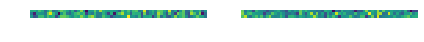

<Figure size 2160x1440 with 0 Axes>

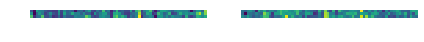

<Figure size 2160x1440 with 0 Axes>

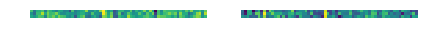

<Figure size 2160x1440 with 0 Axes>

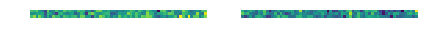

<Figure size 2160x1440 with 0 Axes>

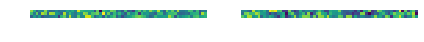

<Figure size 2160x1440 with 0 Axes>

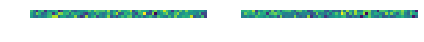

<Figure size 2160x1440 with 0 Axes>

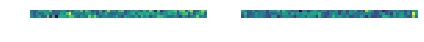

<Figure size 2160x1440 with 0 Axes>

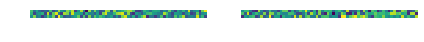

<Figure size 2160x1440 with 0 Axes>

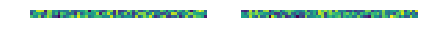

<Figure size 2160x1440 with 0 Axes>

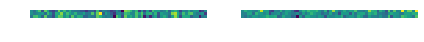

<Figure size 2160x1440 with 0 Axes>

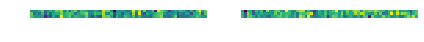

<Figure size 2160x1440 with 0 Axes>

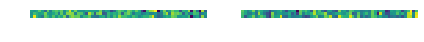

<Figure size 2160x1440 with 0 Axes>

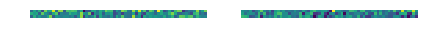

<Figure size 2160x1440 with 0 Axes>

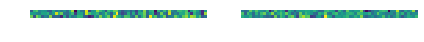

<Figure size 2160x1440 with 0 Axes>

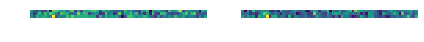

<Figure size 2160x1440 with 0 Axes>

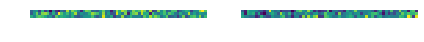

<Figure size 2160x1440 with 0 Axes>

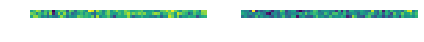

<Figure size 2160x1440 with 0 Axes>

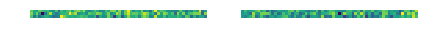

<Figure size 2160x1440 with 0 Axes>

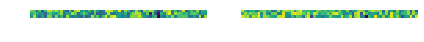

<Figure size 2160x1440 with 0 Axes>

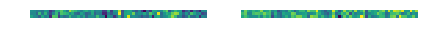

<Figure size 2160x1440 with 0 Axes>

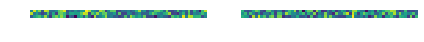

<Figure size 2160x1440 with 0 Axes>

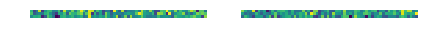

<Figure size 2160x1440 with 0 Axes>

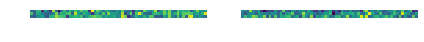

<Figure size 2160x1440 with 0 Axes>

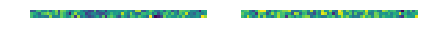

<Figure size 2160x1440 with 0 Axes>

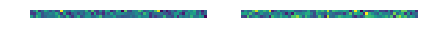

<Figure size 2160x1440 with 0 Axes>

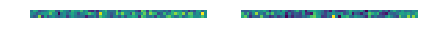

<Figure size 2160x1440 with 0 Axes>

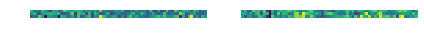

<Figure size 2160x1440 with 0 Axes>

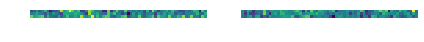

<Figure size 2160x1440 with 0 Axes>

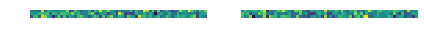

<Figure size 2160x1440 with 0 Axes>

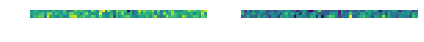

<Figure size 2160x1440 with 0 Axes>

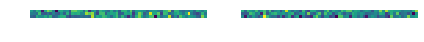

<Figure size 2160x1440 with 0 Axes>

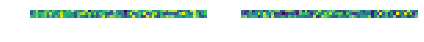

<Figure size 2160x1440 with 0 Axes>

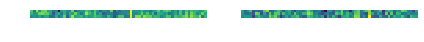

<Figure size 2160x1440 with 0 Axes>

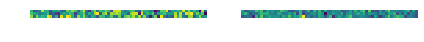

<Figure size 2160x1440 with 0 Axes>

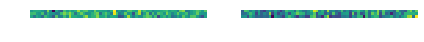

<Figure size 2160x1440 with 0 Axes>

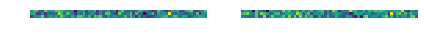

<Figure size 2160x1440 with 0 Axes>

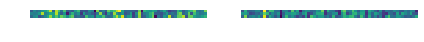

<Figure size 2160x1440 with 0 Axes>

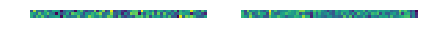

<Figure size 2160x1440 with 0 Axes>

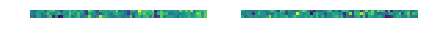

<Figure size 2160x1440 with 0 Axes>

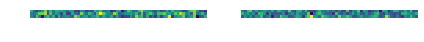

<Figure size 2160x1440 with 0 Axes>

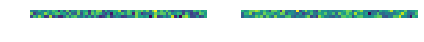

<Figure size 2160x1440 with 0 Axes>

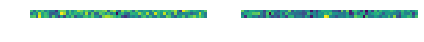

<Figure size 2160x1440 with 0 Axes>

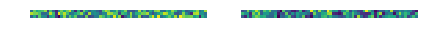

<Figure size 2160x1440 with 0 Axes>

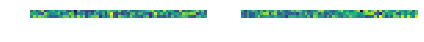

<Figure size 2160x1440 with 0 Axes>

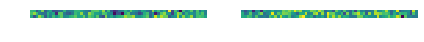

<Figure size 2160x1440 with 0 Axes>

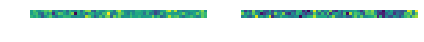

<Figure size 2160x1440 with 0 Axes>

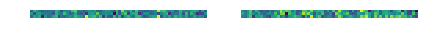

<Figure size 2160x1440 with 0 Axes>

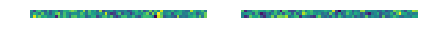

<Figure size 2160x1440 with 0 Axes>

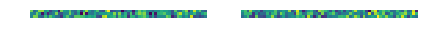

<Figure size 2160x1440 with 0 Axes>

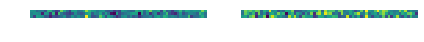

<Figure size 2160x1440 with 0 Axes>

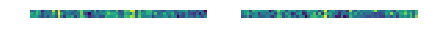

<Figure size 2160x1440 with 0 Axes>

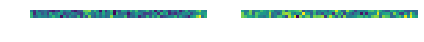

<Figure size 2160x1440 with 0 Axes>

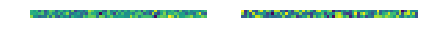

<Figure size 2160x1440 with 0 Axes>

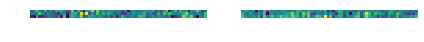

<Figure size 2160x1440 with 0 Axes>

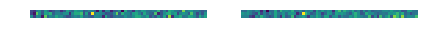

<Figure size 2160x1440 with 0 Axes>

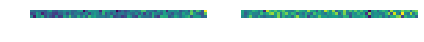

<Figure size 2160x1440 with 0 Axes>

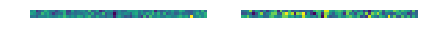

<Figure size 2160x1440 with 0 Axes>

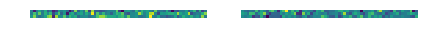

<Figure size 2160x1440 with 0 Axes>

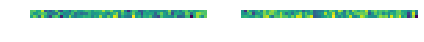

<Figure size 2160x1440 with 0 Axes>

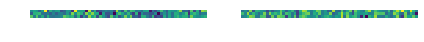

<Figure size 2160x1440 with 0 Axes>

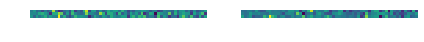

<Figure size 2160x1440 with 0 Axes>

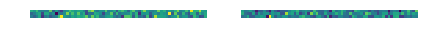

<Figure size 2160x1440 with 0 Axes>

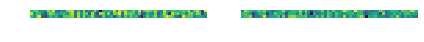

<Figure size 2160x1440 with 0 Axes>

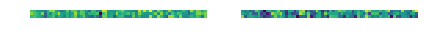

<Figure size 2160x1440 with 0 Axes>

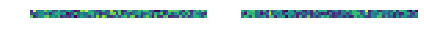

<Figure size 2160x1440 with 0 Axes>

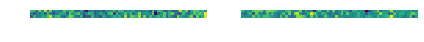

<Figure size 2160x1440 with 0 Axes>

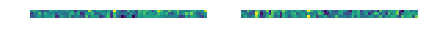

<Figure size 2160x1440 with 0 Axes>

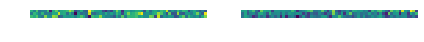

<Figure size 2160x1440 with 0 Axes>

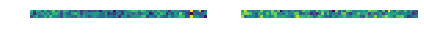

<Figure size 2160x1440 with 0 Axes>

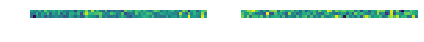

<Figure size 2160x1440 with 0 Axes>

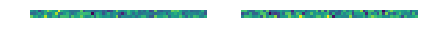

<Figure size 2160x1440 with 0 Axes>

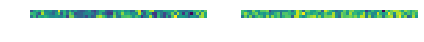

<Figure size 2160x1440 with 0 Axes>

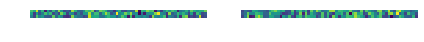

<Figure size 2160x1440 with 0 Axes>

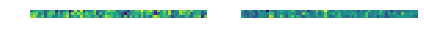

<Figure size 2160x1440 with 0 Axes>

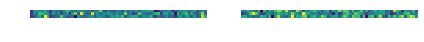

<Figure size 2160x1440 with 0 Axes>

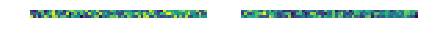

<Figure size 2160x1440 with 0 Axes>

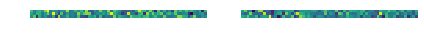

<Figure size 2160x1440 with 0 Axes>

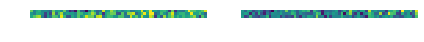

<Figure size 2160x1440 with 0 Axes>

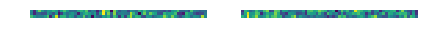

<Figure size 2160x1440 with 0 Axes>

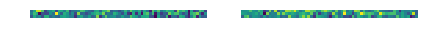

<Figure size 2160x1440 with 0 Axes>

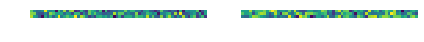

<Figure size 2160x1440 with 0 Axes>

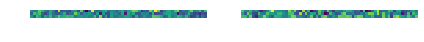

<Figure size 2160x1440 with 0 Axes>

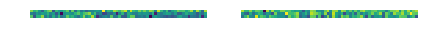

<Figure size 2160x1440 with 0 Axes>

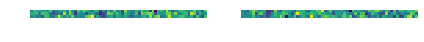

<Figure size 2160x1440 with 0 Axes>

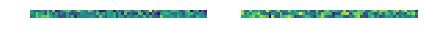

<Figure size 2160x1440 with 0 Axes>

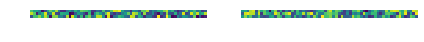

<Figure size 2160x1440 with 0 Axes>

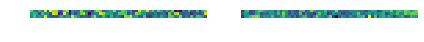

<Figure size 2160x1440 with 0 Axes>

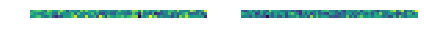

<Figure size 2160x1440 with 0 Axes>

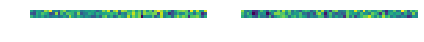

<Figure size 2160x1440 with 0 Axes>

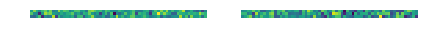

<Figure size 2160x1440 with 0 Axes>

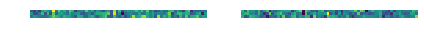

<Figure size 2160x1440 with 0 Axes>

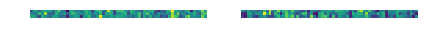

<Figure size 2160x1440 with 0 Axes>

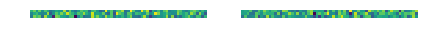

<Figure size 2160x1440 with 0 Axes>

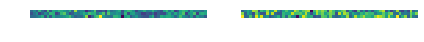

<Figure size 2160x1440 with 0 Axes>

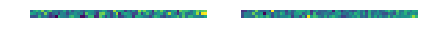

<Figure size 2160x1440 with 0 Axes>

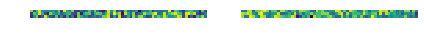

<Figure size 2160x1440 with 0 Axes>

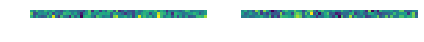

<Figure size 2160x1440 with 0 Axes>

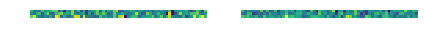

<Figure size 2160x1440 with 0 Axes>

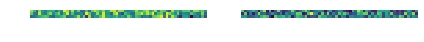

<Figure size 2160x1440 with 0 Axes>

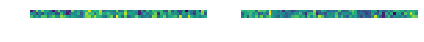

<Figure size 2160x1440 with 0 Axes>

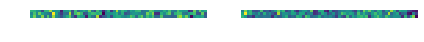

<Figure size 2160x1440 with 0 Axes>

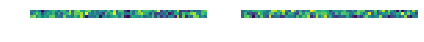

<Figure size 2160x1440 with 0 Axes>

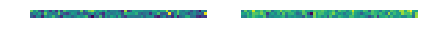

<Figure size 2160x1440 with 0 Axes>

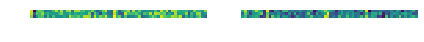

<Figure size 2160x1440 with 0 Axes>

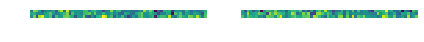

<Figure size 2160x1440 with 0 Axes>

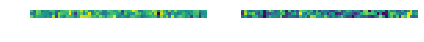

<Figure size 2160x1440 with 0 Axes>

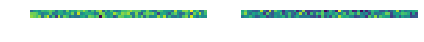

<Figure size 2160x1440 with 0 Axes>

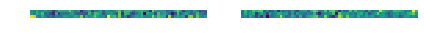

<Figure size 2160x1440 with 0 Axes>

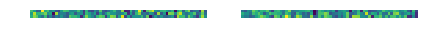

<Figure size 2160x1440 with 0 Axes>

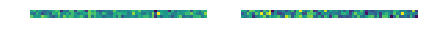

<Figure size 2160x1440 with 0 Axes>

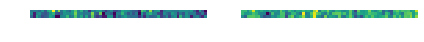

<Figure size 2160x1440 with 0 Axes>

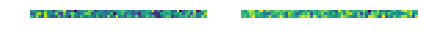

<Figure size 2160x1440 with 0 Axes>

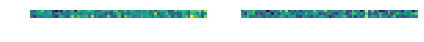

<Figure size 2160x1440 with 0 Axes>

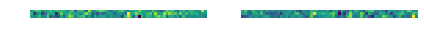

<Figure size 2160x1440 with 0 Axes>

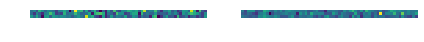

<Figure size 2160x1440 with 0 Axes>

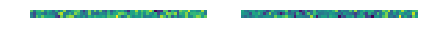

<Figure size 2160x1440 with 0 Axes>

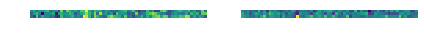

<Figure size 2160x1440 with 0 Axes>

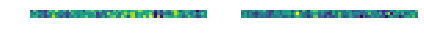

<Figure size 2160x1440 with 0 Axes>

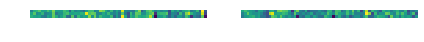

<Figure size 2160x1440 with 0 Axes>

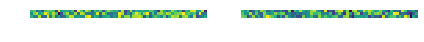

<Figure size 2160x1440 with 0 Axes>

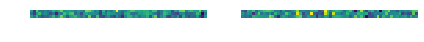

<Figure size 2160x1440 with 0 Axes>

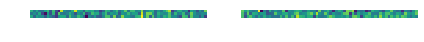

<Figure size 2160x1440 with 0 Axes>

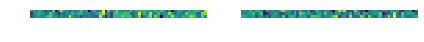

<Figure size 2160x1440 with 0 Axes>

conv2d_6 (3, 3, 256, 256)
256


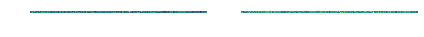

<Figure size 2160x1440 with 0 Axes>

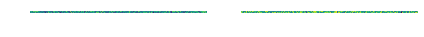

<Figure size 2160x1440 with 0 Axes>

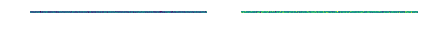

<Figure size 2160x1440 with 0 Axes>

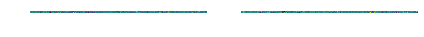

<Figure size 2160x1440 with 0 Axes>

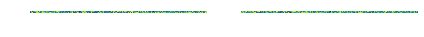

<Figure size 2160x1440 with 0 Axes>

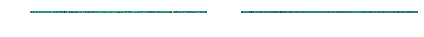

<Figure size 2160x1440 with 0 Axes>

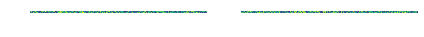

<Figure size 2160x1440 with 0 Axes>

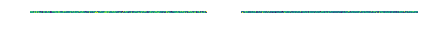

<Figure size 2160x1440 with 0 Axes>

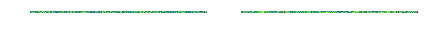

<Figure size 2160x1440 with 0 Axes>

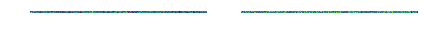

<Figure size 2160x1440 with 0 Axes>

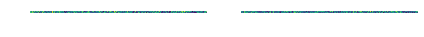

<Figure size 2160x1440 with 0 Axes>

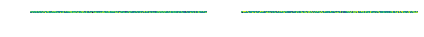

<Figure size 2160x1440 with 0 Axes>

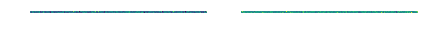

<Figure size 2160x1440 with 0 Axes>

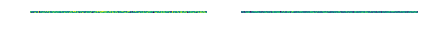

<Figure size 2160x1440 with 0 Axes>

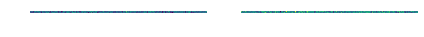

<Figure size 2160x1440 with 0 Axes>

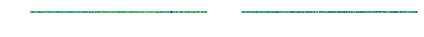

<Figure size 2160x1440 with 0 Axes>

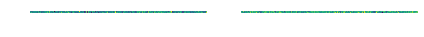

<Figure size 2160x1440 with 0 Axes>

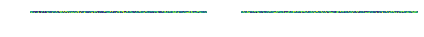

<Figure size 2160x1440 with 0 Axes>

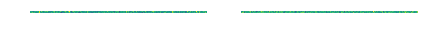

<Figure size 2160x1440 with 0 Axes>

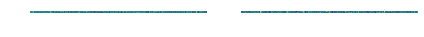

<Figure size 2160x1440 with 0 Axes>

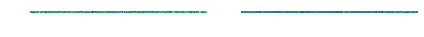

<Figure size 2160x1440 with 0 Axes>

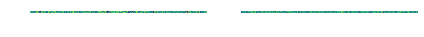

<Figure size 2160x1440 with 0 Axes>

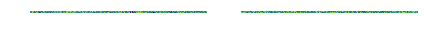

<Figure size 2160x1440 with 0 Axes>

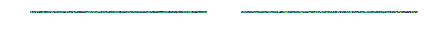

<Figure size 2160x1440 with 0 Axes>

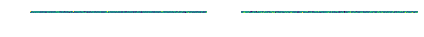

<Figure size 2160x1440 with 0 Axes>

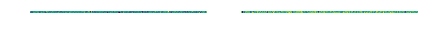

<Figure size 2160x1440 with 0 Axes>

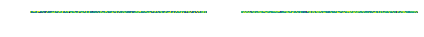

<Figure size 2160x1440 with 0 Axes>

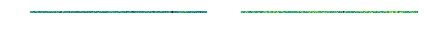

<Figure size 2160x1440 with 0 Axes>

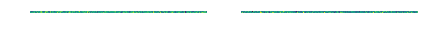

<Figure size 2160x1440 with 0 Axes>

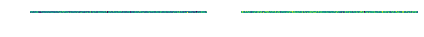

<Figure size 2160x1440 with 0 Axes>

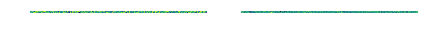

<Figure size 2160x1440 with 0 Axes>

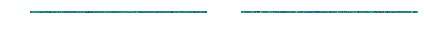

<Figure size 2160x1440 with 0 Axes>

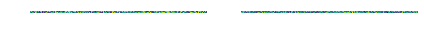

<Figure size 2160x1440 with 0 Axes>

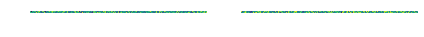

<Figure size 2160x1440 with 0 Axes>

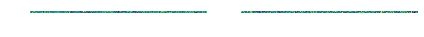

<Figure size 2160x1440 with 0 Axes>

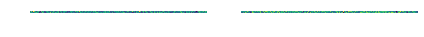

<Figure size 2160x1440 with 0 Axes>

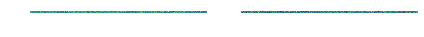

<Figure size 2160x1440 with 0 Axes>

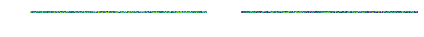

<Figure size 2160x1440 with 0 Axes>

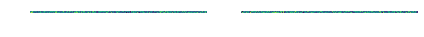

<Figure size 2160x1440 with 0 Axes>

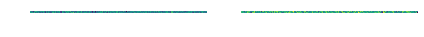

<Figure size 2160x1440 with 0 Axes>

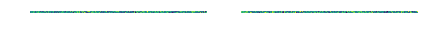

<Figure size 2160x1440 with 0 Axes>

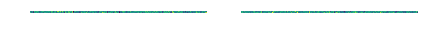

<Figure size 2160x1440 with 0 Axes>

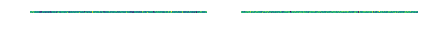

<Figure size 2160x1440 with 0 Axes>

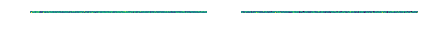

<Figure size 2160x1440 with 0 Axes>

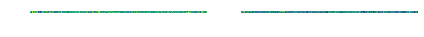

<Figure size 2160x1440 with 0 Axes>

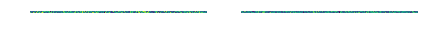

<Figure size 2160x1440 with 0 Axes>

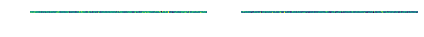

<Figure size 2160x1440 with 0 Axes>

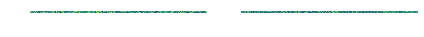

<Figure size 2160x1440 with 0 Axes>

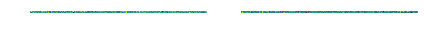

<Figure size 2160x1440 with 0 Axes>

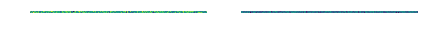

<Figure size 2160x1440 with 0 Axes>

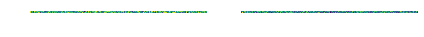

<Figure size 2160x1440 with 0 Axes>

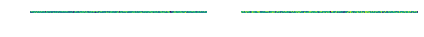

<Figure size 2160x1440 with 0 Axes>

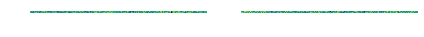

<Figure size 2160x1440 with 0 Axes>

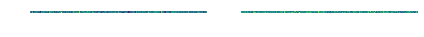

<Figure size 2160x1440 with 0 Axes>

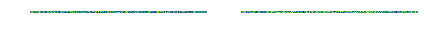

<Figure size 2160x1440 with 0 Axes>

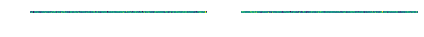

<Figure size 2160x1440 with 0 Axes>

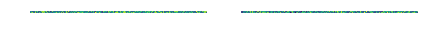

<Figure size 2160x1440 with 0 Axes>

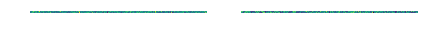

<Figure size 2160x1440 with 0 Axes>

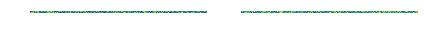

<Figure size 2160x1440 with 0 Axes>

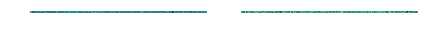

<Figure size 2160x1440 with 0 Axes>

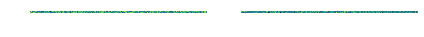

<Figure size 2160x1440 with 0 Axes>

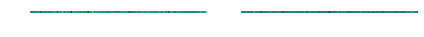

<Figure size 2160x1440 with 0 Axes>

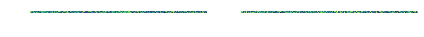

<Figure size 2160x1440 with 0 Axes>

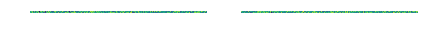

<Figure size 2160x1440 with 0 Axes>

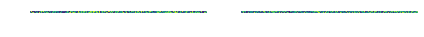

<Figure size 2160x1440 with 0 Axes>

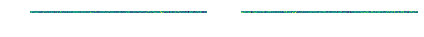

<Figure size 2160x1440 with 0 Axes>

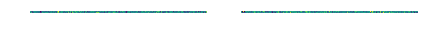

<Figure size 2160x1440 with 0 Axes>

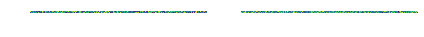

<Figure size 2160x1440 with 0 Axes>

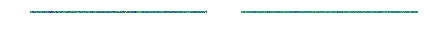

<Figure size 2160x1440 with 0 Axes>

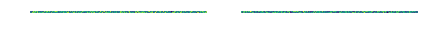

<Figure size 2160x1440 with 0 Axes>

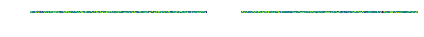

<Figure size 2160x1440 with 0 Axes>

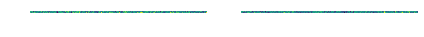

<Figure size 2160x1440 with 0 Axes>

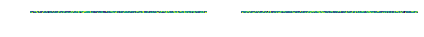

<Figure size 2160x1440 with 0 Axes>

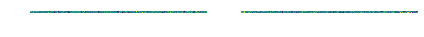

<Figure size 2160x1440 with 0 Axes>

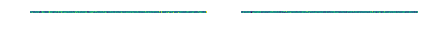

<Figure size 2160x1440 with 0 Axes>

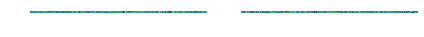

<Figure size 2160x1440 with 0 Axes>

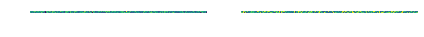

<Figure size 2160x1440 with 0 Axes>

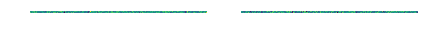

<Figure size 2160x1440 with 0 Axes>

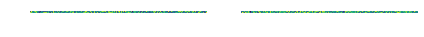

<Figure size 2160x1440 with 0 Axes>

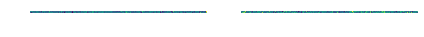

<Figure size 2160x1440 with 0 Axes>

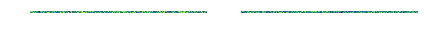

<Figure size 2160x1440 with 0 Axes>

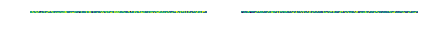

<Figure size 2160x1440 with 0 Axes>

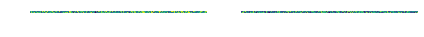

<Figure size 2160x1440 with 0 Axes>

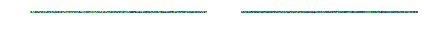

<Figure size 2160x1440 with 0 Axes>

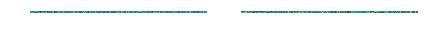

<Figure size 2160x1440 with 0 Axes>

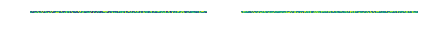

<Figure size 2160x1440 with 0 Axes>

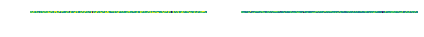

<Figure size 2160x1440 with 0 Axes>

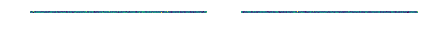

<Figure size 2160x1440 with 0 Axes>

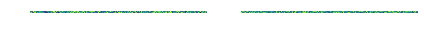

<Figure size 2160x1440 with 0 Axes>

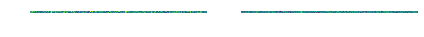

<Figure size 2160x1440 with 0 Axes>

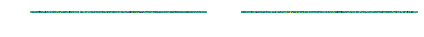

<Figure size 2160x1440 with 0 Axes>

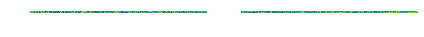

<Figure size 2160x1440 with 0 Axes>

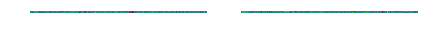

<Figure size 2160x1440 with 0 Axes>

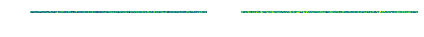

<Figure size 2160x1440 with 0 Axes>

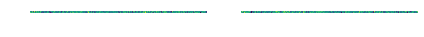

<Figure size 2160x1440 with 0 Axes>

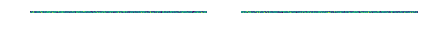

<Figure size 2160x1440 with 0 Axes>

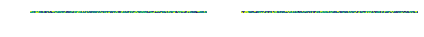

<Figure size 2160x1440 with 0 Axes>

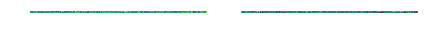

<Figure size 2160x1440 with 0 Axes>

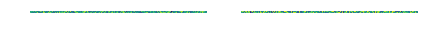

<Figure size 2160x1440 with 0 Axes>

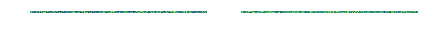

<Figure size 2160x1440 with 0 Axes>

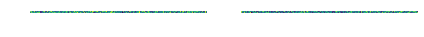

<Figure size 2160x1440 with 0 Axes>

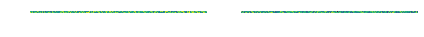

<Figure size 2160x1440 with 0 Axes>

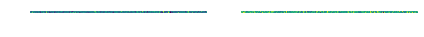

<Figure size 2160x1440 with 0 Axes>

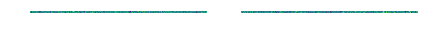

<Figure size 2160x1440 with 0 Axes>

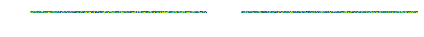

<Figure size 2160x1440 with 0 Axes>

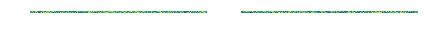

<Figure size 2160x1440 with 0 Axes>

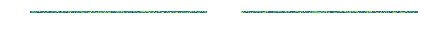

<Figure size 2160x1440 with 0 Axes>

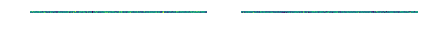

<Figure size 2160x1440 with 0 Axes>

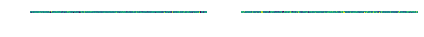

<Figure size 2160x1440 with 0 Axes>

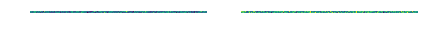

<Figure size 2160x1440 with 0 Axes>

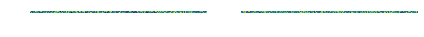

<Figure size 2160x1440 with 0 Axes>

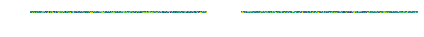

<Figure size 2160x1440 with 0 Axes>

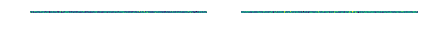

<Figure size 2160x1440 with 0 Axes>

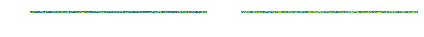

<Figure size 2160x1440 with 0 Axes>

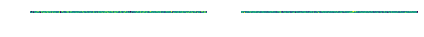

<Figure size 2160x1440 with 0 Axes>

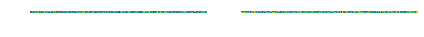

<Figure size 2160x1440 with 0 Axes>

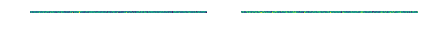

<Figure size 2160x1440 with 0 Axes>

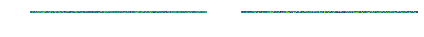

<Figure size 2160x1440 with 0 Axes>

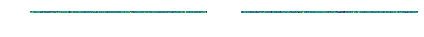

<Figure size 2160x1440 with 0 Axes>

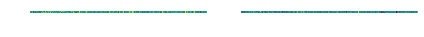

<Figure size 2160x1440 with 0 Axes>

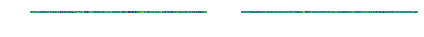

<Figure size 2160x1440 with 0 Axes>

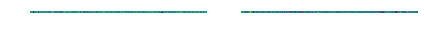

<Figure size 2160x1440 with 0 Axes>

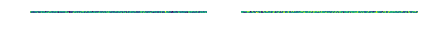

<Figure size 2160x1440 with 0 Axes>

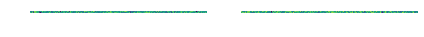

<Figure size 2160x1440 with 0 Axes>

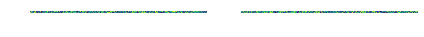

<Figure size 2160x1440 with 0 Axes>

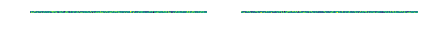

<Figure size 2160x1440 with 0 Axes>

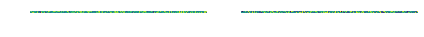

<Figure size 2160x1440 with 0 Axes>

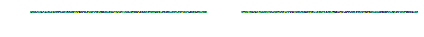

<Figure size 2160x1440 with 0 Axes>

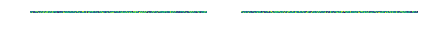

<Figure size 2160x1440 with 0 Axes>

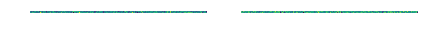

<Figure size 2160x1440 with 0 Axes>

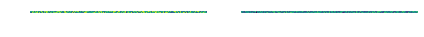

<Figure size 2160x1440 with 0 Axes>

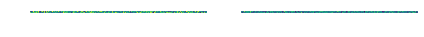

<Figure size 2160x1440 with 0 Axes>

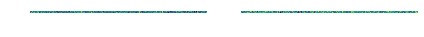

<Figure size 2160x1440 with 0 Axes>

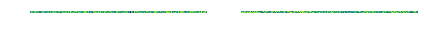

<Figure size 2160x1440 with 0 Axes>

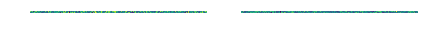

<Figure size 2160x1440 with 0 Axes>

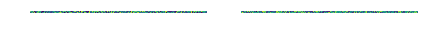

<Figure size 2160x1440 with 0 Axes>

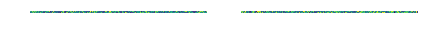

<Figure size 2160x1440 with 0 Axes>

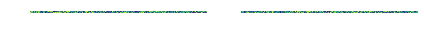

<Figure size 2160x1440 with 0 Axes>

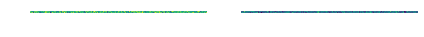

<Figure size 2160x1440 with 0 Axes>

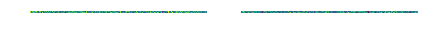

<Figure size 2160x1440 with 0 Axes>

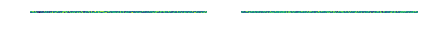

<Figure size 2160x1440 with 0 Axes>

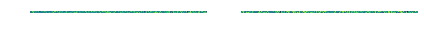

<Figure size 2160x1440 with 0 Axes>

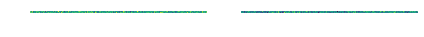

<Figure size 2160x1440 with 0 Axes>

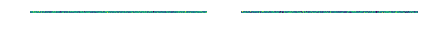

<Figure size 2160x1440 with 0 Axes>

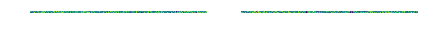

<Figure size 2160x1440 with 0 Axes>

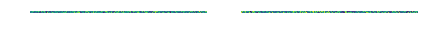

<Figure size 2160x1440 with 0 Axes>

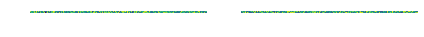

<Figure size 2160x1440 with 0 Axes>

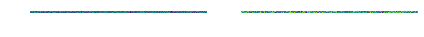

<Figure size 2160x1440 with 0 Axes>

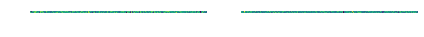

<Figure size 2160x1440 with 0 Axes>

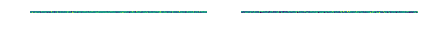

<Figure size 2160x1440 with 0 Axes>

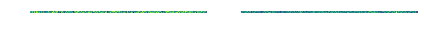

<Figure size 2160x1440 with 0 Axes>

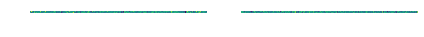

<Figure size 2160x1440 with 0 Axes>

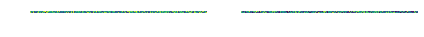

<Figure size 2160x1440 with 0 Axes>

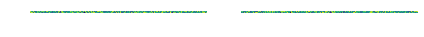

<Figure size 2160x1440 with 0 Axes>

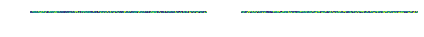

<Figure size 2160x1440 with 0 Axes>

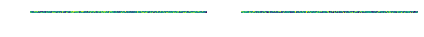

<Figure size 2160x1440 with 0 Axes>

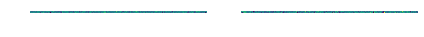

<Figure size 2160x1440 with 0 Axes>

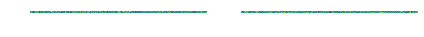

<Figure size 2160x1440 with 0 Axes>

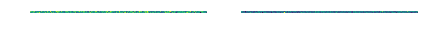

<Figure size 2160x1440 with 0 Axes>

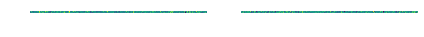

<Figure size 2160x1440 with 0 Axes>

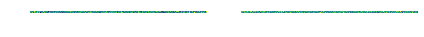

<Figure size 2160x1440 with 0 Axes>

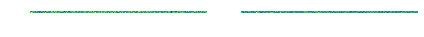

<Figure size 2160x1440 with 0 Axes>

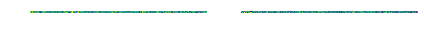

<Figure size 2160x1440 with 0 Axes>

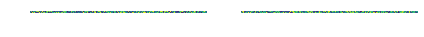

<Figure size 2160x1440 with 0 Axes>

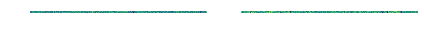

<Figure size 2160x1440 with 0 Axes>

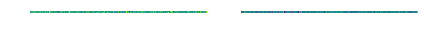

<Figure size 2160x1440 with 0 Axes>

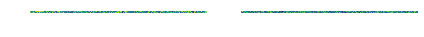

<Figure size 2160x1440 with 0 Axes>

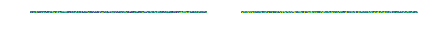

<Figure size 2160x1440 with 0 Axes>

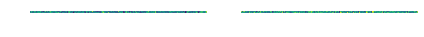

<Figure size 2160x1440 with 0 Axes>

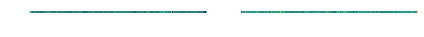

<Figure size 2160x1440 with 0 Axes>

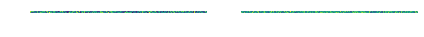

<Figure size 2160x1440 with 0 Axes>

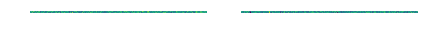

<Figure size 2160x1440 with 0 Axes>

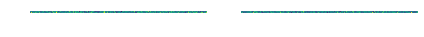

<Figure size 2160x1440 with 0 Axes>

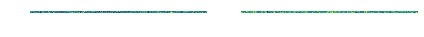

<Figure size 2160x1440 with 0 Axes>

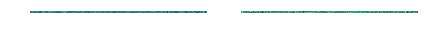

<Figure size 2160x1440 with 0 Axes>

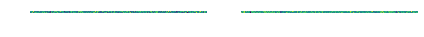

<Figure size 2160x1440 with 0 Axes>

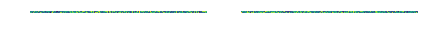

<Figure size 2160x1440 with 0 Axes>

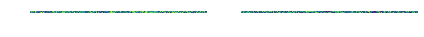

<Figure size 2160x1440 with 0 Axes>

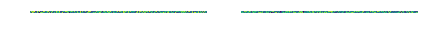

<Figure size 2160x1440 with 0 Axes>

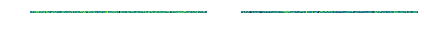

<Figure size 2160x1440 with 0 Axes>

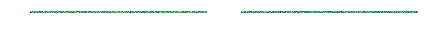

<Figure size 2160x1440 with 0 Axes>

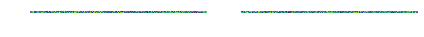

<Figure size 2160x1440 with 0 Axes>

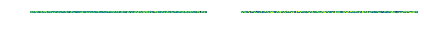

<Figure size 2160x1440 with 0 Axes>

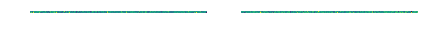

<Figure size 2160x1440 with 0 Axes>

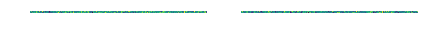

<Figure size 2160x1440 with 0 Axes>

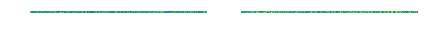

<Figure size 2160x1440 with 0 Axes>

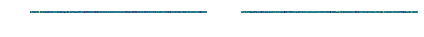

<Figure size 2160x1440 with 0 Axes>

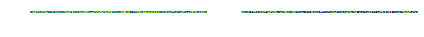

<Figure size 2160x1440 with 0 Axes>

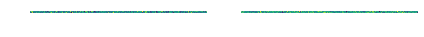

<Figure size 2160x1440 with 0 Axes>

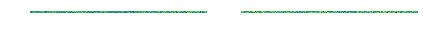

<Figure size 2160x1440 with 0 Axes>

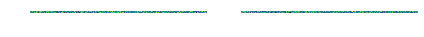

<Figure size 2160x1440 with 0 Axes>

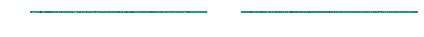

<Figure size 2160x1440 with 0 Axes>

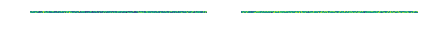

<Figure size 2160x1440 with 0 Axes>

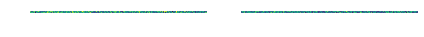

<Figure size 2160x1440 with 0 Axes>

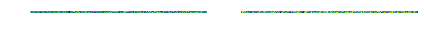

<Figure size 2160x1440 with 0 Axes>

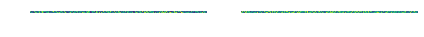

<Figure size 2160x1440 with 0 Axes>

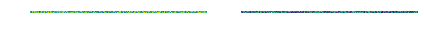

<Figure size 2160x1440 with 0 Axes>

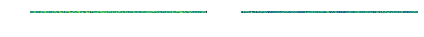

<Figure size 2160x1440 with 0 Axes>

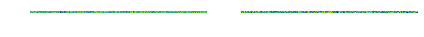

<Figure size 2160x1440 with 0 Axes>

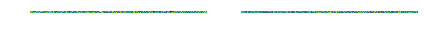

<Figure size 2160x1440 with 0 Axes>

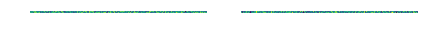

<Figure size 2160x1440 with 0 Axes>

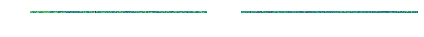

<Figure size 2160x1440 with 0 Axes>

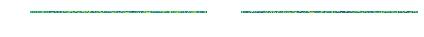

<Figure size 2160x1440 with 0 Axes>

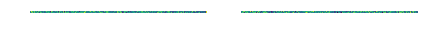

<Figure size 2160x1440 with 0 Axes>

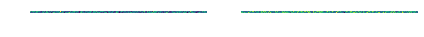

<Figure size 2160x1440 with 0 Axes>

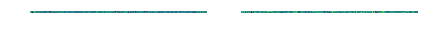

<Figure size 2160x1440 with 0 Axes>

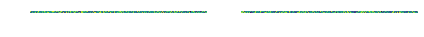

<Figure size 2160x1440 with 0 Axes>

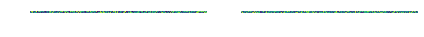

<Figure size 2160x1440 with 0 Axes>

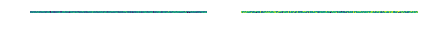

<Figure size 2160x1440 with 0 Axes>

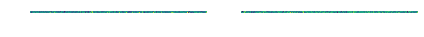

<Figure size 2160x1440 with 0 Axes>

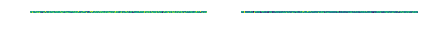

<Figure size 2160x1440 with 0 Axes>

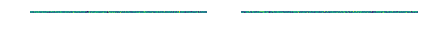

<Figure size 2160x1440 with 0 Axes>

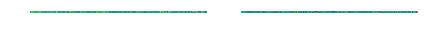

<Figure size 2160x1440 with 0 Axes>

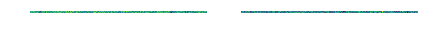

<Figure size 2160x1440 with 0 Axes>

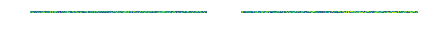

<Figure size 2160x1440 with 0 Axes>

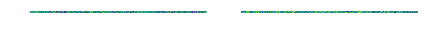

<Figure size 2160x1440 with 0 Axes>

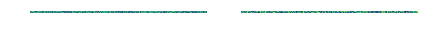

<Figure size 2160x1440 with 0 Axes>

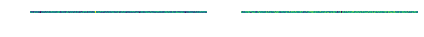

<Figure size 2160x1440 with 0 Axes>

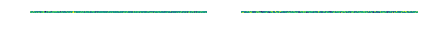

<Figure size 2160x1440 with 0 Axes>

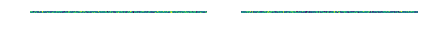

<Figure size 2160x1440 with 0 Axes>

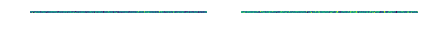

<Figure size 2160x1440 with 0 Axes>

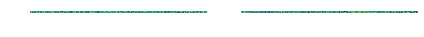

<Figure size 2160x1440 with 0 Axes>

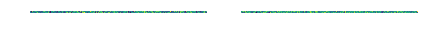

<Figure size 2160x1440 with 0 Axes>

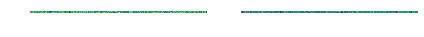

<Figure size 2160x1440 with 0 Axes>

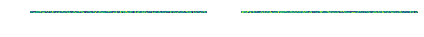

<Figure size 2160x1440 with 0 Axes>

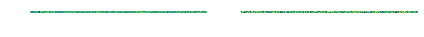

<Figure size 2160x1440 with 0 Axes>

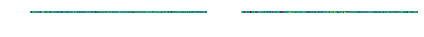

<Figure size 2160x1440 with 0 Axes>

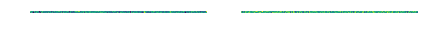

<Figure size 2160x1440 with 0 Axes>

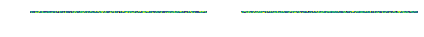

<Figure size 2160x1440 with 0 Axes>

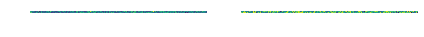

<Figure size 2160x1440 with 0 Axes>

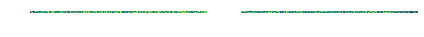

<Figure size 2160x1440 with 0 Axes>

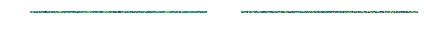

<Figure size 2160x1440 with 0 Axes>

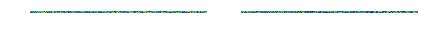

<Figure size 2160x1440 with 0 Axes>

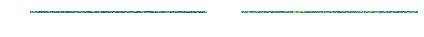

<Figure size 2160x1440 with 0 Axes>

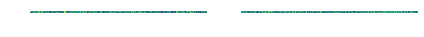

<Figure size 2160x1440 with 0 Axes>

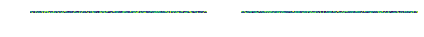

<Figure size 2160x1440 with 0 Axes>

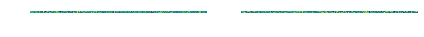

<Figure size 2160x1440 with 0 Axes>

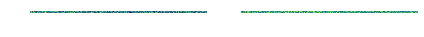

<Figure size 2160x1440 with 0 Axes>

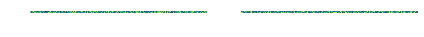

<Figure size 2160x1440 with 0 Axes>

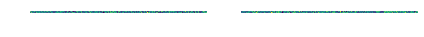

<Figure size 2160x1440 with 0 Axes>

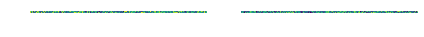

<Figure size 2160x1440 with 0 Axes>

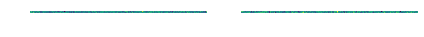

<Figure size 2160x1440 with 0 Axes>

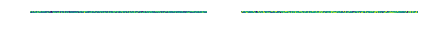

<Figure size 2160x1440 with 0 Axes>

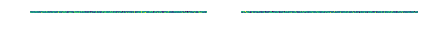

<Figure size 2160x1440 with 0 Axes>

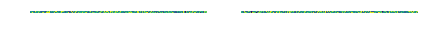

<Figure size 2160x1440 with 0 Axes>

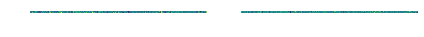

<Figure size 2160x1440 with 0 Axes>

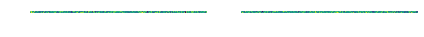

<Figure size 2160x1440 with 0 Axes>

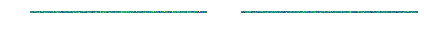

<Figure size 2160x1440 with 0 Axes>

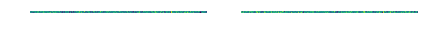

<Figure size 2160x1440 with 0 Axes>

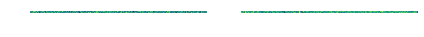

<Figure size 2160x1440 with 0 Axes>

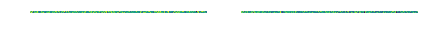

<Figure size 2160x1440 with 0 Axes>

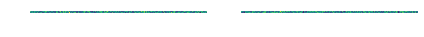

<Figure size 2160x1440 with 0 Axes>

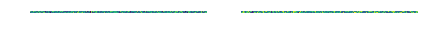

<Figure size 2160x1440 with 0 Axes>

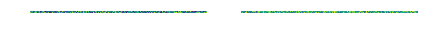

<Figure size 2160x1440 with 0 Axes>

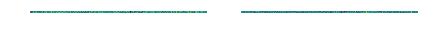

<Figure size 2160x1440 with 0 Axes>

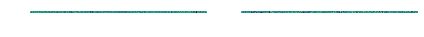

<Figure size 2160x1440 with 0 Axes>

conv2d_7 (3, 3, 256, 512)
512


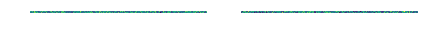

<Figure size 2160x1440 with 0 Axes>

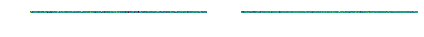

<Figure size 2160x1440 with 0 Axes>

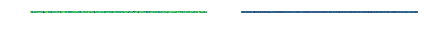

<Figure size 2160x1440 with 0 Axes>

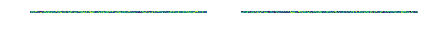

<Figure size 2160x1440 with 0 Axes>

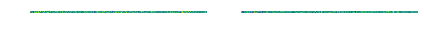

<Figure size 2160x1440 with 0 Axes>

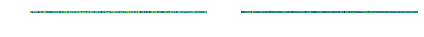

<Figure size 2160x1440 with 0 Axes>

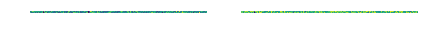

<Figure size 2160x1440 with 0 Axes>

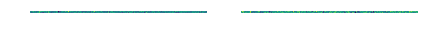

<Figure size 2160x1440 with 0 Axes>

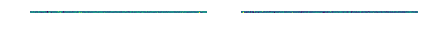

<Figure size 2160x1440 with 0 Axes>

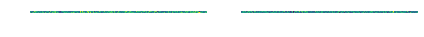

<Figure size 2160x1440 with 0 Axes>

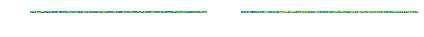

<Figure size 2160x1440 with 0 Axes>

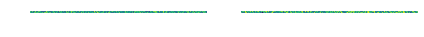

<Figure size 2160x1440 with 0 Axes>

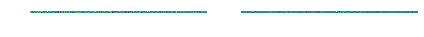

<Figure size 2160x1440 with 0 Axes>

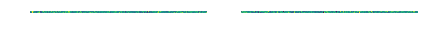

<Figure size 2160x1440 with 0 Axes>

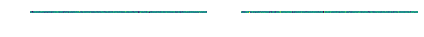

<Figure size 2160x1440 with 0 Axes>

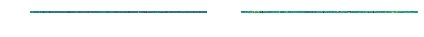

<Figure size 2160x1440 with 0 Axes>

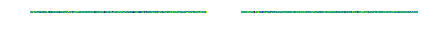

<Figure size 2160x1440 with 0 Axes>

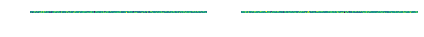

<Figure size 2160x1440 with 0 Axes>

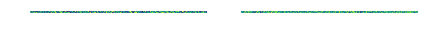

<Figure size 2160x1440 with 0 Axes>

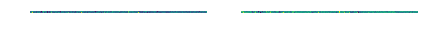

<Figure size 2160x1440 with 0 Axes>

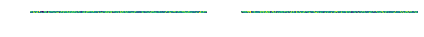

<Figure size 2160x1440 with 0 Axes>

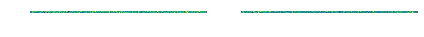

<Figure size 2160x1440 with 0 Axes>

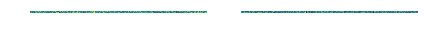

<Figure size 2160x1440 with 0 Axes>

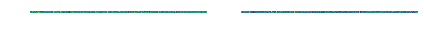

<Figure size 2160x1440 with 0 Axes>

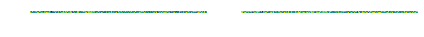

<Figure size 2160x1440 with 0 Axes>

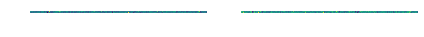

<Figure size 2160x1440 with 0 Axes>

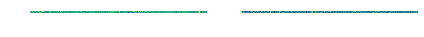

<Figure size 2160x1440 with 0 Axes>

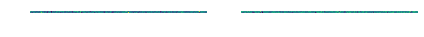

<Figure size 2160x1440 with 0 Axes>

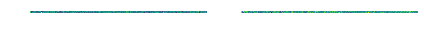

<Figure size 2160x1440 with 0 Axes>

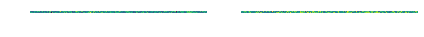

<Figure size 2160x1440 with 0 Axes>

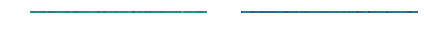

<Figure size 2160x1440 with 0 Axes>

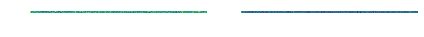

<Figure size 2160x1440 with 0 Axes>

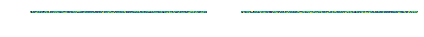

<Figure size 2160x1440 with 0 Axes>

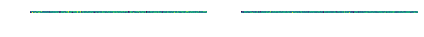

<Figure size 2160x1440 with 0 Axes>

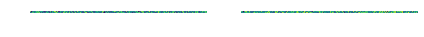

<Figure size 2160x1440 with 0 Axes>

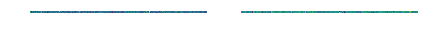

<Figure size 2160x1440 with 0 Axes>

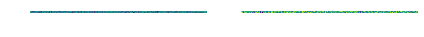

<Figure size 2160x1440 with 0 Axes>

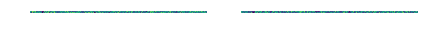

<Figure size 2160x1440 with 0 Axes>

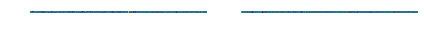

<Figure size 2160x1440 with 0 Axes>

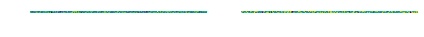

<Figure size 2160x1440 with 0 Axes>

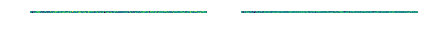

<Figure size 2160x1440 with 0 Axes>

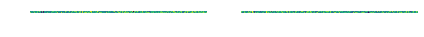

<Figure size 2160x1440 with 0 Axes>

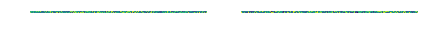

<Figure size 2160x1440 with 0 Axes>

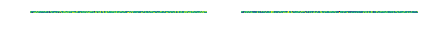

<Figure size 2160x1440 with 0 Axes>

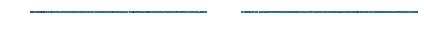

<Figure size 2160x1440 with 0 Axes>

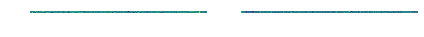

<Figure size 2160x1440 with 0 Axes>

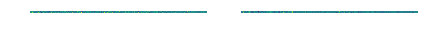

<Figure size 2160x1440 with 0 Axes>

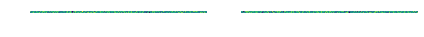

<Figure size 2160x1440 with 0 Axes>

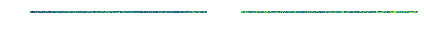

<Figure size 2160x1440 with 0 Axes>

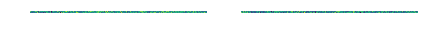

<Figure size 2160x1440 with 0 Axes>

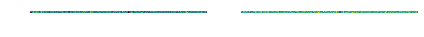

<Figure size 2160x1440 with 0 Axes>

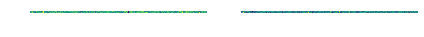

<Figure size 2160x1440 with 0 Axes>

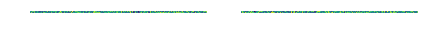

<Figure size 2160x1440 with 0 Axes>

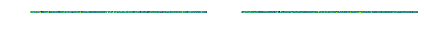

<Figure size 2160x1440 with 0 Axes>

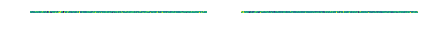

<Figure size 2160x1440 with 0 Axes>

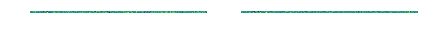

<Figure size 2160x1440 with 0 Axes>

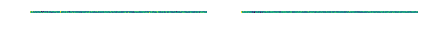

<Figure size 2160x1440 with 0 Axes>

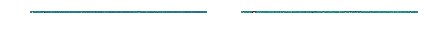

<Figure size 2160x1440 with 0 Axes>

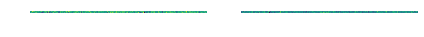

<Figure size 2160x1440 with 0 Axes>

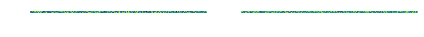

<Figure size 2160x1440 with 0 Axes>

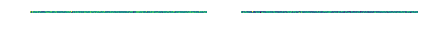

<Figure size 2160x1440 with 0 Axes>

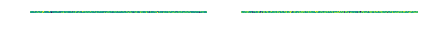

<Figure size 2160x1440 with 0 Axes>

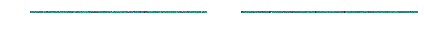

<Figure size 2160x1440 with 0 Axes>

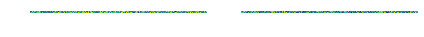

<Figure size 2160x1440 with 0 Axes>

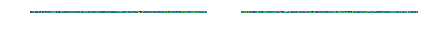

<Figure size 2160x1440 with 0 Axes>

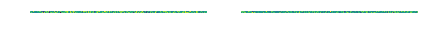

<Figure size 2160x1440 with 0 Axes>

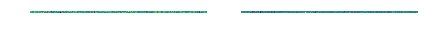

<Figure size 2160x1440 with 0 Axes>

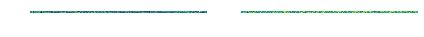

<Figure size 2160x1440 with 0 Axes>

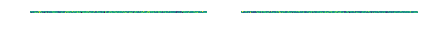

<Figure size 2160x1440 with 0 Axes>

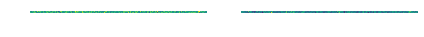

<Figure size 2160x1440 with 0 Axes>

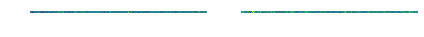

<Figure size 2160x1440 with 0 Axes>

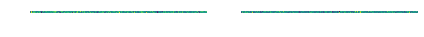

<Figure size 2160x1440 with 0 Axes>

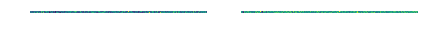

<Figure size 2160x1440 with 0 Axes>

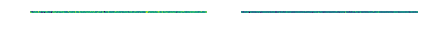

<Figure size 2160x1440 with 0 Axes>

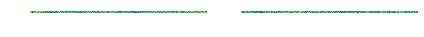

<Figure size 2160x1440 with 0 Axes>

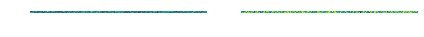

<Figure size 2160x1440 with 0 Axes>

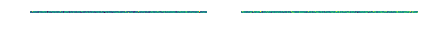

<Figure size 2160x1440 with 0 Axes>

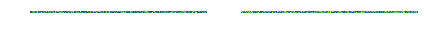

<Figure size 2160x1440 with 0 Axes>

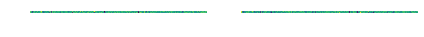

<Figure size 2160x1440 with 0 Axes>

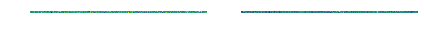

<Figure size 2160x1440 with 0 Axes>

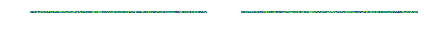

<Figure size 2160x1440 with 0 Axes>

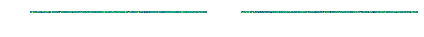

<Figure size 2160x1440 with 0 Axes>

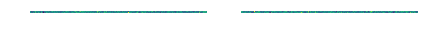

<Figure size 2160x1440 with 0 Axes>

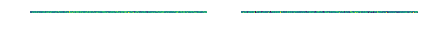

<Figure size 2160x1440 with 0 Axes>

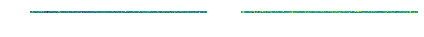

<Figure size 2160x1440 with 0 Axes>

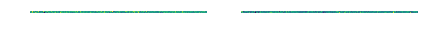

<Figure size 2160x1440 with 0 Axes>

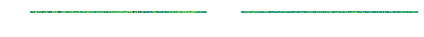

<Figure size 2160x1440 with 0 Axes>

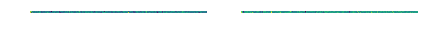

<Figure size 2160x1440 with 0 Axes>

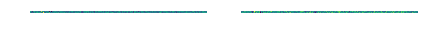

<Figure size 2160x1440 with 0 Axes>

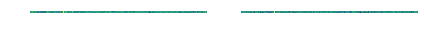

<Figure size 2160x1440 with 0 Axes>

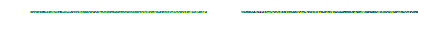

<Figure size 2160x1440 with 0 Axes>

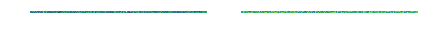

<Figure size 2160x1440 with 0 Axes>

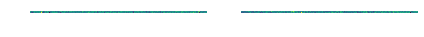

<Figure size 2160x1440 with 0 Axes>

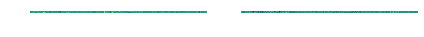

<Figure size 2160x1440 with 0 Axes>

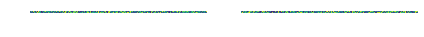

<Figure size 2160x1440 with 0 Axes>

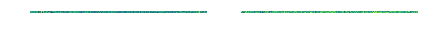

<Figure size 2160x1440 with 0 Axes>

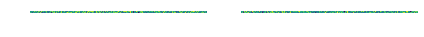

<Figure size 2160x1440 with 0 Axes>

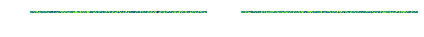

<Figure size 2160x1440 with 0 Axes>

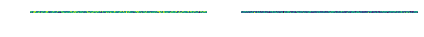

<Figure size 2160x1440 with 0 Axes>

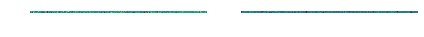

<Figure size 2160x1440 with 0 Axes>

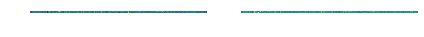

<Figure size 2160x1440 with 0 Axes>

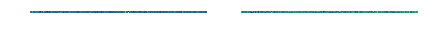

<Figure size 2160x1440 with 0 Axes>

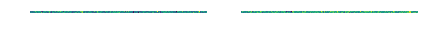

<Figure size 2160x1440 with 0 Axes>

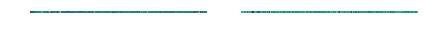

<Figure size 2160x1440 with 0 Axes>

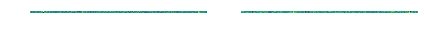

<Figure size 2160x1440 with 0 Axes>

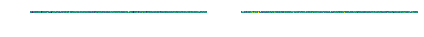

<Figure size 2160x1440 with 0 Axes>

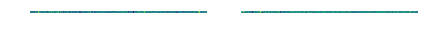

<Figure size 2160x1440 with 0 Axes>

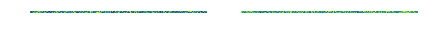

<Figure size 2160x1440 with 0 Axes>

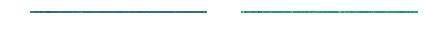

<Figure size 2160x1440 with 0 Axes>

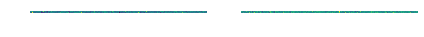

<Figure size 2160x1440 with 0 Axes>

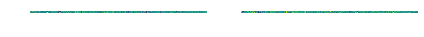

<Figure size 2160x1440 with 0 Axes>

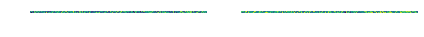

<Figure size 2160x1440 with 0 Axes>

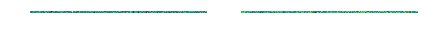

<Figure size 2160x1440 with 0 Axes>

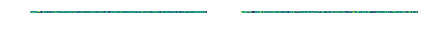

<Figure size 2160x1440 with 0 Axes>

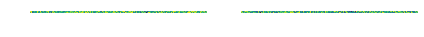

<Figure size 2160x1440 with 0 Axes>

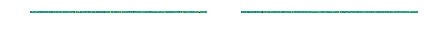

<Figure size 2160x1440 with 0 Axes>

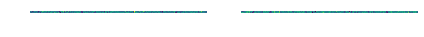

<Figure size 2160x1440 with 0 Axes>

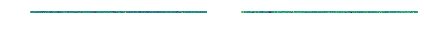

<Figure size 2160x1440 with 0 Axes>

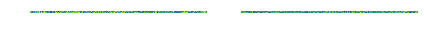

<Figure size 2160x1440 with 0 Axes>

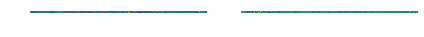

<Figure size 2160x1440 with 0 Axes>

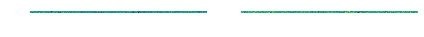

<Figure size 2160x1440 with 0 Axes>

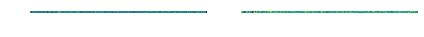

<Figure size 2160x1440 with 0 Axes>

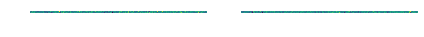

<Figure size 2160x1440 with 0 Axes>

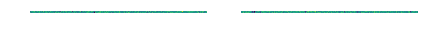

<Figure size 2160x1440 with 0 Axes>

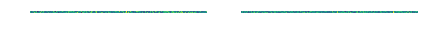

<Figure size 2160x1440 with 0 Axes>

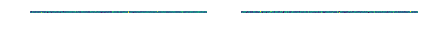

<Figure size 2160x1440 with 0 Axes>

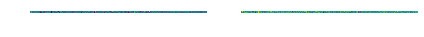

<Figure size 2160x1440 with 0 Axes>

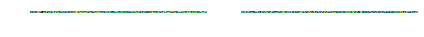

<Figure size 2160x1440 with 0 Axes>

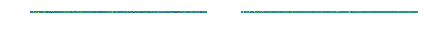

<Figure size 2160x1440 with 0 Axes>

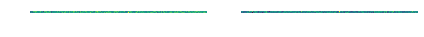

<Figure size 2160x1440 with 0 Axes>

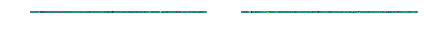

<Figure size 2160x1440 with 0 Axes>

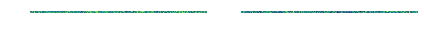

<Figure size 2160x1440 with 0 Axes>

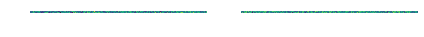

<Figure size 2160x1440 with 0 Axes>

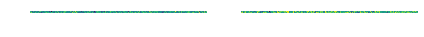

<Figure size 2160x1440 with 0 Axes>

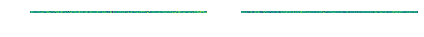

<Figure size 2160x1440 with 0 Axes>

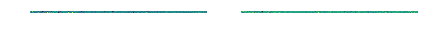

<Figure size 2160x1440 with 0 Axes>

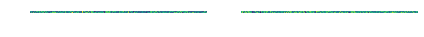

<Figure size 2160x1440 with 0 Axes>

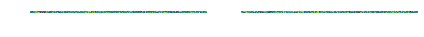

<Figure size 2160x1440 with 0 Axes>

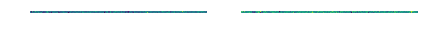

<Figure size 2160x1440 with 0 Axes>

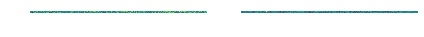

<Figure size 2160x1440 with 0 Axes>

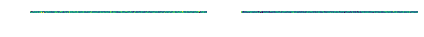

<Figure size 2160x1440 with 0 Axes>

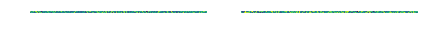

<Figure size 2160x1440 with 0 Axes>

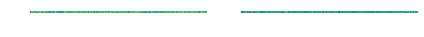

<Figure size 2160x1440 with 0 Axes>

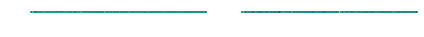

<Figure size 2160x1440 with 0 Axes>

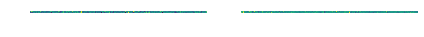

<Figure size 2160x1440 with 0 Axes>

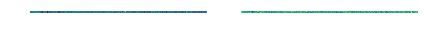

<Figure size 2160x1440 with 0 Axes>

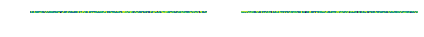

<Figure size 2160x1440 with 0 Axes>

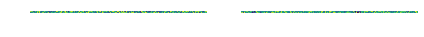

<Figure size 2160x1440 with 0 Axes>

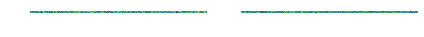

<Figure size 2160x1440 with 0 Axes>

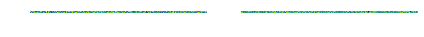

<Figure size 2160x1440 with 0 Axes>

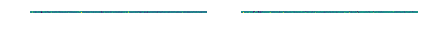

<Figure size 2160x1440 with 0 Axes>

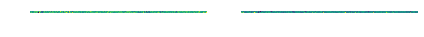

<Figure size 2160x1440 with 0 Axes>

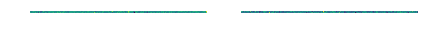

<Figure size 2160x1440 with 0 Axes>

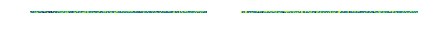

<Figure size 2160x1440 with 0 Axes>

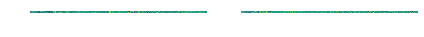

<Figure size 2160x1440 with 0 Axes>

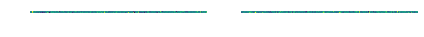

<Figure size 2160x1440 with 0 Axes>

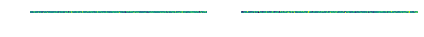

<Figure size 2160x1440 with 0 Axes>

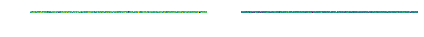

<Figure size 2160x1440 with 0 Axes>

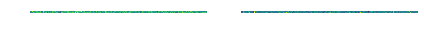

<Figure size 2160x1440 with 0 Axes>

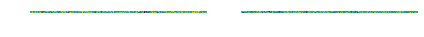

<Figure size 2160x1440 with 0 Axes>

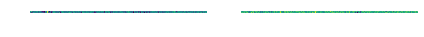

<Figure size 2160x1440 with 0 Axes>

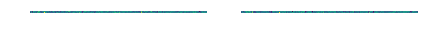

<Figure size 2160x1440 with 0 Axes>

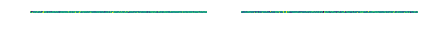

<Figure size 2160x1440 with 0 Axes>

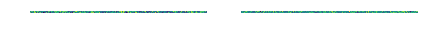

<Figure size 2160x1440 with 0 Axes>

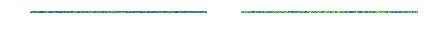

<Figure size 2160x1440 with 0 Axes>

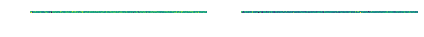

<Figure size 2160x1440 with 0 Axes>

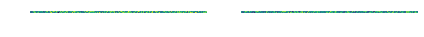

<Figure size 2160x1440 with 0 Axes>

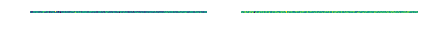

<Figure size 2160x1440 with 0 Axes>

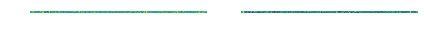

<Figure size 2160x1440 with 0 Axes>

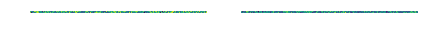

<Figure size 2160x1440 with 0 Axes>

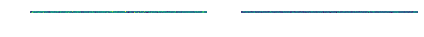

<Figure size 2160x1440 with 0 Axes>

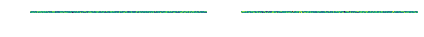

<Figure size 2160x1440 with 0 Axes>

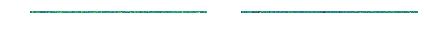

<Figure size 2160x1440 with 0 Axes>

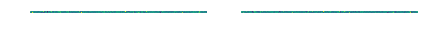

<Figure size 2160x1440 with 0 Axes>

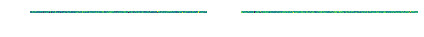

<Figure size 2160x1440 with 0 Axes>

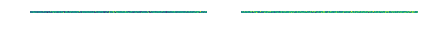

<Figure size 2160x1440 with 0 Axes>

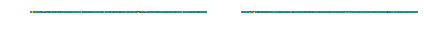

<Figure size 2160x1440 with 0 Axes>

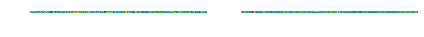

<Figure size 2160x1440 with 0 Axes>

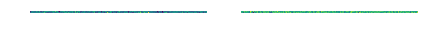

<Figure size 2160x1440 with 0 Axes>

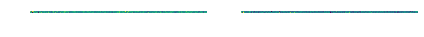

<Figure size 2160x1440 with 0 Axes>

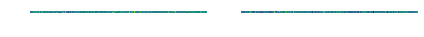

<Figure size 2160x1440 with 0 Axes>

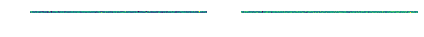

<Figure size 2160x1440 with 0 Axes>

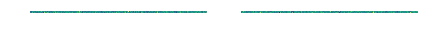

<Figure size 2160x1440 with 0 Axes>

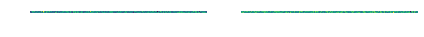

<Figure size 2160x1440 with 0 Axes>

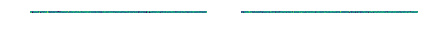

<Figure size 2160x1440 with 0 Axes>

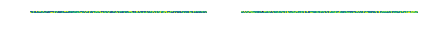

<Figure size 2160x1440 with 0 Axes>

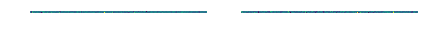

<Figure size 2160x1440 with 0 Axes>

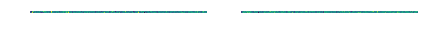

<Figure size 2160x1440 with 0 Axes>

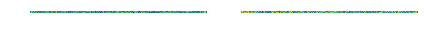

<Figure size 2160x1440 with 0 Axes>

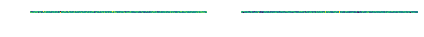

<Figure size 2160x1440 with 0 Axes>

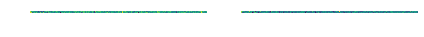

<Figure size 2160x1440 with 0 Axes>

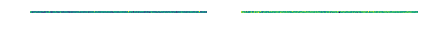

<Figure size 2160x1440 with 0 Axes>

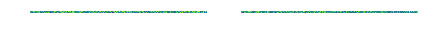

<Figure size 2160x1440 with 0 Axes>

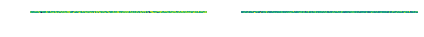

<Figure size 2160x1440 with 0 Axes>

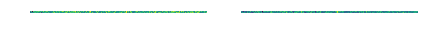

<Figure size 2160x1440 with 0 Axes>

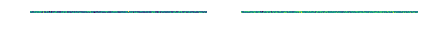

<Figure size 2160x1440 with 0 Axes>

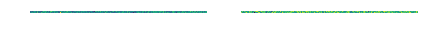

<Figure size 2160x1440 with 0 Axes>

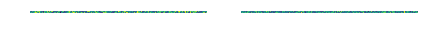

<Figure size 2160x1440 with 0 Axes>

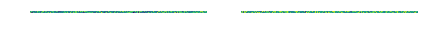

<Figure size 2160x1440 with 0 Axes>

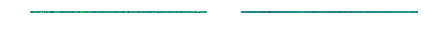

<Figure size 2160x1440 with 0 Axes>

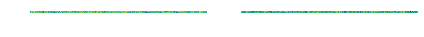

<Figure size 2160x1440 with 0 Axes>

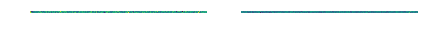

<Figure size 2160x1440 with 0 Axes>

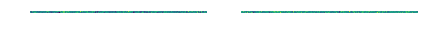

<Figure size 2160x1440 with 0 Axes>

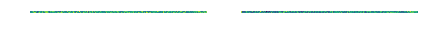

<Figure size 2160x1440 with 0 Axes>

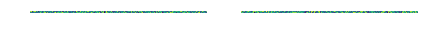

<Figure size 2160x1440 with 0 Axes>

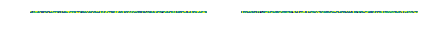

<Figure size 2160x1440 with 0 Axes>

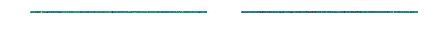

<Figure size 2160x1440 with 0 Axes>

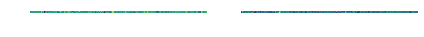

<Figure size 2160x1440 with 0 Axes>

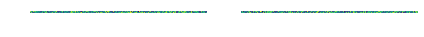

<Figure size 2160x1440 with 0 Axes>

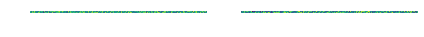

<Figure size 2160x1440 with 0 Axes>

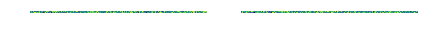

<Figure size 2160x1440 with 0 Axes>

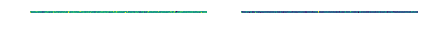

<Figure size 2160x1440 with 0 Axes>

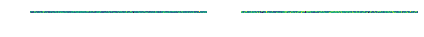

<Figure size 2160x1440 with 0 Axes>

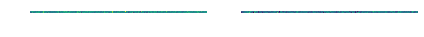

<Figure size 2160x1440 with 0 Axes>

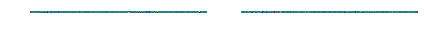

<Figure size 2160x1440 with 0 Axes>

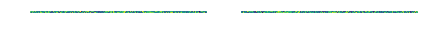

<Figure size 2160x1440 with 0 Axes>

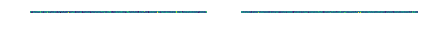

<Figure size 2160x1440 with 0 Axes>

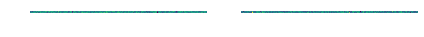

<Figure size 2160x1440 with 0 Axes>

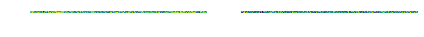

<Figure size 2160x1440 with 0 Axes>

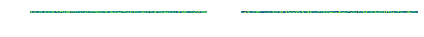

<Figure size 2160x1440 with 0 Axes>

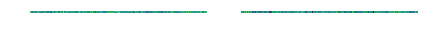

<Figure size 2160x1440 with 0 Axes>

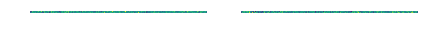

<Figure size 2160x1440 with 0 Axes>

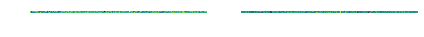

<Figure size 2160x1440 with 0 Axes>

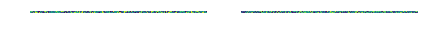

<Figure size 2160x1440 with 0 Axes>

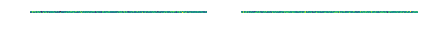

<Figure size 2160x1440 with 0 Axes>

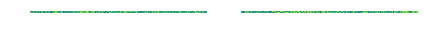

<Figure size 2160x1440 with 0 Axes>

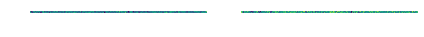

<Figure size 2160x1440 with 0 Axes>

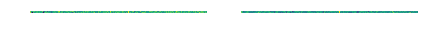

<Figure size 2160x1440 with 0 Axes>

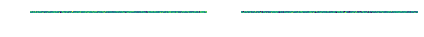

<Figure size 2160x1440 with 0 Axes>

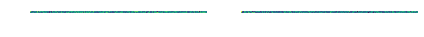

<Figure size 2160x1440 with 0 Axes>

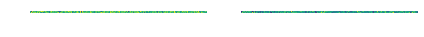

<Figure size 2160x1440 with 0 Axes>

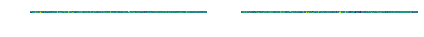

<Figure size 2160x1440 with 0 Axes>

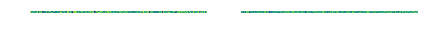

<Figure size 2160x1440 with 0 Axes>

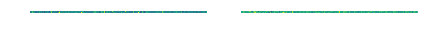

<Figure size 2160x1440 with 0 Axes>

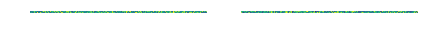

<Figure size 2160x1440 with 0 Axes>

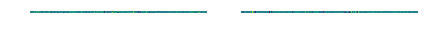

<Figure size 2160x1440 with 0 Axes>

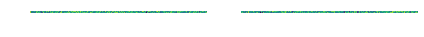

<Figure size 2160x1440 with 0 Axes>

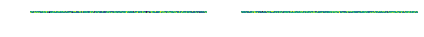

<Figure size 2160x1440 with 0 Axes>

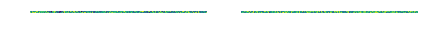

<Figure size 2160x1440 with 0 Axes>

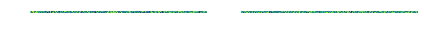

<Figure size 2160x1440 with 0 Axes>

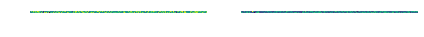

<Figure size 2160x1440 with 0 Axes>

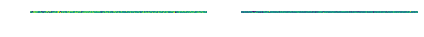

<Figure size 2160x1440 with 0 Axes>

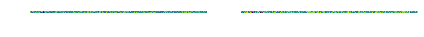

<Figure size 2160x1440 with 0 Axes>

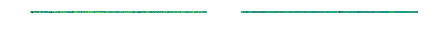

<Figure size 2160x1440 with 0 Axes>

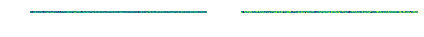

<Figure size 2160x1440 with 0 Axes>

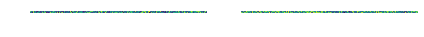

<Figure size 2160x1440 with 0 Axes>

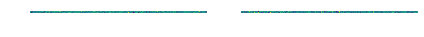

<Figure size 2160x1440 with 0 Axes>

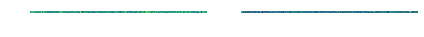

<Figure size 2160x1440 with 0 Axes>

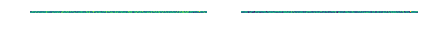

<Figure size 2160x1440 with 0 Axes>

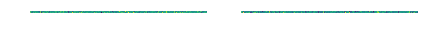

<Figure size 2160x1440 with 0 Axes>

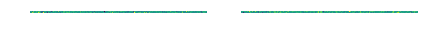

<Figure size 2160x1440 with 0 Axes>

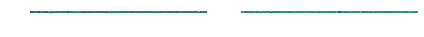

<Figure size 2160x1440 with 0 Axes>

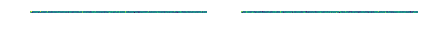

<Figure size 2160x1440 with 0 Axes>

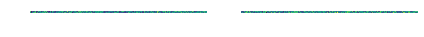

<Figure size 2160x1440 with 0 Axes>

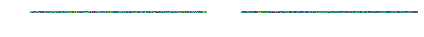

<Figure size 2160x1440 with 0 Axes>

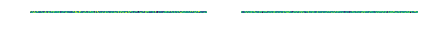

<Figure size 2160x1440 with 0 Axes>

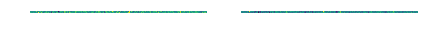

<Figure size 2160x1440 with 0 Axes>

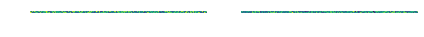

<Figure size 2160x1440 with 0 Axes>

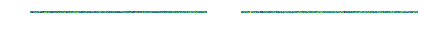

<Figure size 2160x1440 with 0 Axes>

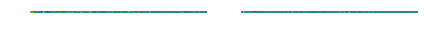

<Figure size 2160x1440 with 0 Axes>

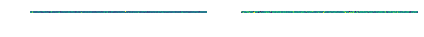

<Figure size 2160x1440 with 0 Axes>

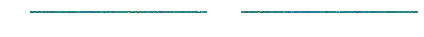

<Figure size 2160x1440 with 0 Axes>

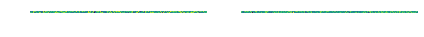

<Figure size 2160x1440 with 0 Axes>

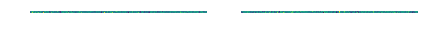

<Figure size 2160x1440 with 0 Axes>

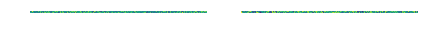

<Figure size 2160x1440 with 0 Axes>

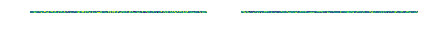

<Figure size 2160x1440 with 0 Axes>

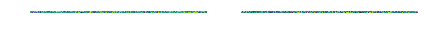

<Figure size 2160x1440 with 0 Axes>

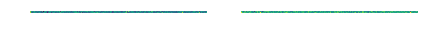

<Figure size 2160x1440 with 0 Axes>

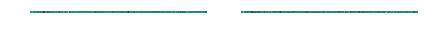

<Figure size 2160x1440 with 0 Axes>

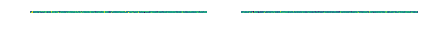

<Figure size 2160x1440 with 0 Axes>

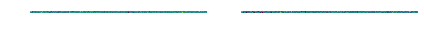

<Figure size 2160x1440 with 0 Axes>

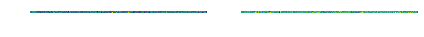

<Figure size 2160x1440 with 0 Axes>

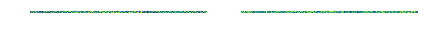

<Figure size 2160x1440 with 0 Axes>

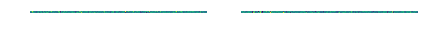

<Figure size 2160x1440 with 0 Axes>

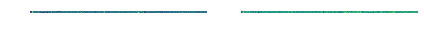

<Figure size 2160x1440 with 0 Axes>

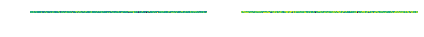

<Figure size 2160x1440 with 0 Axes>

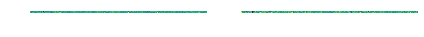

<Figure size 2160x1440 with 0 Axes>

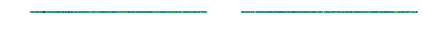

<Figure size 2160x1440 with 0 Axes>

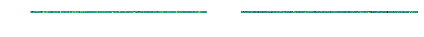

<Figure size 2160x1440 with 0 Axes>

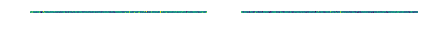

<Figure size 2160x1440 with 0 Axes>

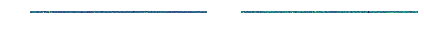

<Figure size 2160x1440 with 0 Axes>

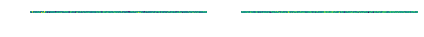

<Figure size 2160x1440 with 0 Axes>

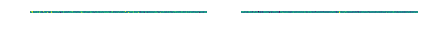

<Figure size 2160x1440 with 0 Axes>

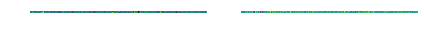

<Figure size 2160x1440 with 0 Axes>

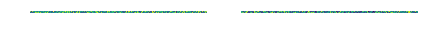

<Figure size 2160x1440 with 0 Axes>

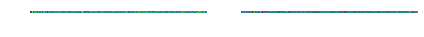

<Figure size 2160x1440 with 0 Axes>

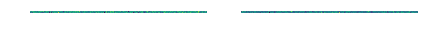

<Figure size 2160x1440 with 0 Axes>

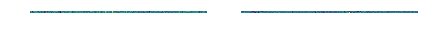

<Figure size 2160x1440 with 0 Axes>

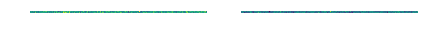

<Figure size 2160x1440 with 0 Axes>

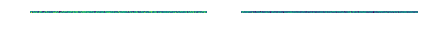

<Figure size 2160x1440 with 0 Axes>

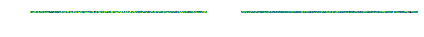

<Figure size 2160x1440 with 0 Axes>

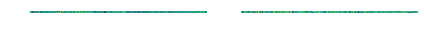

<Figure size 2160x1440 with 0 Axes>

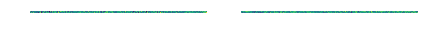

<Figure size 2160x1440 with 0 Axes>

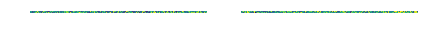

<Figure size 2160x1440 with 0 Axes>

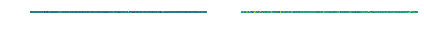

<Figure size 2160x1440 with 0 Axes>

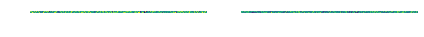

<Figure size 2160x1440 with 0 Axes>

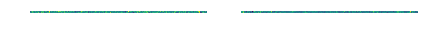

<Figure size 2160x1440 with 0 Axes>

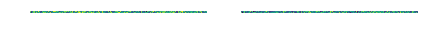

<Figure size 2160x1440 with 0 Axes>

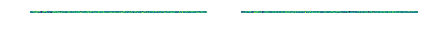

<Figure size 2160x1440 with 0 Axes>

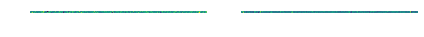

<Figure size 2160x1440 with 0 Axes>

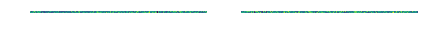

<Figure size 2160x1440 with 0 Axes>

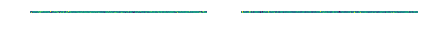

<Figure size 2160x1440 with 0 Axes>

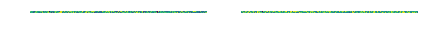

<Figure size 2160x1440 with 0 Axes>

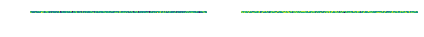

<Figure size 2160x1440 with 0 Axes>

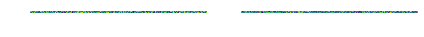

<Figure size 2160x1440 with 0 Axes>

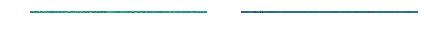

<Figure size 2160x1440 with 0 Axes>

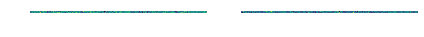

<Figure size 2160x1440 with 0 Axes>

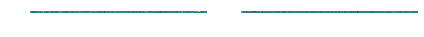

<Figure size 2160x1440 with 0 Axes>

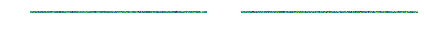

<Figure size 2160x1440 with 0 Axes>

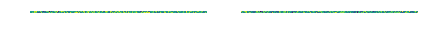

<Figure size 2160x1440 with 0 Axes>

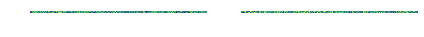

<Figure size 2160x1440 with 0 Axes>

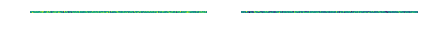

<Figure size 2160x1440 with 0 Axes>

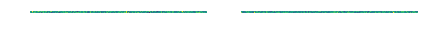

<Figure size 2160x1440 with 0 Axes>

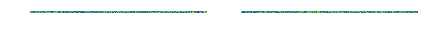

<Figure size 2160x1440 with 0 Axes>

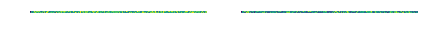

<Figure size 2160x1440 with 0 Axes>

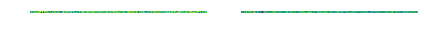

<Figure size 2160x1440 with 0 Axes>

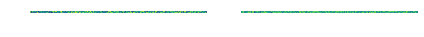

<Figure size 2160x1440 with 0 Axes>

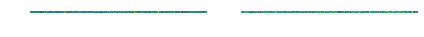

<Figure size 2160x1440 with 0 Axes>

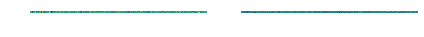

<Figure size 2160x1440 with 0 Axes>

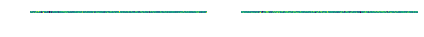

<Figure size 2160x1440 with 0 Axes>

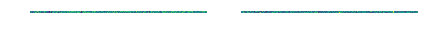

<Figure size 2160x1440 with 0 Axes>

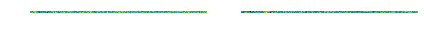

<Figure size 2160x1440 with 0 Axes>

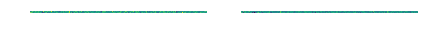

<Figure size 2160x1440 with 0 Axes>

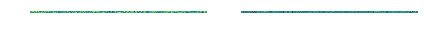

<Figure size 2160x1440 with 0 Axes>

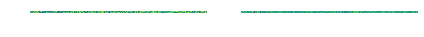

<Figure size 2160x1440 with 0 Axes>

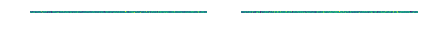

<Figure size 2160x1440 with 0 Axes>

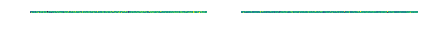

<Figure size 2160x1440 with 0 Axes>

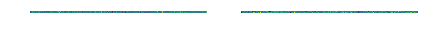

<Figure size 2160x1440 with 0 Axes>

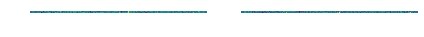

<Figure size 2160x1440 with 0 Axes>

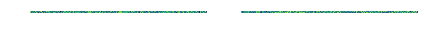

<Figure size 2160x1440 with 0 Axes>

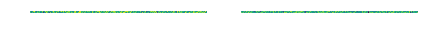

<Figure size 2160x1440 with 0 Axes>

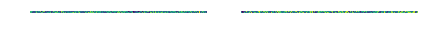

<Figure size 2160x1440 with 0 Axes>

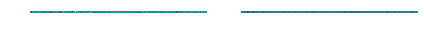

<Figure size 2160x1440 with 0 Axes>

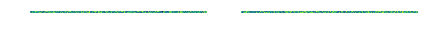

<Figure size 2160x1440 with 0 Axes>

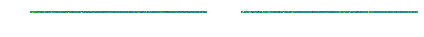

<Figure size 2160x1440 with 0 Axes>

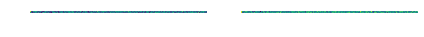

<Figure size 2160x1440 with 0 Axes>

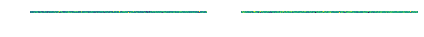

<Figure size 2160x1440 with 0 Axes>

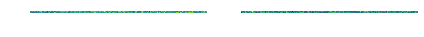

<Figure size 2160x1440 with 0 Axes>

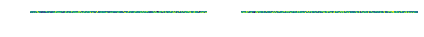

<Figure size 2160x1440 with 0 Axes>

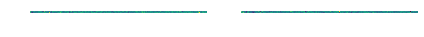

<Figure size 2160x1440 with 0 Axes>

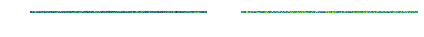

<Figure size 2160x1440 with 0 Axes>

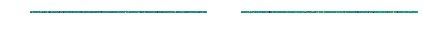

<Figure size 2160x1440 with 0 Axes>

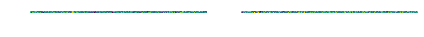

<Figure size 2160x1440 with 0 Axes>

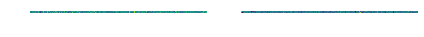

<Figure size 2160x1440 with 0 Axes>

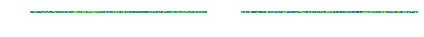

<Figure size 2160x1440 with 0 Axes>

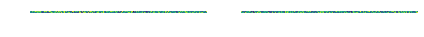

<Figure size 2160x1440 with 0 Axes>

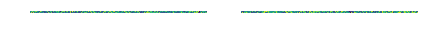

<Figure size 2160x1440 with 0 Axes>

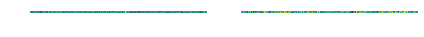

<Figure size 2160x1440 with 0 Axes>

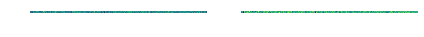

<Figure size 2160x1440 with 0 Axes>

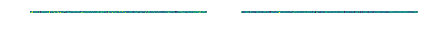

<Figure size 2160x1440 with 0 Axes>

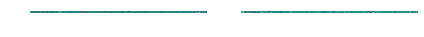

<Figure size 2160x1440 with 0 Axes>

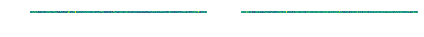

<Figure size 2160x1440 with 0 Axes>

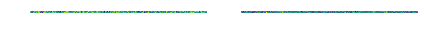

<Figure size 2160x1440 with 0 Axes>

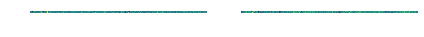

<Figure size 2160x1440 with 0 Axes>

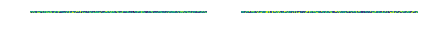

<Figure size 2160x1440 with 0 Axes>

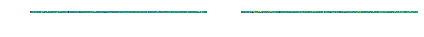

<Figure size 2160x1440 with 0 Axes>

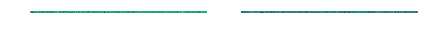

<Figure size 2160x1440 with 0 Axes>

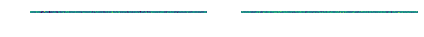

<Figure size 2160x1440 with 0 Axes>

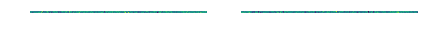

<Figure size 2160x1440 with 0 Axes>

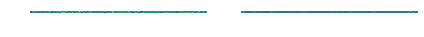

<Figure size 2160x1440 with 0 Axes>

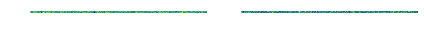

<Figure size 2160x1440 with 0 Axes>

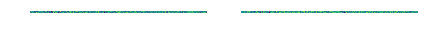

<Figure size 2160x1440 with 0 Axes>

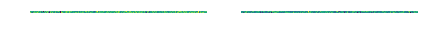

<Figure size 2160x1440 with 0 Axes>

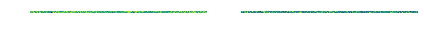

<Figure size 2160x1440 with 0 Axes>

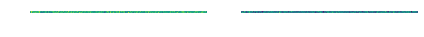

<Figure size 2160x1440 with 0 Axes>

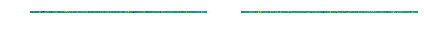

<Figure size 2160x1440 with 0 Axes>

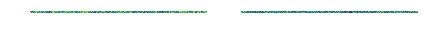

<Figure size 2160x1440 with 0 Axes>

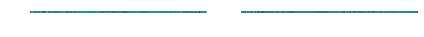

<Figure size 2160x1440 with 0 Axes>

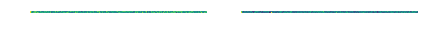

<Figure size 2160x1440 with 0 Axes>

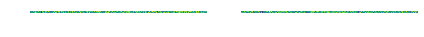

<Figure size 2160x1440 with 0 Axes>

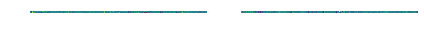

<Figure size 2160x1440 with 0 Axes>

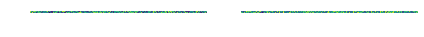

<Figure size 2160x1440 with 0 Axes>

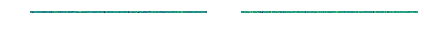

<Figure size 2160x1440 with 0 Axes>

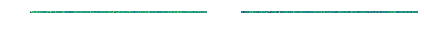

<Figure size 2160x1440 with 0 Axes>

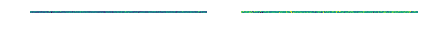

<Figure size 2160x1440 with 0 Axes>

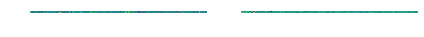

<Figure size 2160x1440 with 0 Axes>

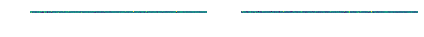

<Figure size 2160x1440 with 0 Axes>

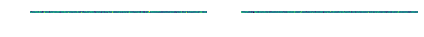

<Figure size 2160x1440 with 0 Axes>

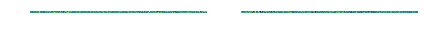

<Figure size 2160x1440 with 0 Axes>

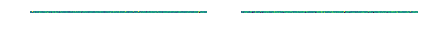

<Figure size 2160x1440 with 0 Axes>

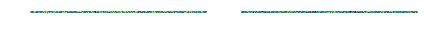

<Figure size 2160x1440 with 0 Axes>

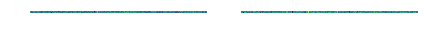

<Figure size 2160x1440 with 0 Axes>

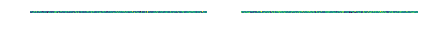

<Figure size 2160x1440 with 0 Axes>

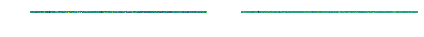

<Figure size 2160x1440 with 0 Axes>

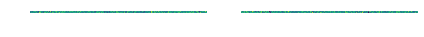

<Figure size 2160x1440 with 0 Axes>

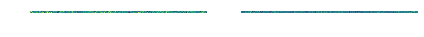

<Figure size 2160x1440 with 0 Axes>

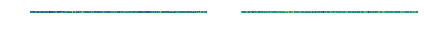

<Figure size 2160x1440 with 0 Axes>

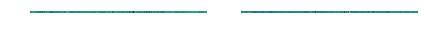

<Figure size 2160x1440 with 0 Axes>

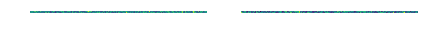

<Figure size 2160x1440 with 0 Axes>

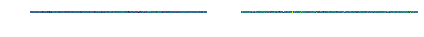

<Figure size 2160x1440 with 0 Axes>

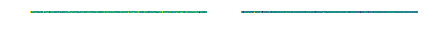

<Figure size 2160x1440 with 0 Axes>

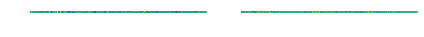

<Figure size 2160x1440 with 0 Axes>

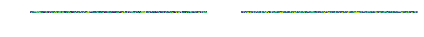

<Figure size 2160x1440 with 0 Axes>

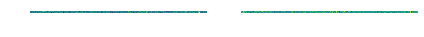

<Figure size 2160x1440 with 0 Axes>

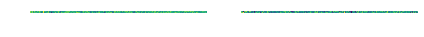

<Figure size 2160x1440 with 0 Axes>

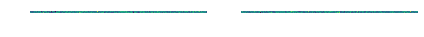

<Figure size 2160x1440 with 0 Axes>

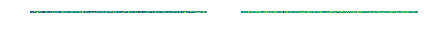

<Figure size 2160x1440 with 0 Axes>

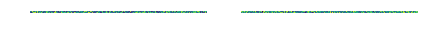

<Figure size 2160x1440 with 0 Axes>

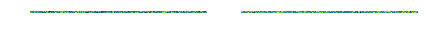

<Figure size 2160x1440 with 0 Axes>

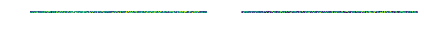

<Figure size 2160x1440 with 0 Axes>

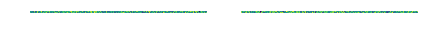

<Figure size 2160x1440 with 0 Axes>

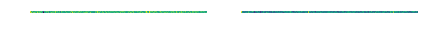

<Figure size 2160x1440 with 0 Axes>

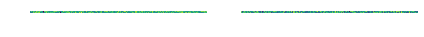

<Figure size 2160x1440 with 0 Axes>

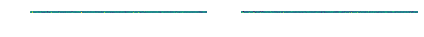

<Figure size 2160x1440 with 0 Axes>

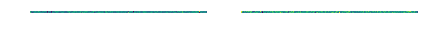

<Figure size 2160x1440 with 0 Axes>

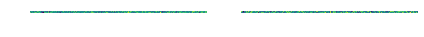

<Figure size 2160x1440 with 0 Axes>

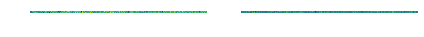

<Figure size 2160x1440 with 0 Axes>

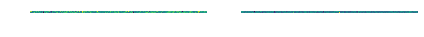

<Figure size 2160x1440 with 0 Axes>

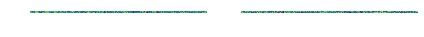

<Figure size 2160x1440 with 0 Axes>

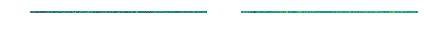

<Figure size 2160x1440 with 0 Axes>

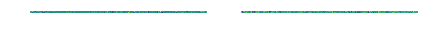

<Figure size 2160x1440 with 0 Axes>

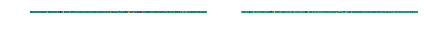

<Figure size 2160x1440 with 0 Axes>

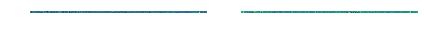

<Figure size 2160x1440 with 0 Axes>

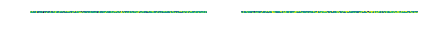

<Figure size 2160x1440 with 0 Axes>

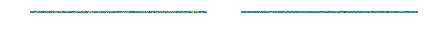

<Figure size 2160x1440 with 0 Axes>

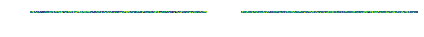

<Figure size 2160x1440 with 0 Axes>

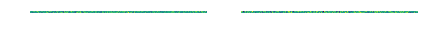

<Figure size 2160x1440 with 0 Axes>

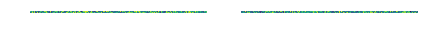

<Figure size 2160x1440 with 0 Axes>

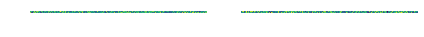

<Figure size 2160x1440 with 0 Axes>

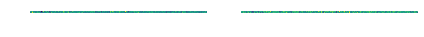

<Figure size 2160x1440 with 0 Axes>

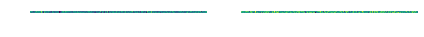

<Figure size 2160x1440 with 0 Axes>

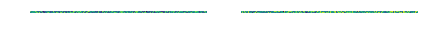

<Figure size 2160x1440 with 0 Axes>

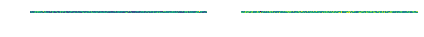

<Figure size 2160x1440 with 0 Axes>

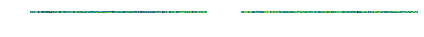

<Figure size 2160x1440 with 0 Axes>

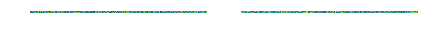

<Figure size 2160x1440 with 0 Axes>

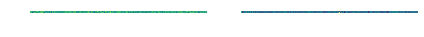

<Figure size 2160x1440 with 0 Axes>

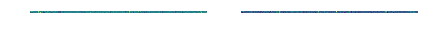

<Figure size 2160x1440 with 0 Axes>

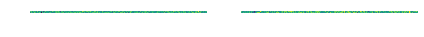

<Figure size 2160x1440 with 0 Axes>

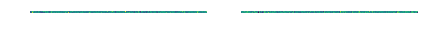

<Figure size 2160x1440 with 0 Axes>

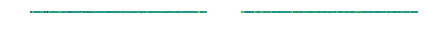

<Figure size 2160x1440 with 0 Axes>

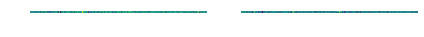

<Figure size 2160x1440 with 0 Axes>

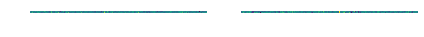

<Figure size 2160x1440 with 0 Axes>

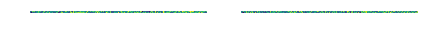

<Figure size 2160x1440 with 0 Axes>

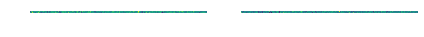

<Figure size 2160x1440 with 0 Axes>

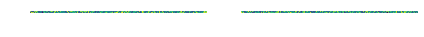

<Figure size 2160x1440 with 0 Axes>

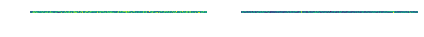

<Figure size 2160x1440 with 0 Axes>

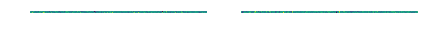

<Figure size 2160x1440 with 0 Axes>

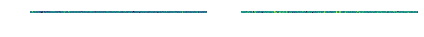

<Figure size 2160x1440 with 0 Axes>

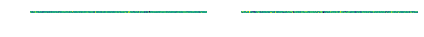

<Figure size 2160x1440 with 0 Axes>

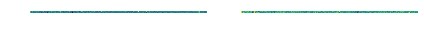

<Figure size 2160x1440 with 0 Axes>

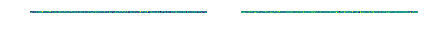

<Figure size 2160x1440 with 0 Axes>

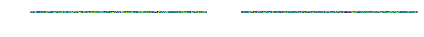

<Figure size 2160x1440 with 0 Axes>

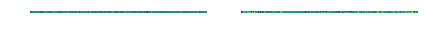

<Figure size 2160x1440 with 0 Axes>

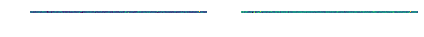

<Figure size 2160x1440 with 0 Axes>

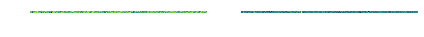

<Figure size 2160x1440 with 0 Axes>

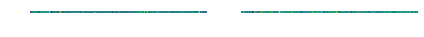

<Figure size 2160x1440 with 0 Axes>

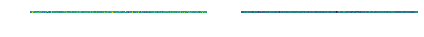

<Figure size 2160x1440 with 0 Axes>

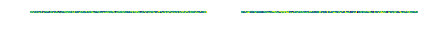

<Figure size 2160x1440 with 0 Axes>

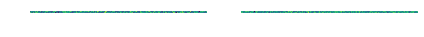

<Figure size 2160x1440 with 0 Axes>

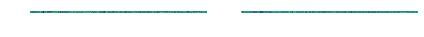

<Figure size 2160x1440 with 0 Axes>

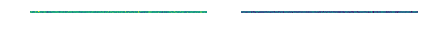

<Figure size 2160x1440 with 0 Axes>

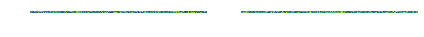

<Figure size 2160x1440 with 0 Axes>

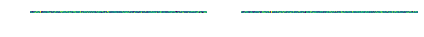

<Figure size 2160x1440 with 0 Axes>

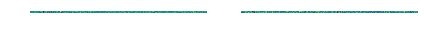

<Figure size 2160x1440 with 0 Axes>

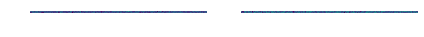

<Figure size 2160x1440 with 0 Axes>

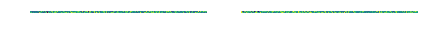

<Figure size 2160x1440 with 0 Axes>

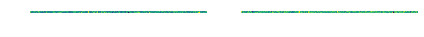

<Figure size 2160x1440 with 0 Axes>

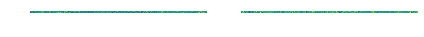

<Figure size 2160x1440 with 0 Axes>

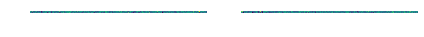

<Figure size 2160x1440 with 0 Axes>

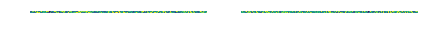

<Figure size 2160x1440 with 0 Axes>

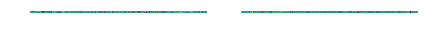

<Figure size 2160x1440 with 0 Axes>

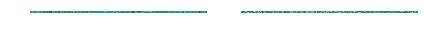

<Figure size 2160x1440 with 0 Axes>

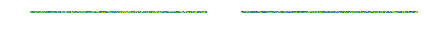

<Figure size 2160x1440 with 0 Axes>

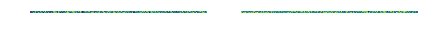

<Figure size 2160x1440 with 0 Axes>

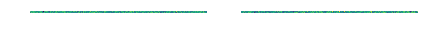

<Figure size 2160x1440 with 0 Axes>

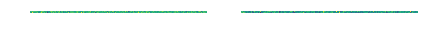

<Figure size 2160x1440 with 0 Axes>

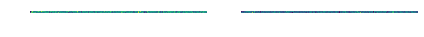

<Figure size 2160x1440 with 0 Axes>

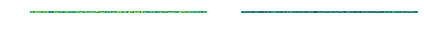

<Figure size 2160x1440 with 0 Axes>

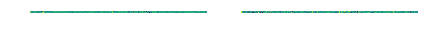

<Figure size 2160x1440 with 0 Axes>

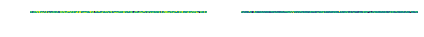

<Figure size 2160x1440 with 0 Axes>

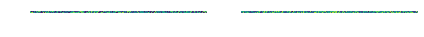

<Figure size 2160x1440 with 0 Axes>

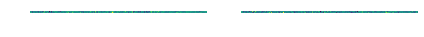

<Figure size 2160x1440 with 0 Axes>

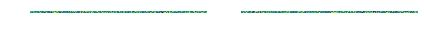

<Figure size 2160x1440 with 0 Axes>

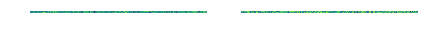

<Figure size 2160x1440 with 0 Axes>

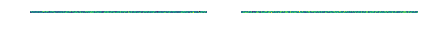

<Figure size 2160x1440 with 0 Axes>

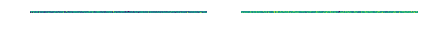

<Figure size 2160x1440 with 0 Axes>

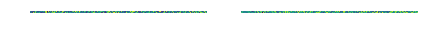

<Figure size 2160x1440 with 0 Axes>

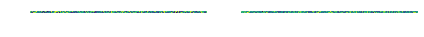

<Figure size 2160x1440 with 0 Axes>

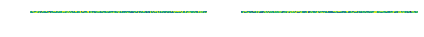

<Figure size 2160x1440 with 0 Axes>

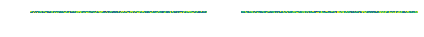

<Figure size 2160x1440 with 0 Axes>

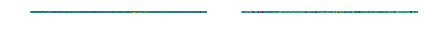

<Figure size 2160x1440 with 0 Axes>

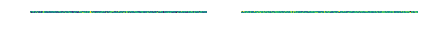

<Figure size 2160x1440 with 0 Axes>

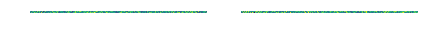

<Figure size 2160x1440 with 0 Axes>

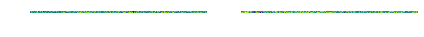

<Figure size 2160x1440 with 0 Axes>

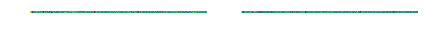

<Figure size 2160x1440 with 0 Axes>

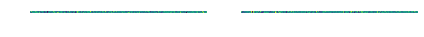

<Figure size 2160x1440 with 0 Axes>

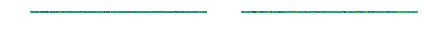

<Figure size 2160x1440 with 0 Axes>

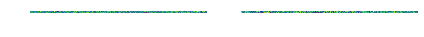

<Figure size 2160x1440 with 0 Axes>

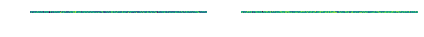

<Figure size 2160x1440 with 0 Axes>

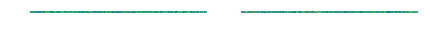

<Figure size 2160x1440 with 0 Axes>

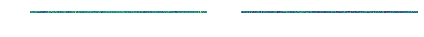

<Figure size 2160x1440 with 0 Axes>

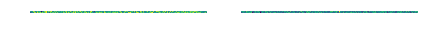

<Figure size 2160x1440 with 0 Axes>

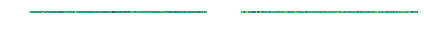

<Figure size 2160x1440 with 0 Axes>

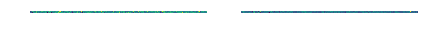

<Figure size 2160x1440 with 0 Axes>

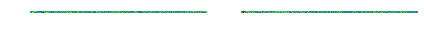

<Figure size 2160x1440 with 0 Axes>

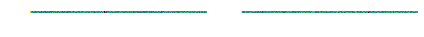

<Figure size 2160x1440 with 0 Axes>

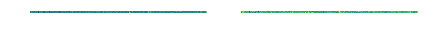

<Figure size 2160x1440 with 0 Axes>

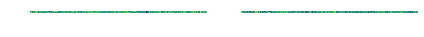

<Figure size 2160x1440 with 0 Axes>

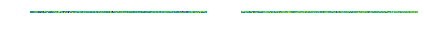

<Figure size 2160x1440 with 0 Axes>

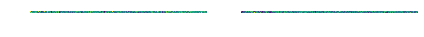

<Figure size 2160x1440 with 0 Axes>

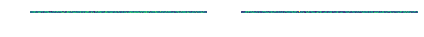

<Figure size 2160x1440 with 0 Axes>

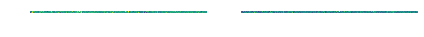

<Figure size 2160x1440 with 0 Axes>

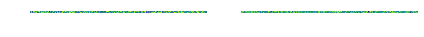

<Figure size 2160x1440 with 0 Axes>

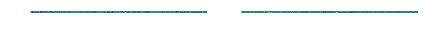

<Figure size 2160x1440 with 0 Axes>

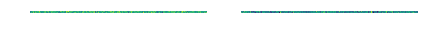

<Figure size 2160x1440 with 0 Axes>

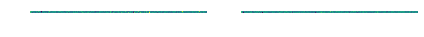

<Figure size 2160x1440 with 0 Axes>

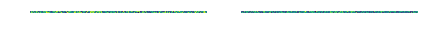

<Figure size 2160x1440 with 0 Axes>

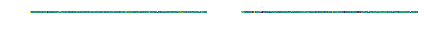

<Figure size 2160x1440 with 0 Axes>

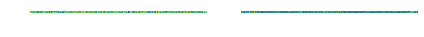

<Figure size 2160x1440 with 0 Axes>

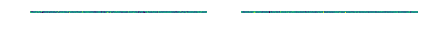

<Figure size 2160x1440 with 0 Axes>

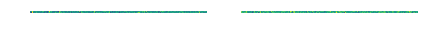

<Figure size 2160x1440 with 0 Axes>

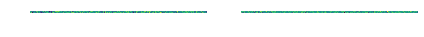

<Figure size 2160x1440 with 0 Axes>

conv2d_8 (3, 3, 512, 512)
512


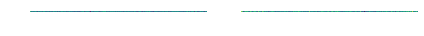

<Figure size 2160x1440 with 0 Axes>

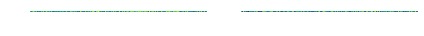

<Figure size 2160x1440 with 0 Axes>

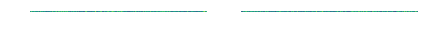

<Figure size 2160x1440 with 0 Axes>

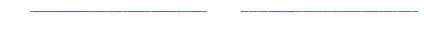

<Figure size 2160x1440 with 0 Axes>

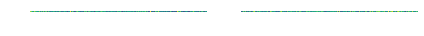

<Figure size 2160x1440 with 0 Axes>

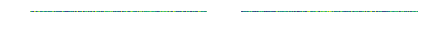

<Figure size 2160x1440 with 0 Axes>

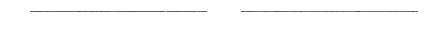

<Figure size 2160x1440 with 0 Axes>

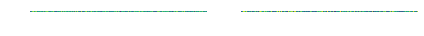

<Figure size 2160x1440 with 0 Axes>

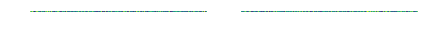

<Figure size 2160x1440 with 0 Axes>

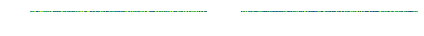

<Figure size 2160x1440 with 0 Axes>

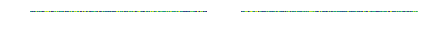

<Figure size 2160x1440 with 0 Axes>

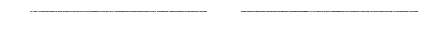

<Figure size 2160x1440 with 0 Axes>

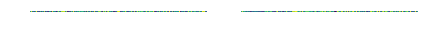

<Figure size 2160x1440 with 0 Axes>

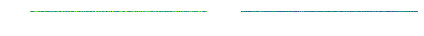

<Figure size 2160x1440 with 0 Axes>

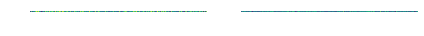

<Figure size 2160x1440 with 0 Axes>

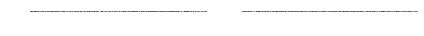

<Figure size 2160x1440 with 0 Axes>

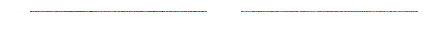

<Figure size 2160x1440 with 0 Axes>

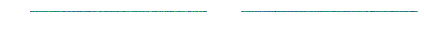

<Figure size 2160x1440 with 0 Axes>

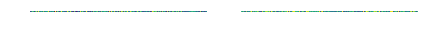

<Figure size 2160x1440 with 0 Axes>

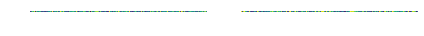

<Figure size 2160x1440 with 0 Axes>

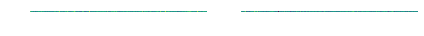

<Figure size 2160x1440 with 0 Axes>

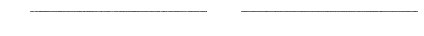

<Figure size 2160x1440 with 0 Axes>

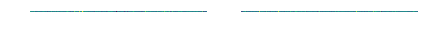

<Figure size 2160x1440 with 0 Axes>

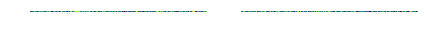

<Figure size 2160x1440 with 0 Axes>

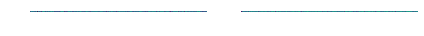

<Figure size 2160x1440 with 0 Axes>

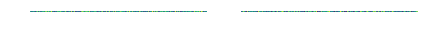

<Figure size 2160x1440 with 0 Axes>

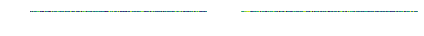

<Figure size 2160x1440 with 0 Axes>

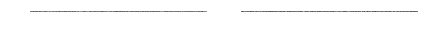

<Figure size 2160x1440 with 0 Axes>

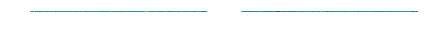

<Figure size 2160x1440 with 0 Axes>

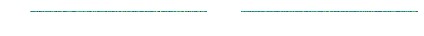

<Figure size 2160x1440 with 0 Axes>

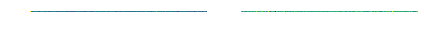

<Figure size 2160x1440 with 0 Axes>

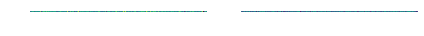

<Figure size 2160x1440 with 0 Axes>

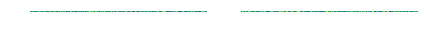

<Figure size 2160x1440 with 0 Axes>

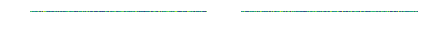

<Figure size 2160x1440 with 0 Axes>

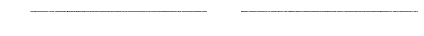

<Figure size 2160x1440 with 0 Axes>

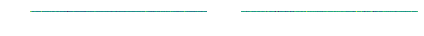

<Figure size 2160x1440 with 0 Axes>

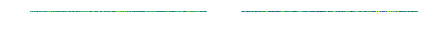

<Figure size 2160x1440 with 0 Axes>

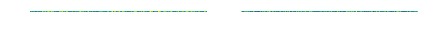

<Figure size 2160x1440 with 0 Axes>

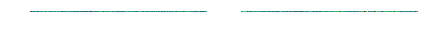

<Figure size 2160x1440 with 0 Axes>

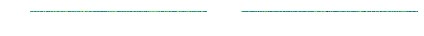

<Figure size 2160x1440 with 0 Axes>

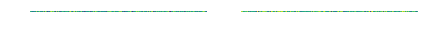

<Figure size 2160x1440 with 0 Axes>

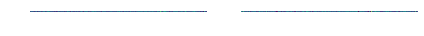

<Figure size 2160x1440 with 0 Axes>

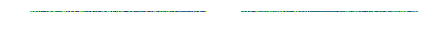

<Figure size 2160x1440 with 0 Axes>

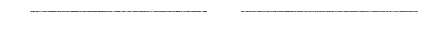

<Figure size 2160x1440 with 0 Axes>

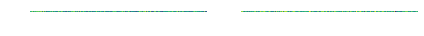

<Figure size 2160x1440 with 0 Axes>

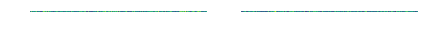

<Figure size 2160x1440 with 0 Axes>

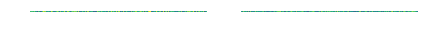

<Figure size 2160x1440 with 0 Axes>

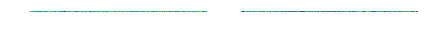

<Figure size 2160x1440 with 0 Axes>

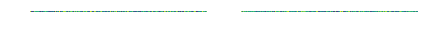

<Figure size 2160x1440 with 0 Axes>

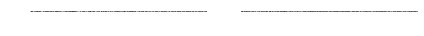

<Figure size 2160x1440 with 0 Axes>

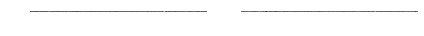

<Figure size 2160x1440 with 0 Axes>

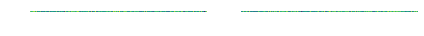

<Figure size 2160x1440 with 0 Axes>

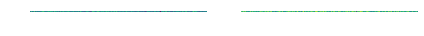

<Figure size 2160x1440 with 0 Axes>

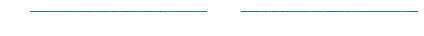

<Figure size 2160x1440 with 0 Axes>

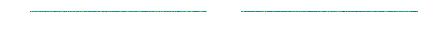

<Figure size 2160x1440 with 0 Axes>

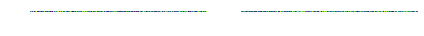

<Figure size 2160x1440 with 0 Axes>

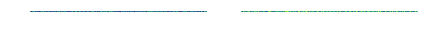

<Figure size 2160x1440 with 0 Axes>

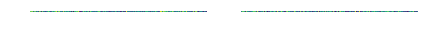

<Figure size 2160x1440 with 0 Axes>

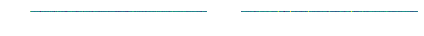

<Figure size 2160x1440 with 0 Axes>

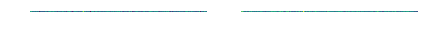

<Figure size 2160x1440 with 0 Axes>

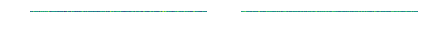

<Figure size 2160x1440 with 0 Axes>

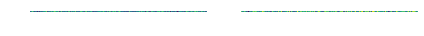

<Figure size 2160x1440 with 0 Axes>

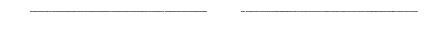

<Figure size 2160x1440 with 0 Axes>

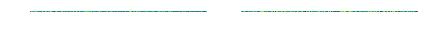

<Figure size 2160x1440 with 0 Axes>

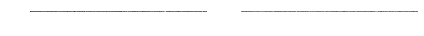

<Figure size 2160x1440 with 0 Axes>

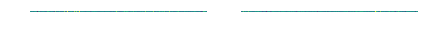

<Figure size 2160x1440 with 0 Axes>

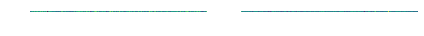

<Figure size 2160x1440 with 0 Axes>

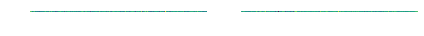

<Figure size 2160x1440 with 0 Axes>

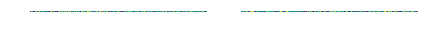

<Figure size 2160x1440 with 0 Axes>

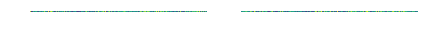

<Figure size 2160x1440 with 0 Axes>

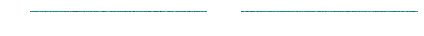

<Figure size 2160x1440 with 0 Axes>

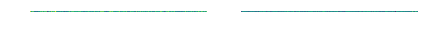

<Figure size 2160x1440 with 0 Axes>

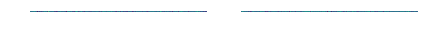

<Figure size 2160x1440 with 0 Axes>

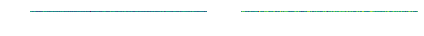

<Figure size 2160x1440 with 0 Axes>

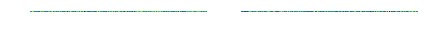

<Figure size 2160x1440 with 0 Axes>

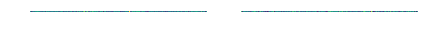

<Figure size 2160x1440 with 0 Axes>

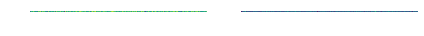

<Figure size 2160x1440 with 0 Axes>

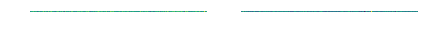

<Figure size 2160x1440 with 0 Axes>

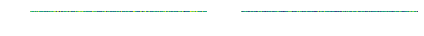

<Figure size 2160x1440 with 0 Axes>

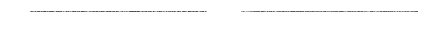

<Figure size 2160x1440 with 0 Axes>

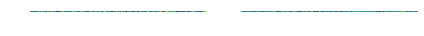

<Figure size 2160x1440 with 0 Axes>

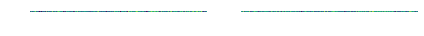

<Figure size 2160x1440 with 0 Axes>

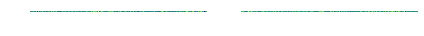

<Figure size 2160x1440 with 0 Axes>

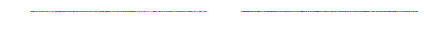

<Figure size 2160x1440 with 0 Axes>

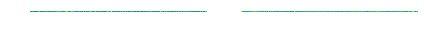

<Figure size 2160x1440 with 0 Axes>

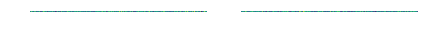

<Figure size 2160x1440 with 0 Axes>

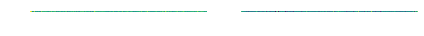

<Figure size 2160x1440 with 0 Axes>

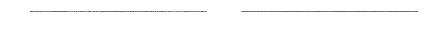

<Figure size 2160x1440 with 0 Axes>

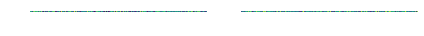

<Figure size 2160x1440 with 0 Axes>

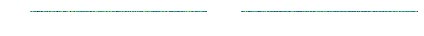

<Figure size 2160x1440 with 0 Axes>

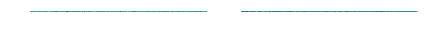

<Figure size 2160x1440 with 0 Axes>

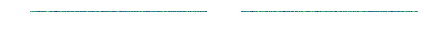

<Figure size 2160x1440 with 0 Axes>

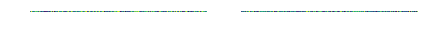

<Figure size 2160x1440 with 0 Axes>

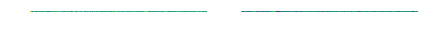

<Figure size 2160x1440 with 0 Axes>

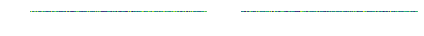

<Figure size 2160x1440 with 0 Axes>

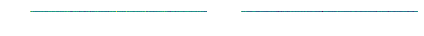

<Figure size 2160x1440 with 0 Axes>

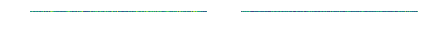

<Figure size 2160x1440 with 0 Axes>

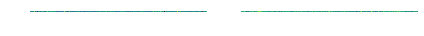

<Figure size 2160x1440 with 0 Axes>

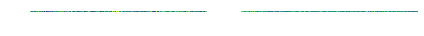

<Figure size 2160x1440 with 0 Axes>

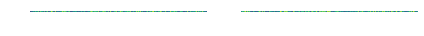

<Figure size 2160x1440 with 0 Axes>

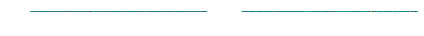

<Figure size 2160x1440 with 0 Axes>

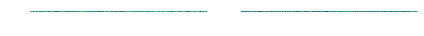

<Figure size 2160x1440 with 0 Axes>

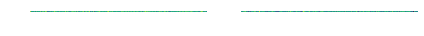

<Figure size 2160x1440 with 0 Axes>

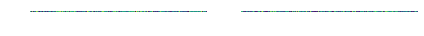

<Figure size 2160x1440 with 0 Axes>

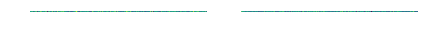

<Figure size 2160x1440 with 0 Axes>

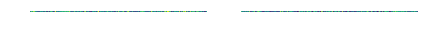

<Figure size 2160x1440 with 0 Axes>

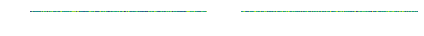

<Figure size 2160x1440 with 0 Axes>

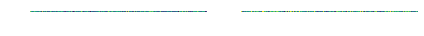

<Figure size 2160x1440 with 0 Axes>

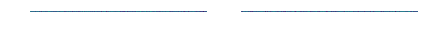

<Figure size 2160x1440 with 0 Axes>

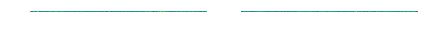

<Figure size 2160x1440 with 0 Axes>

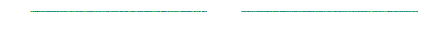

<Figure size 2160x1440 with 0 Axes>

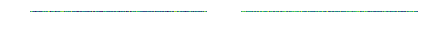

<Figure size 2160x1440 with 0 Axes>

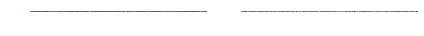

<Figure size 2160x1440 with 0 Axes>

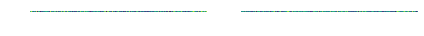

<Figure size 2160x1440 with 0 Axes>

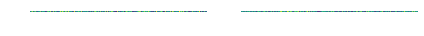

<Figure size 2160x1440 with 0 Axes>

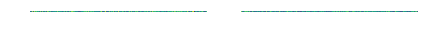

<Figure size 2160x1440 with 0 Axes>

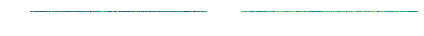

<Figure size 2160x1440 with 0 Axes>

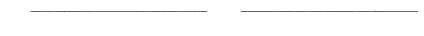

<Figure size 2160x1440 with 0 Axes>

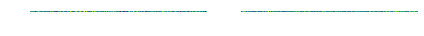

<Figure size 2160x1440 with 0 Axes>

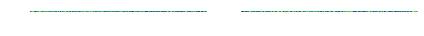

<Figure size 2160x1440 with 0 Axes>

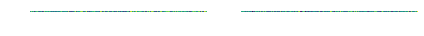

<Figure size 2160x1440 with 0 Axes>

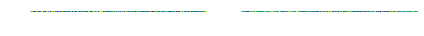

<Figure size 2160x1440 with 0 Axes>

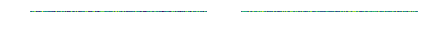

<Figure size 2160x1440 with 0 Axes>

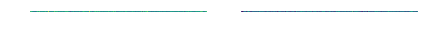

<Figure size 2160x1440 with 0 Axes>

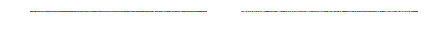

<Figure size 2160x1440 with 0 Axes>

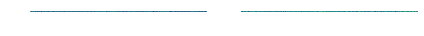

<Figure size 2160x1440 with 0 Axes>

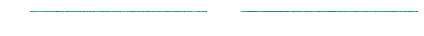

<Figure size 2160x1440 with 0 Axes>

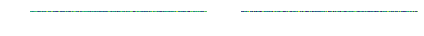

<Figure size 2160x1440 with 0 Axes>

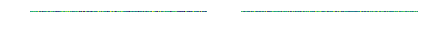

<Figure size 2160x1440 with 0 Axes>

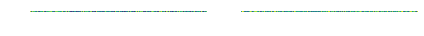

<Figure size 2160x1440 with 0 Axes>

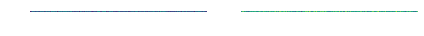

<Figure size 2160x1440 with 0 Axes>

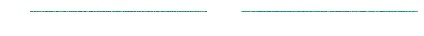

<Figure size 2160x1440 with 0 Axes>

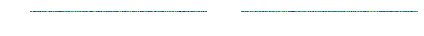

<Figure size 2160x1440 with 0 Axes>

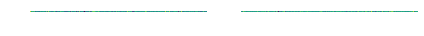

<Figure size 2160x1440 with 0 Axes>

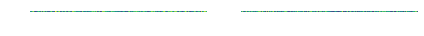

<Figure size 2160x1440 with 0 Axes>

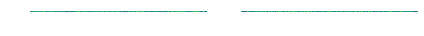

<Figure size 2160x1440 with 0 Axes>

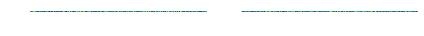

<Figure size 2160x1440 with 0 Axes>

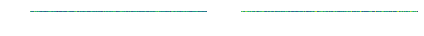

<Figure size 2160x1440 with 0 Axes>

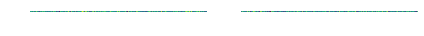

<Figure size 2160x1440 with 0 Axes>

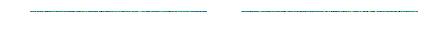

<Figure size 2160x1440 with 0 Axes>

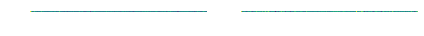

<Figure size 2160x1440 with 0 Axes>

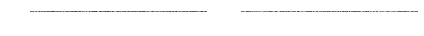

<Figure size 2160x1440 with 0 Axes>

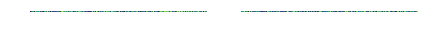

<Figure size 2160x1440 with 0 Axes>

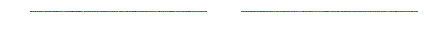

<Figure size 2160x1440 with 0 Axes>

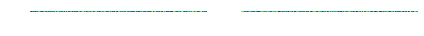

<Figure size 2160x1440 with 0 Axes>

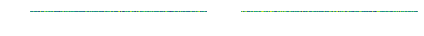

<Figure size 2160x1440 with 0 Axes>

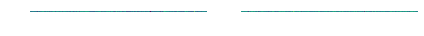

<Figure size 2160x1440 with 0 Axes>

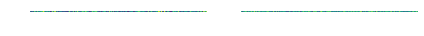

<Figure size 2160x1440 with 0 Axes>

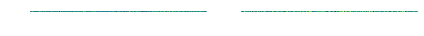

<Figure size 2160x1440 with 0 Axes>

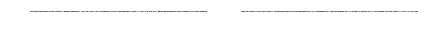

<Figure size 2160x1440 with 0 Axes>

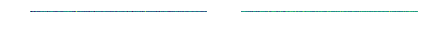

<Figure size 2160x1440 with 0 Axes>

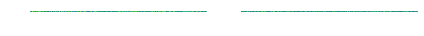

<Figure size 2160x1440 with 0 Axes>

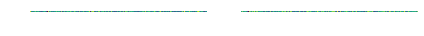

<Figure size 2160x1440 with 0 Axes>

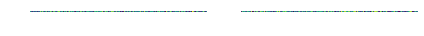

<Figure size 2160x1440 with 0 Axes>

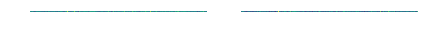

<Figure size 2160x1440 with 0 Axes>

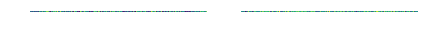

<Figure size 2160x1440 with 0 Axes>

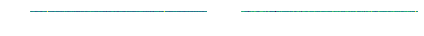

<Figure size 2160x1440 with 0 Axes>

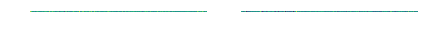

<Figure size 2160x1440 with 0 Axes>

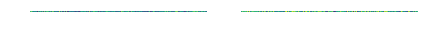

<Figure size 2160x1440 with 0 Axes>

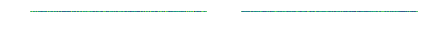

<Figure size 2160x1440 with 0 Axes>

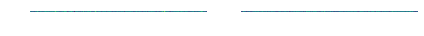

<Figure size 2160x1440 with 0 Axes>

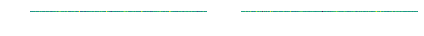

<Figure size 2160x1440 with 0 Axes>

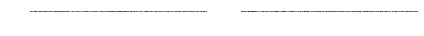

<Figure size 2160x1440 with 0 Axes>

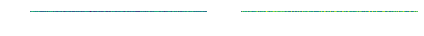

<Figure size 2160x1440 with 0 Axes>

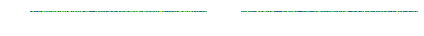

<Figure size 2160x1440 with 0 Axes>

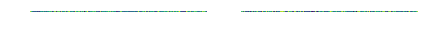

<Figure size 2160x1440 with 0 Axes>

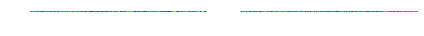

<Figure size 2160x1440 with 0 Axes>

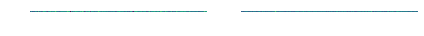

<Figure size 2160x1440 with 0 Axes>

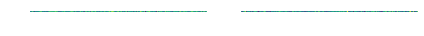

<Figure size 2160x1440 with 0 Axes>

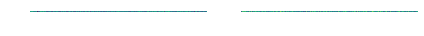

<Figure size 2160x1440 with 0 Axes>

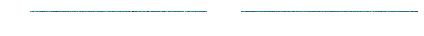

<Figure size 2160x1440 with 0 Axes>

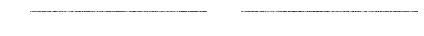

<Figure size 2160x1440 with 0 Axes>

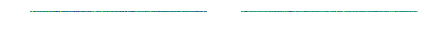

<Figure size 2160x1440 with 0 Axes>

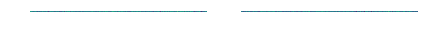

<Figure size 2160x1440 with 0 Axes>

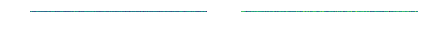

<Figure size 2160x1440 with 0 Axes>

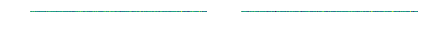

<Figure size 2160x1440 with 0 Axes>

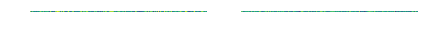

<Figure size 2160x1440 with 0 Axes>

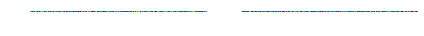

<Figure size 2160x1440 with 0 Axes>

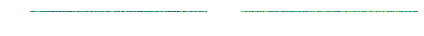

<Figure size 2160x1440 with 0 Axes>

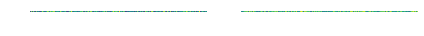

<Figure size 2160x1440 with 0 Axes>

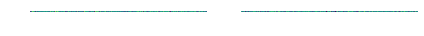

<Figure size 2160x1440 with 0 Axes>

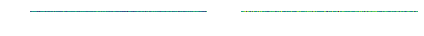

<Figure size 2160x1440 with 0 Axes>

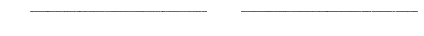

<Figure size 2160x1440 with 0 Axes>

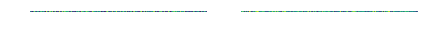

<Figure size 2160x1440 with 0 Axes>

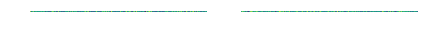

<Figure size 2160x1440 with 0 Axes>

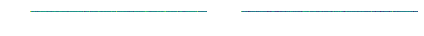

<Figure size 2160x1440 with 0 Axes>

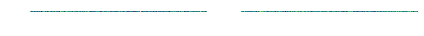

<Figure size 2160x1440 with 0 Axes>

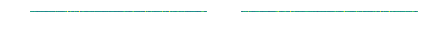

<Figure size 2160x1440 with 0 Axes>

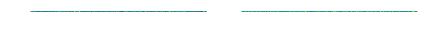

<Figure size 2160x1440 with 0 Axes>

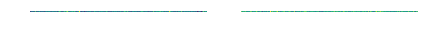

<Figure size 2160x1440 with 0 Axes>

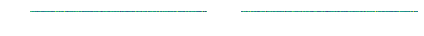

<Figure size 2160x1440 with 0 Axes>

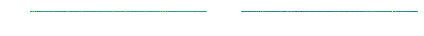

<Figure size 2160x1440 with 0 Axes>

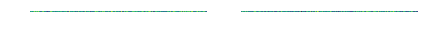

<Figure size 2160x1440 with 0 Axes>

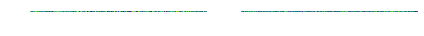

<Figure size 2160x1440 with 0 Axes>

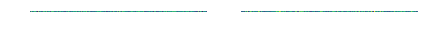

<Figure size 2160x1440 with 0 Axes>

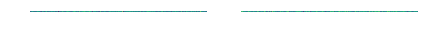

<Figure size 2160x1440 with 0 Axes>

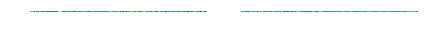

<Figure size 2160x1440 with 0 Axes>

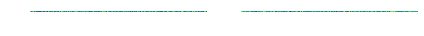

<Figure size 2160x1440 with 0 Axes>

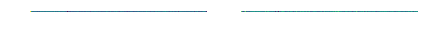

<Figure size 2160x1440 with 0 Axes>

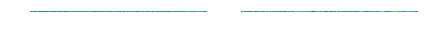

<Figure size 2160x1440 with 0 Axes>

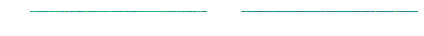

<Figure size 2160x1440 with 0 Axes>

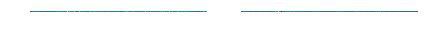

<Figure size 2160x1440 with 0 Axes>

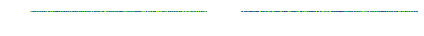

<Figure size 2160x1440 with 0 Axes>

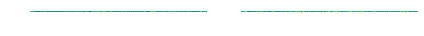

<Figure size 2160x1440 with 0 Axes>

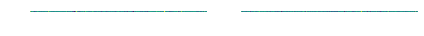

<Figure size 2160x1440 with 0 Axes>

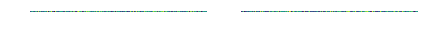

<Figure size 2160x1440 with 0 Axes>

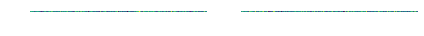

<Figure size 2160x1440 with 0 Axes>

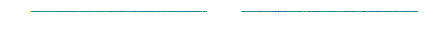

<Figure size 2160x1440 with 0 Axes>

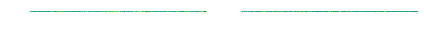

<Figure size 2160x1440 with 0 Axes>

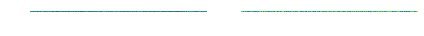

<Figure size 2160x1440 with 0 Axes>

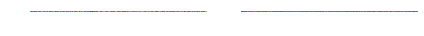

<Figure size 2160x1440 with 0 Axes>

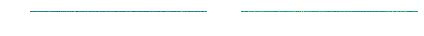

<Figure size 2160x1440 with 0 Axes>

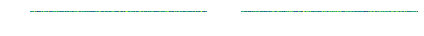

<Figure size 2160x1440 with 0 Axes>

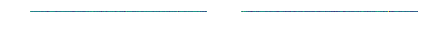

<Figure size 2160x1440 with 0 Axes>

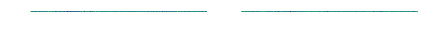

<Figure size 2160x1440 with 0 Axes>

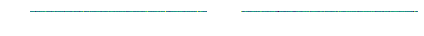

<Figure size 2160x1440 with 0 Axes>

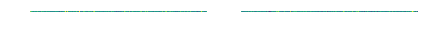

<Figure size 2160x1440 with 0 Axes>

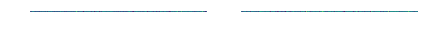

<Figure size 2160x1440 with 0 Axes>

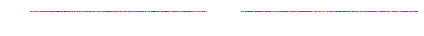

<Figure size 2160x1440 with 0 Axes>

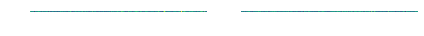

<Figure size 2160x1440 with 0 Axes>

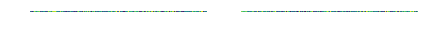

<Figure size 2160x1440 with 0 Axes>

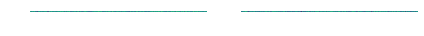

<Figure size 2160x1440 with 0 Axes>

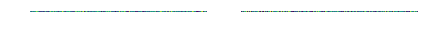

<Figure size 2160x1440 with 0 Axes>

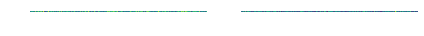

<Figure size 2160x1440 with 0 Axes>

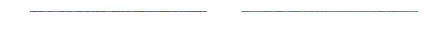

<Figure size 2160x1440 with 0 Axes>

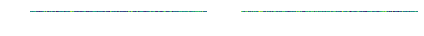

<Figure size 2160x1440 with 0 Axes>

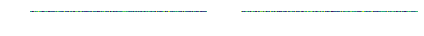

<Figure size 2160x1440 with 0 Axes>

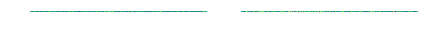

<Figure size 2160x1440 with 0 Axes>

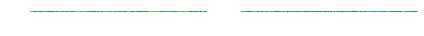

<Figure size 2160x1440 with 0 Axes>

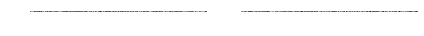

<Figure size 2160x1440 with 0 Axes>

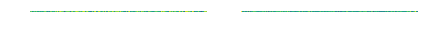

<Figure size 2160x1440 with 0 Axes>

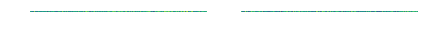

<Figure size 2160x1440 with 0 Axes>

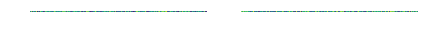

<Figure size 2160x1440 with 0 Axes>

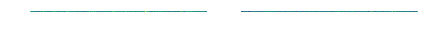

<Figure size 2160x1440 with 0 Axes>

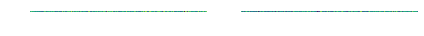

<Figure size 2160x1440 with 0 Axes>

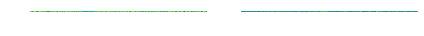

<Figure size 2160x1440 with 0 Axes>

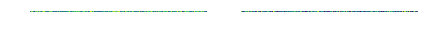

<Figure size 2160x1440 with 0 Axes>

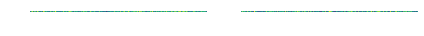

<Figure size 2160x1440 with 0 Axes>

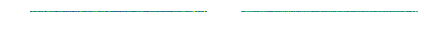

<Figure size 2160x1440 with 0 Axes>

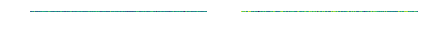

<Figure size 2160x1440 with 0 Axes>

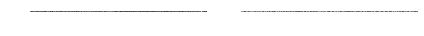

<Figure size 2160x1440 with 0 Axes>

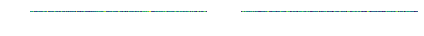

<Figure size 2160x1440 with 0 Axes>

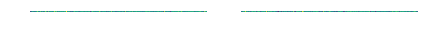

<Figure size 2160x1440 with 0 Axes>

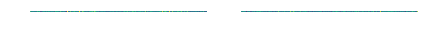

<Figure size 2160x1440 with 0 Axes>

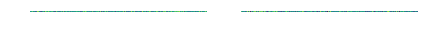

<Figure size 2160x1440 with 0 Axes>

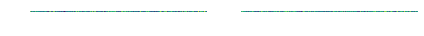

<Figure size 2160x1440 with 0 Axes>

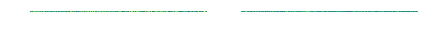

<Figure size 2160x1440 with 0 Axes>

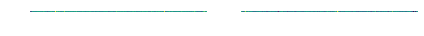

<Figure size 2160x1440 with 0 Axes>

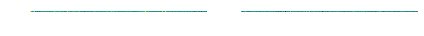

<Figure size 2160x1440 with 0 Axes>

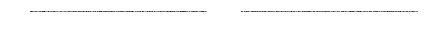

<Figure size 2160x1440 with 0 Axes>

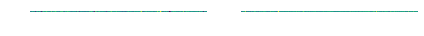

<Figure size 2160x1440 with 0 Axes>

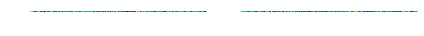

<Figure size 2160x1440 with 0 Axes>

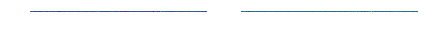

<Figure size 2160x1440 with 0 Axes>

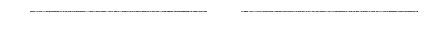

<Figure size 2160x1440 with 0 Axes>

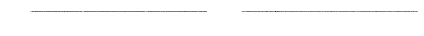

<Figure size 2160x1440 with 0 Axes>

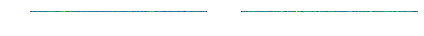

<Figure size 2160x1440 with 0 Axes>

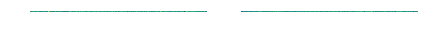

<Figure size 2160x1440 with 0 Axes>

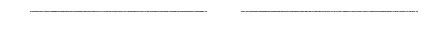

<Figure size 2160x1440 with 0 Axes>

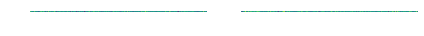

<Figure size 2160x1440 with 0 Axes>

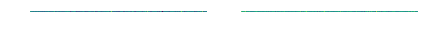

<Figure size 2160x1440 with 0 Axes>

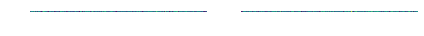

<Figure size 2160x1440 with 0 Axes>

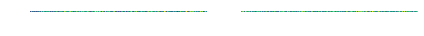

<Figure size 2160x1440 with 0 Axes>

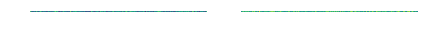

<Figure size 2160x1440 with 0 Axes>

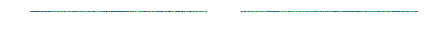

<Figure size 2160x1440 with 0 Axes>

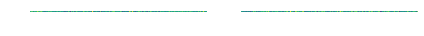

<Figure size 2160x1440 with 0 Axes>

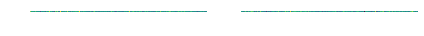

<Figure size 2160x1440 with 0 Axes>

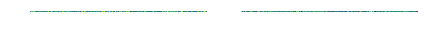

<Figure size 2160x1440 with 0 Axes>

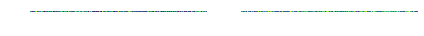

<Figure size 2160x1440 with 0 Axes>

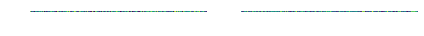

<Figure size 2160x1440 with 0 Axes>

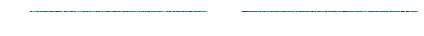

<Figure size 2160x1440 with 0 Axes>

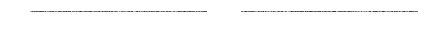

<Figure size 2160x1440 with 0 Axes>

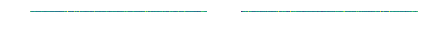

<Figure size 2160x1440 with 0 Axes>

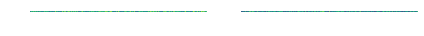

<Figure size 2160x1440 with 0 Axes>

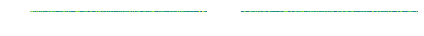

<Figure size 2160x1440 with 0 Axes>

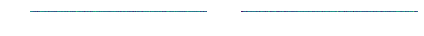

<Figure size 2160x1440 with 0 Axes>

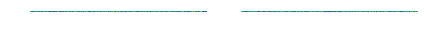

<Figure size 2160x1440 with 0 Axes>

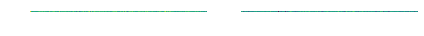

<Figure size 2160x1440 with 0 Axes>

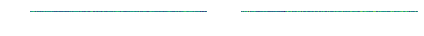

<Figure size 2160x1440 with 0 Axes>

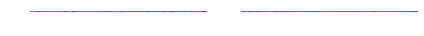

<Figure size 2160x1440 with 0 Axes>

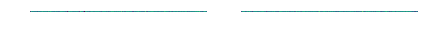

<Figure size 2160x1440 with 0 Axes>

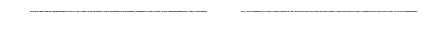

<Figure size 2160x1440 with 0 Axes>

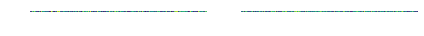

<Figure size 2160x1440 with 0 Axes>

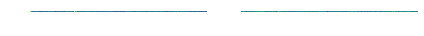

<Figure size 2160x1440 with 0 Axes>

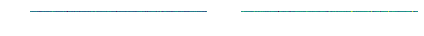

<Figure size 2160x1440 with 0 Axes>

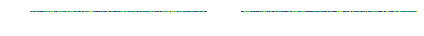

<Figure size 2160x1440 with 0 Axes>

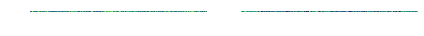

<Figure size 2160x1440 with 0 Axes>

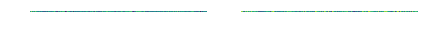

<Figure size 2160x1440 with 0 Axes>

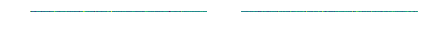

<Figure size 2160x1440 with 0 Axes>

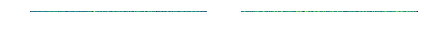

<Figure size 2160x1440 with 0 Axes>

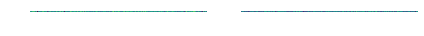

<Figure size 2160x1440 with 0 Axes>

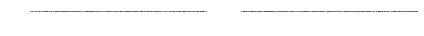

<Figure size 2160x1440 with 0 Axes>

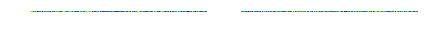

<Figure size 2160x1440 with 0 Axes>

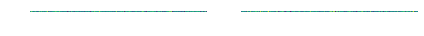

<Figure size 2160x1440 with 0 Axes>

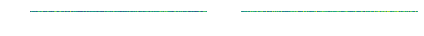

<Figure size 2160x1440 with 0 Axes>

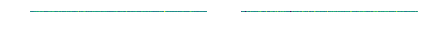

<Figure size 2160x1440 with 0 Axes>

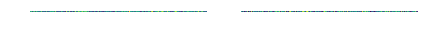

<Figure size 2160x1440 with 0 Axes>

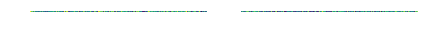

<Figure size 2160x1440 with 0 Axes>

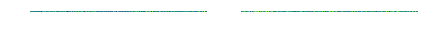

<Figure size 2160x1440 with 0 Axes>

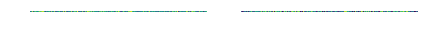

<Figure size 2160x1440 with 0 Axes>

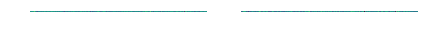

<Figure size 2160x1440 with 0 Axes>

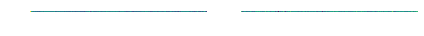

<Figure size 2160x1440 with 0 Axes>

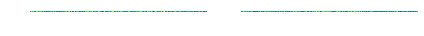

<Figure size 2160x1440 with 0 Axes>

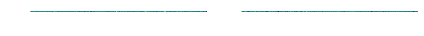

<Figure size 2160x1440 with 0 Axes>

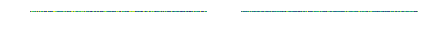

<Figure size 2160x1440 with 0 Axes>

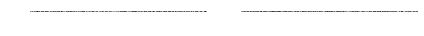

<Figure size 2160x1440 with 0 Axes>

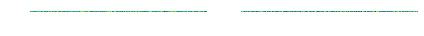

<Figure size 2160x1440 with 0 Axes>

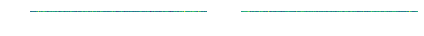

<Figure size 2160x1440 with 0 Axes>

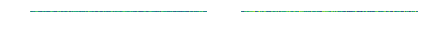

<Figure size 2160x1440 with 0 Axes>

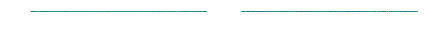

<Figure size 2160x1440 with 0 Axes>

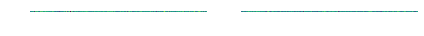

<Figure size 2160x1440 with 0 Axes>

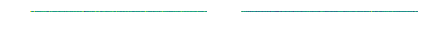

<Figure size 2160x1440 with 0 Axes>

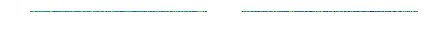

<Figure size 2160x1440 with 0 Axes>

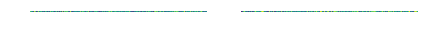

<Figure size 2160x1440 with 0 Axes>

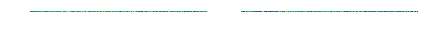

<Figure size 2160x1440 with 0 Axes>

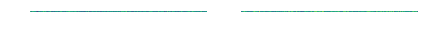

<Figure size 2160x1440 with 0 Axes>

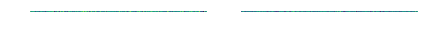

<Figure size 2160x1440 with 0 Axes>

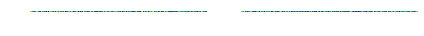

<Figure size 2160x1440 with 0 Axes>

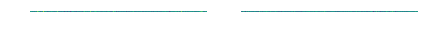

<Figure size 2160x1440 with 0 Axes>

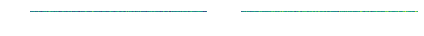

<Figure size 2160x1440 with 0 Axes>

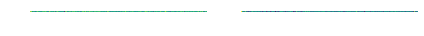

<Figure size 2160x1440 with 0 Axes>

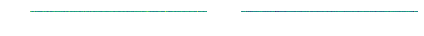

<Figure size 2160x1440 with 0 Axes>

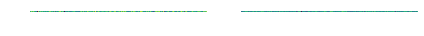

<Figure size 2160x1440 with 0 Axes>

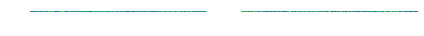

<Figure size 2160x1440 with 0 Axes>

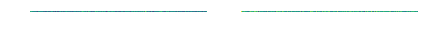

<Figure size 2160x1440 with 0 Axes>

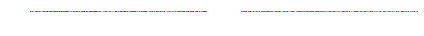

<Figure size 2160x1440 with 0 Axes>

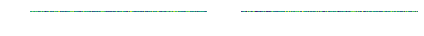

<Figure size 2160x1440 with 0 Axes>

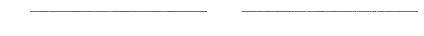

<Figure size 2160x1440 with 0 Axes>

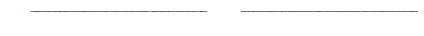

<Figure size 2160x1440 with 0 Axes>

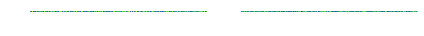

<Figure size 2160x1440 with 0 Axes>

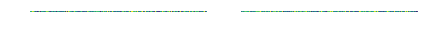

<Figure size 2160x1440 with 0 Axes>

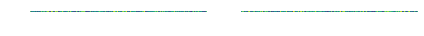

<Figure size 2160x1440 with 0 Axes>

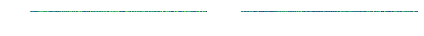

<Figure size 2160x1440 with 0 Axes>

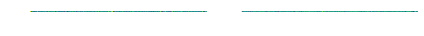

<Figure size 2160x1440 with 0 Axes>

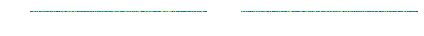

<Figure size 2160x1440 with 0 Axes>

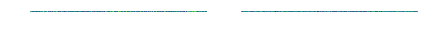

<Figure size 2160x1440 with 0 Axes>

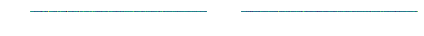

<Figure size 2160x1440 with 0 Axes>

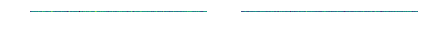

<Figure size 2160x1440 with 0 Axes>

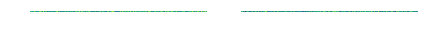

<Figure size 2160x1440 with 0 Axes>

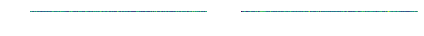

<Figure size 2160x1440 with 0 Axes>

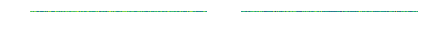

<Figure size 2160x1440 with 0 Axes>

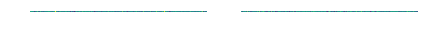

<Figure size 2160x1440 with 0 Axes>

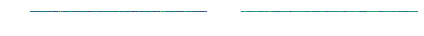

<Figure size 2160x1440 with 0 Axes>

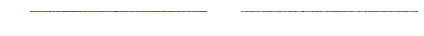

<Figure size 2160x1440 with 0 Axes>

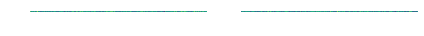

<Figure size 2160x1440 with 0 Axes>

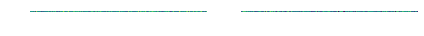

<Figure size 2160x1440 with 0 Axes>

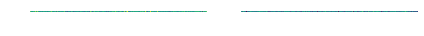

<Figure size 2160x1440 with 0 Axes>

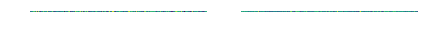

<Figure size 2160x1440 with 0 Axes>

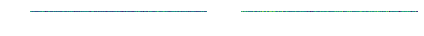

<Figure size 2160x1440 with 0 Axes>

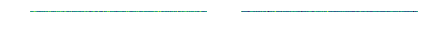

<Figure size 2160x1440 with 0 Axes>

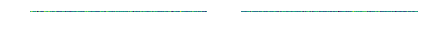

<Figure size 2160x1440 with 0 Axes>

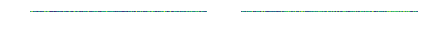

<Figure size 2160x1440 with 0 Axes>

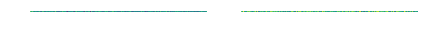

<Figure size 2160x1440 with 0 Axes>

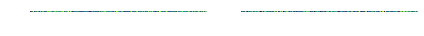

<Figure size 2160x1440 with 0 Axes>

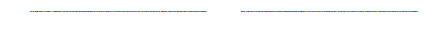

<Figure size 2160x1440 with 0 Axes>

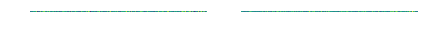

<Figure size 2160x1440 with 0 Axes>

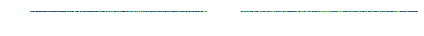

<Figure size 2160x1440 with 0 Axes>

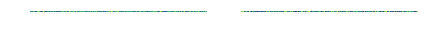

<Figure size 2160x1440 with 0 Axes>

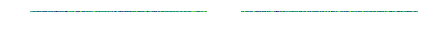

<Figure size 2160x1440 with 0 Axes>

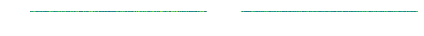

<Figure size 2160x1440 with 0 Axes>

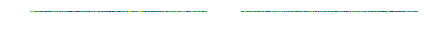

<Figure size 2160x1440 with 0 Axes>

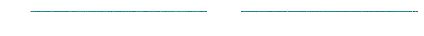

<Figure size 2160x1440 with 0 Axes>

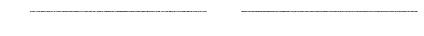

<Figure size 2160x1440 with 0 Axes>

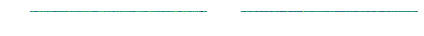

<Figure size 2160x1440 with 0 Axes>

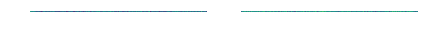

<Figure size 2160x1440 with 0 Axes>

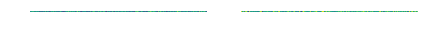

<Figure size 2160x1440 with 0 Axes>

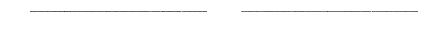

<Figure size 2160x1440 with 0 Axes>

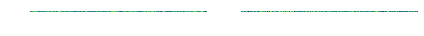

<Figure size 2160x1440 with 0 Axes>

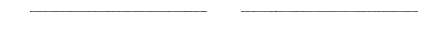

<Figure size 2160x1440 with 0 Axes>

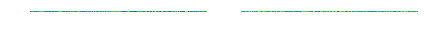

<Figure size 2160x1440 with 0 Axes>

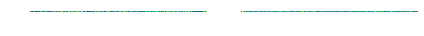

<Figure size 2160x1440 with 0 Axes>

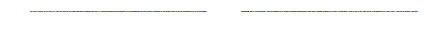

<Figure size 2160x1440 with 0 Axes>

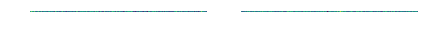

<Figure size 2160x1440 with 0 Axes>

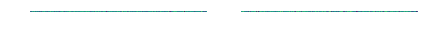

<Figure size 2160x1440 with 0 Axes>

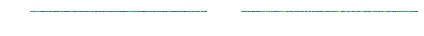

<Figure size 2160x1440 with 0 Axes>

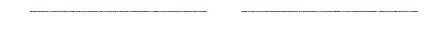

<Figure size 2160x1440 with 0 Axes>

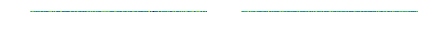

<Figure size 2160x1440 with 0 Axes>

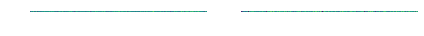

<Figure size 2160x1440 with 0 Axes>

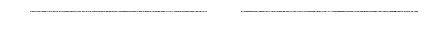

<Figure size 2160x1440 with 0 Axes>

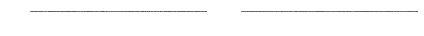

<Figure size 2160x1440 with 0 Axes>

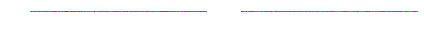

<Figure size 2160x1440 with 0 Axes>

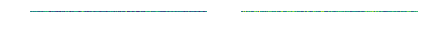

<Figure size 2160x1440 with 0 Axes>

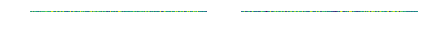

<Figure size 2160x1440 with 0 Axes>

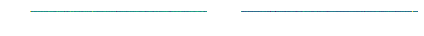

<Figure size 2160x1440 with 0 Axes>

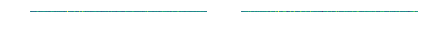

<Figure size 2160x1440 with 0 Axes>

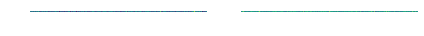

<Figure size 2160x1440 with 0 Axes>

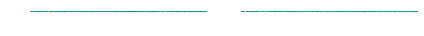

<Figure size 2160x1440 with 0 Axes>

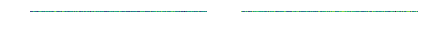

<Figure size 2160x1440 with 0 Axes>

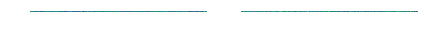

<Figure size 2160x1440 with 0 Axes>

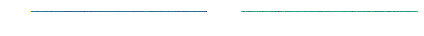

<Figure size 2160x1440 with 0 Axes>

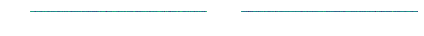

<Figure size 2160x1440 with 0 Axes>

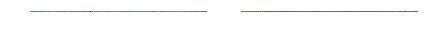

<Figure size 2160x1440 with 0 Axes>

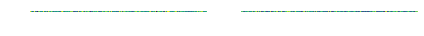

<Figure size 2160x1440 with 0 Axes>

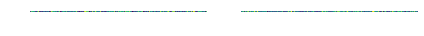

<Figure size 2160x1440 with 0 Axes>

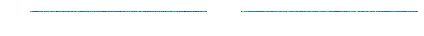

<Figure size 2160x1440 with 0 Axes>

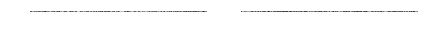

<Figure size 2160x1440 with 0 Axes>

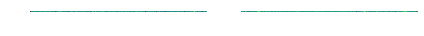

<Figure size 2160x1440 with 0 Axes>

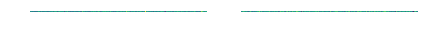

<Figure size 2160x1440 with 0 Axes>

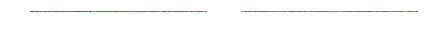

<Figure size 2160x1440 with 0 Axes>

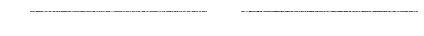

<Figure size 2160x1440 with 0 Axes>

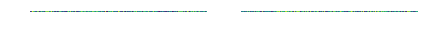

<Figure size 2160x1440 with 0 Axes>

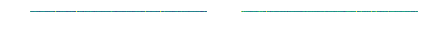

<Figure size 2160x1440 with 0 Axes>

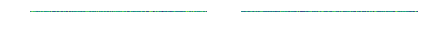

<Figure size 2160x1440 with 0 Axes>

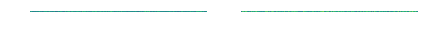

<Figure size 2160x1440 with 0 Axes>

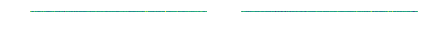

<Figure size 2160x1440 with 0 Axes>

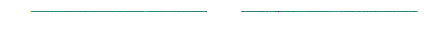

<Figure size 2160x1440 with 0 Axes>

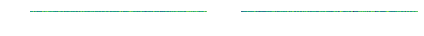

<Figure size 2160x1440 with 0 Axes>

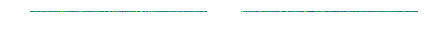

<Figure size 2160x1440 with 0 Axes>

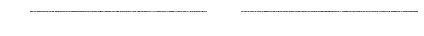

<Figure size 2160x1440 with 0 Axes>

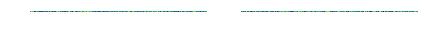

<Figure size 2160x1440 with 0 Axes>

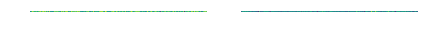

<Figure size 2160x1440 with 0 Axes>

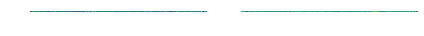

<Figure size 2160x1440 with 0 Axes>

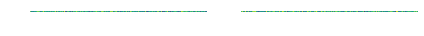

<Figure size 2160x1440 with 0 Axes>

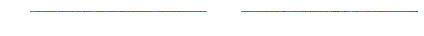

<Figure size 2160x1440 with 0 Axes>

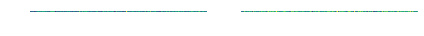

<Figure size 2160x1440 with 0 Axes>

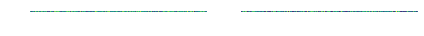

<Figure size 2160x1440 with 0 Axes>

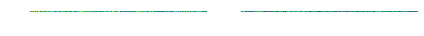

<Figure size 2160x1440 with 0 Axes>

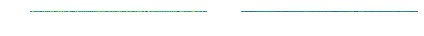

<Figure size 2160x1440 with 0 Axes>

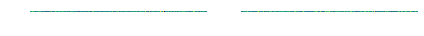

<Figure size 2160x1440 with 0 Axes>

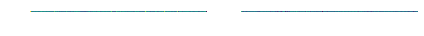

<Figure size 2160x1440 with 0 Axes>

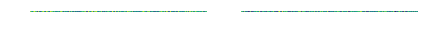

<Figure size 2160x1440 with 0 Axes>

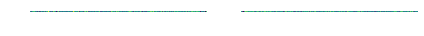

<Figure size 2160x1440 with 0 Axes>

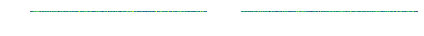

<Figure size 2160x1440 with 0 Axes>

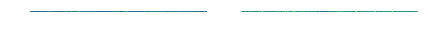

<Figure size 2160x1440 with 0 Axes>

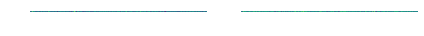

<Figure size 2160x1440 with 0 Axes>

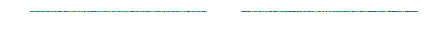

<Figure size 2160x1440 with 0 Axes>

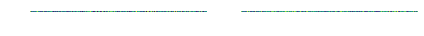

<Figure size 2160x1440 with 0 Axes>

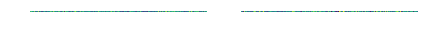

<Figure size 2160x1440 with 0 Axes>

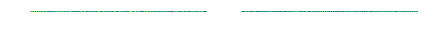

<Figure size 2160x1440 with 0 Axes>

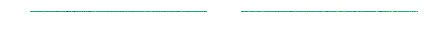

<Figure size 2160x1440 with 0 Axes>

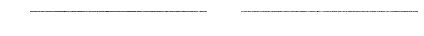

<Figure size 2160x1440 with 0 Axes>

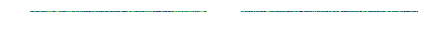

<Figure size 2160x1440 with 0 Axes>

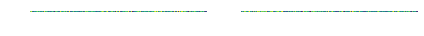

<Figure size 2160x1440 with 0 Axes>

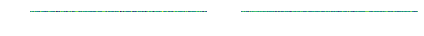

<Figure size 2160x1440 with 0 Axes>

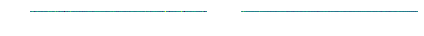

<Figure size 2160x1440 with 0 Axes>

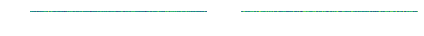

<Figure size 2160x1440 with 0 Axes>

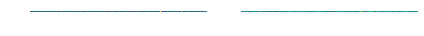

<Figure size 2160x1440 with 0 Axes>

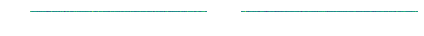

<Figure size 2160x1440 with 0 Axes>

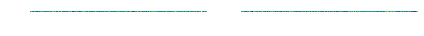

<Figure size 2160x1440 with 0 Axes>

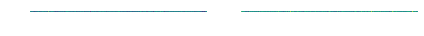

<Figure size 2160x1440 with 0 Axes>

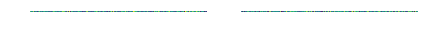

<Figure size 2160x1440 with 0 Axes>

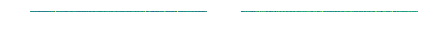

<Figure size 2160x1440 with 0 Axes>

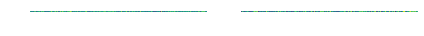

<Figure size 2160x1440 with 0 Axes>

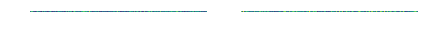

<Figure size 2160x1440 with 0 Axes>

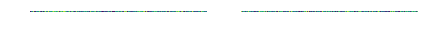

<Figure size 2160x1440 with 0 Axes>

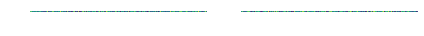

<Figure size 2160x1440 with 0 Axes>

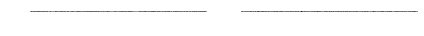

<Figure size 2160x1440 with 0 Axes>

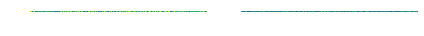

<Figure size 2160x1440 with 0 Axes>

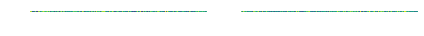

<Figure size 2160x1440 with 0 Axes>

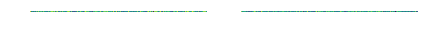

<Figure size 2160x1440 with 0 Axes>

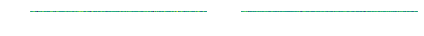

<Figure size 2160x1440 with 0 Axes>

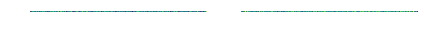

<Figure size 2160x1440 with 0 Axes>

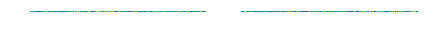

<Figure size 2160x1440 with 0 Axes>

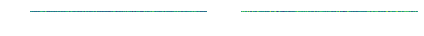

<Figure size 2160x1440 with 0 Axes>

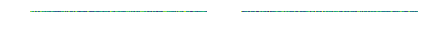

<Figure size 2160x1440 with 0 Axes>

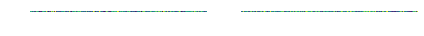

<Figure size 2160x1440 with 0 Axes>

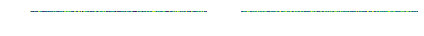

<Figure size 2160x1440 with 0 Axes>

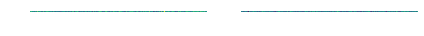

<Figure size 2160x1440 with 0 Axes>

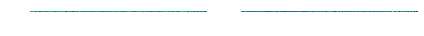

<Figure size 2160x1440 with 0 Axes>

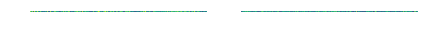

<Figure size 2160x1440 with 0 Axes>

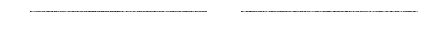

<Figure size 2160x1440 with 0 Axes>

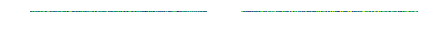

<Figure size 2160x1440 with 0 Axes>

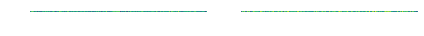

<Figure size 2160x1440 with 0 Axes>

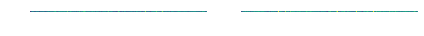

<Figure size 2160x1440 with 0 Axes>

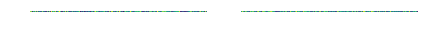

<Figure size 2160x1440 with 0 Axes>

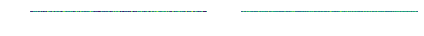

<Figure size 2160x1440 with 0 Axes>

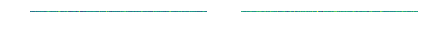

<Figure size 2160x1440 with 0 Axes>

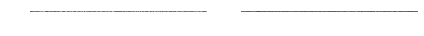

<Figure size 2160x1440 with 0 Axes>

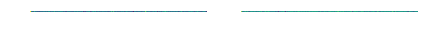

<Figure size 2160x1440 with 0 Axes>

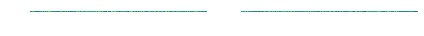

<Figure size 2160x1440 with 0 Axes>

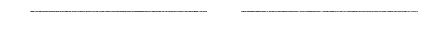

<Figure size 2160x1440 with 0 Axes>

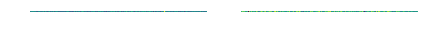

<Figure size 2160x1440 with 0 Axes>

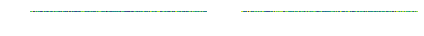

<Figure size 2160x1440 with 0 Axes>

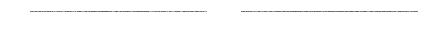

<Figure size 2160x1440 with 0 Axes>

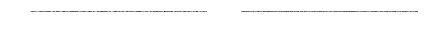

<Figure size 2160x1440 with 0 Axes>

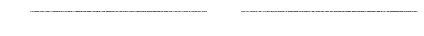

<Figure size 2160x1440 with 0 Axes>

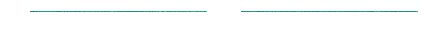

<Figure size 2160x1440 with 0 Axes>

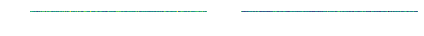

<Figure size 2160x1440 with 0 Axes>

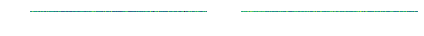

<Figure size 2160x1440 with 0 Axes>

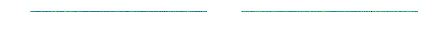

<Figure size 2160x1440 with 0 Axes>

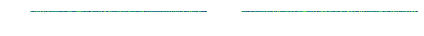

<Figure size 2160x1440 with 0 Axes>

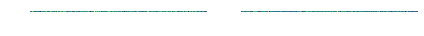

<Figure size 2160x1440 with 0 Axes>

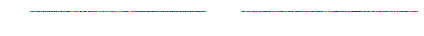

<Figure size 2160x1440 with 0 Axes>

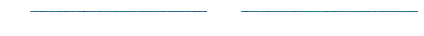

<Figure size 2160x1440 with 0 Axes>

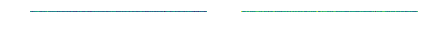

<Figure size 2160x1440 with 0 Axes>

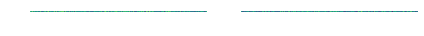

<Figure size 2160x1440 with 0 Axes>

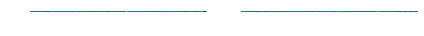

<Figure size 2160x1440 with 0 Axes>

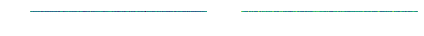

<Figure size 2160x1440 with 0 Axes>

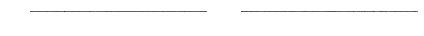

<Figure size 2160x1440 with 0 Axes>

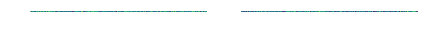

<Figure size 2160x1440 with 0 Axes>

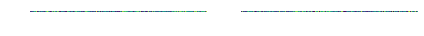

<Figure size 2160x1440 with 0 Axes>

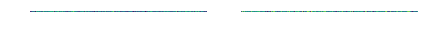

<Figure size 2160x1440 with 0 Axes>

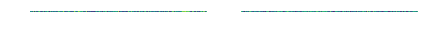

<Figure size 2160x1440 with 0 Axes>

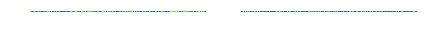

<Figure size 2160x1440 with 0 Axes>

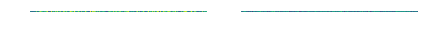

<Figure size 2160x1440 with 0 Axes>

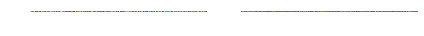

<Figure size 2160x1440 with 0 Axes>

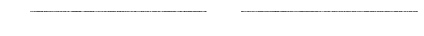

<Figure size 2160x1440 with 0 Axes>

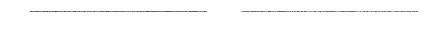

<Figure size 2160x1440 with 0 Axes>

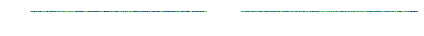

<Figure size 2160x1440 with 0 Axes>

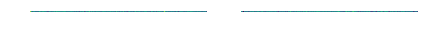

<Figure size 2160x1440 with 0 Axes>

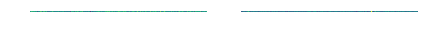

<Figure size 2160x1440 with 0 Axes>

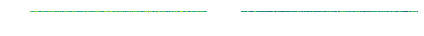

<Figure size 2160x1440 with 0 Axes>

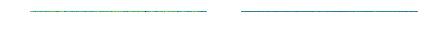

<Figure size 2160x1440 with 0 Axes>

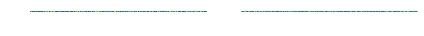

<Figure size 2160x1440 with 0 Axes>

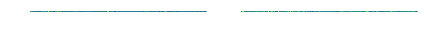

<Figure size 2160x1440 with 0 Axes>

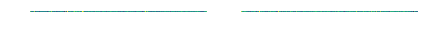

<Figure size 2160x1440 with 0 Axes>

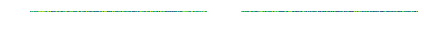

<Figure size 2160x1440 with 0 Axes>

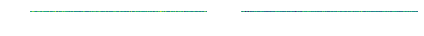

<Figure size 2160x1440 with 0 Axes>

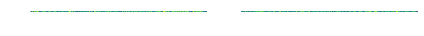

<Figure size 2160x1440 with 0 Axes>

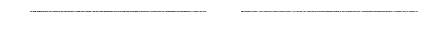

<Figure size 2160x1440 with 0 Axes>

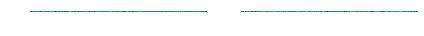

<Figure size 2160x1440 with 0 Axes>

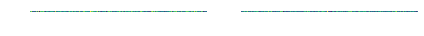

<Figure size 2160x1440 with 0 Axes>

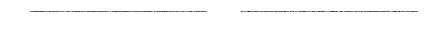

<Figure size 2160x1440 with 0 Axes>

In [48]:
for layer in model.layers:
    if 'conv' in layer.name:
        filters, bias= layer.get_weights()
        print(layer.name, filters.shape)
         #normalize filter values between  0 and 1 for visualization
        f_min, f_max = filters.min(), filters.max()
        filters = (filters - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        axis_x=1
        #plotting all the filters
        for i in range(filters.shape[3]):
        #for i in range(6):
            #get the filters
            
            filt=filters[:,:,:, i]
            plotFilters(filt)

(5, 5, 3, 32) (32,)


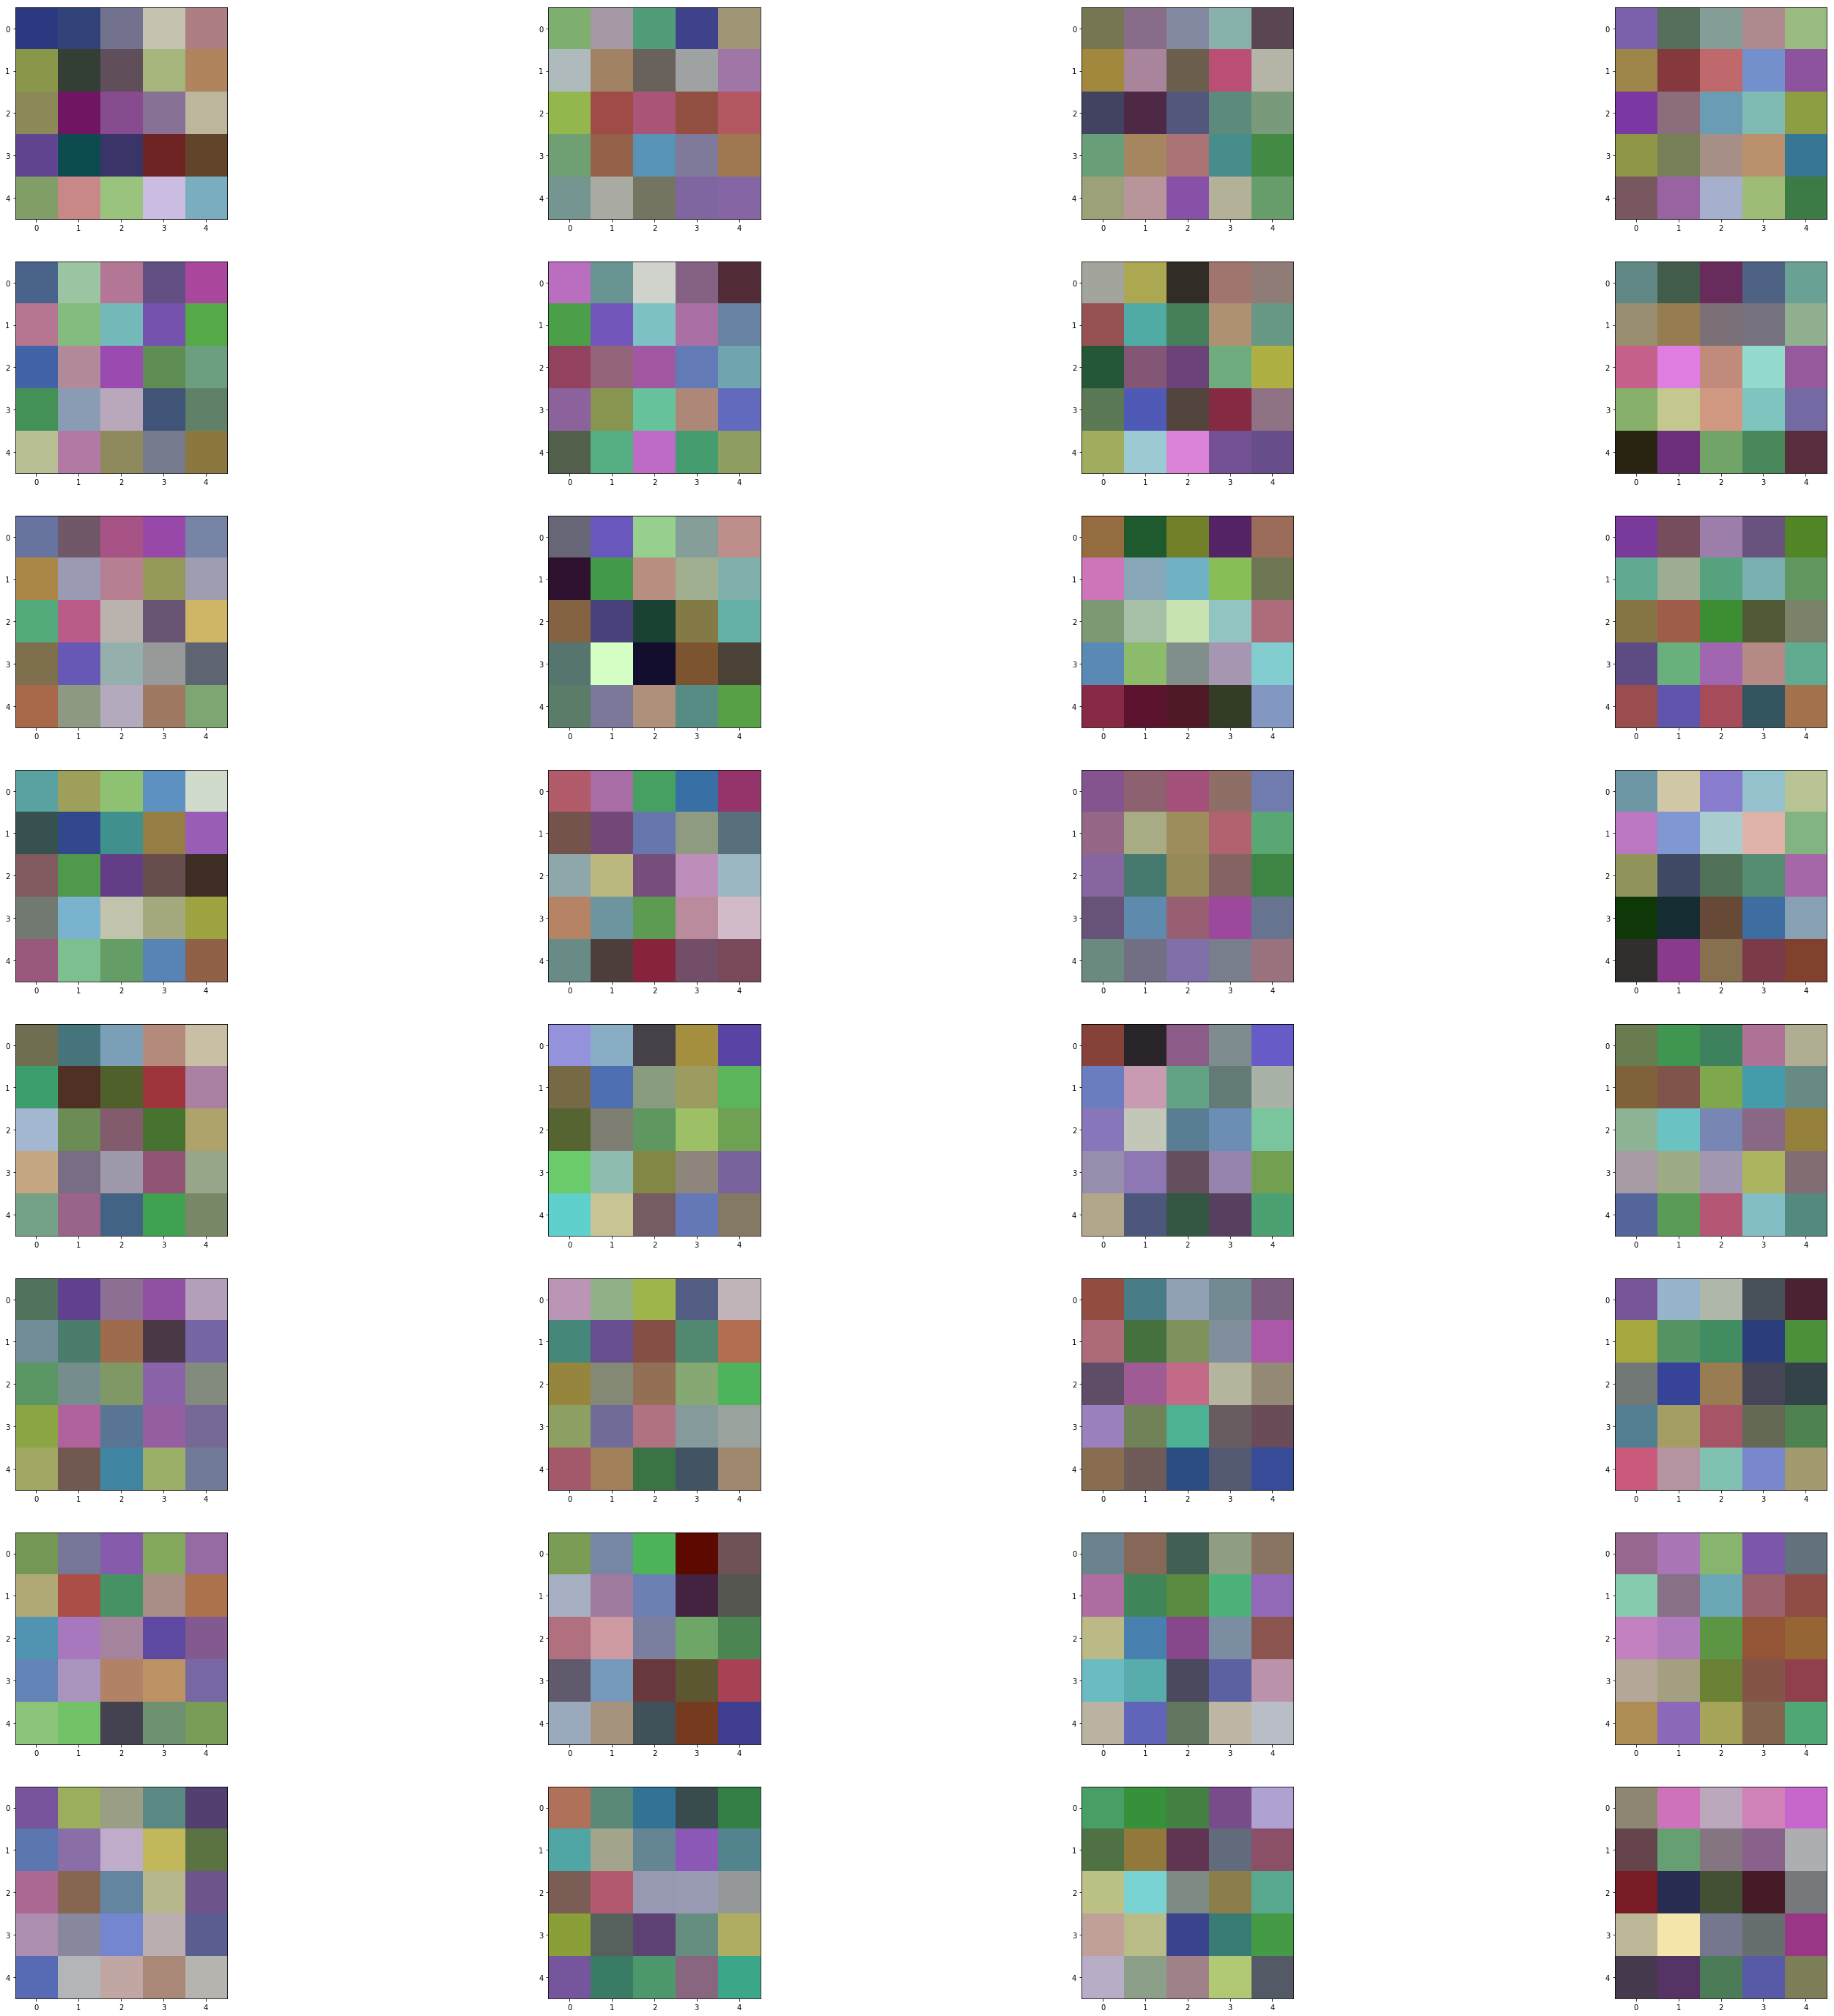

In [49]:


layer= model.layers
layer_1= layer[0]
filter_1, bias_1= layer_1.get_weights()
print(filter_1.shape, bias_1.shape)

#Normalize the weights
f_min, f_max = filter_1.min(), filter_1.max()
filter_1 = (filter_1 - f_min) / (f_max - f_min)

fig= plt.figure(figsize=(50,50))
for i in range(32):
    ax = fig.add_subplot(8,4,i+1)
    ax.imshow(filter_1[:,:,:,i], cmap='gray')



In [16]:
# #Iterate thru all the layers of the model
# for layer in model.layers:
#     if 'conv' in layer.name:
#         weights, bias= layer.get_weights()
# #         print(layer.name, filters.shape)
#         print(layer.name)
        
#         #normalize filter values between  0 and 1 for visualization
#         f_min, f_max = weights.min(), weights.max()
#         filters = (weights - f_min) / (f_max - f_min)  
#         print(filters.shape[3])
#         filter_cnt=1
        
#         #plotting all the filters
#         for i in range(filters.shape[3]):
#             #get the filters
#             filt=filters[:,:,:, i]
#             #plotting each of the channel, color image RGB channels
#             for j in range(filters.shape[0]):
#                 ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
#                 ax.set_xticks([])
#                 ax.set_yticks([])
#                 plt.imshow(filt[:,:, j])
#                 filter_cnt+=1
#         plt.show()

In [15]:
# img_path='dataset/cam1_splitted/test/OK/imagen_2020_12_18_1132_33313.png' #dog
# # Define a new Model, Input= image 
# # Output= intermediate representations for all layers in the  
# # previous model after the first.
# successive_outputs = [layer.output for layer in model.layers[1:]]#visualization_model = Model(img_input, successive_outputs)
# visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)#Load the input image
# img = load_img(img_path, target_size=(150, 150))# Convert ht image to Array of dimension (150,150,3)
# x   = img_to_array(img)                           
# x   = x.reshape((1,) + x.shape)# Rescale by 1/255
# x /= 255.0# Let's run input image through our vislauization network
# # to obtain all intermediate representations for the image.
# successive_feature_maps = visualization_model.predict(x)# Retrieve are the names of the layers, so can have them as part of our plot
# layer_names = [layer.name for layer in model.layers]
# for layer_name, feature_map in zip(layer_names, successive_feature_maps):
#   print(feature_map.shape)
#   if len(feature_map.shape) == 4:
    
#     # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
#     n_features = feature_map.shape[-1]  # number of features in the feature map
#     size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
#     # We will tile our images in this matrix
#     display_grid = np.zeros((size, size * n_features))
    
#     # Postprocess the feature to be visually palatable
#     for i in range(n_features):
#       x  = feature_map[0, :, :, i]
#       x -= x.mean()
#       x /= x.std ()
#       x *=  64
#       x += 128
#       x  = np.clip(x, 0, 255).astype('uint8')
#       # Tile each filter into a horizontal grid
#       display_grid[:, i * size : (i + 1) * size] = x# Display the grid
#     scale = 20. / n_features
#     plt.figure( figsize=(scale * n_features, scale) )
#     plt.title ( layer_name )
#     plt.grid  ( False )
#     plt.imshow( display_grid, aspect='auto', cmap='viridis' )